# Imports

In [1]:
import commons

# Plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# OS
import os
import platform
import sys

# Data
import random
import numpy as np
import pandas as pd

# TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AvgPool2D, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

# import tensorflow_hub as hub
#import tensorflow_model_analysis as tfma


/Users/tacocat/anaconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
def verify_gpu_m1():
    # import os
    # import platform
    # import sys
    
    # import numpy as np
    # import pandas as pd
    # import tensorflow as tf
    # from tensorflow import keras
  
    result = pd.DataFrame(columns=['library', 'version'])
    result.loc[0] = ['Platform', platform.platform()]
    result.loc[1] = ['TensorFlow', tf.__version__]
    result.loc[2] = ['Python', str(sys.version).split(' ')[0]]
    #result.loc[3] = ['Keras', tf.keras.__version__]
    result.loc[3] = ['Pandas', pd.__version__]
    #result.loc[] = ['SkLearn', sk.__version__]
    #result.loc[] = ['SciPy', sp.__version__]
    result.loc[4] = ['Metal GPU Access', 
                     len(tf.config.list_physical_devices('GPU')) > 0]
    return result

# Set Globals

In [10]:
PROJECT_ROOT = os.getcwd()

In [11]:
def prepdata(train_dir, valid_dir, test_dir, GLOBAL_CONFIG):
    tf.random.set_seed(GLOBAL_CONFIG['RANDOM_SEED'])
    print('Preparing dataset')

    #Override:
    GLOBAL_CONFIG['DIMS'] = (224, 224)
    GLOBAL_CONFIG['INPUT_SHAPE'] = (224, 224, 3)
    
    # Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
    train_datagen = ImageDataGenerator(rescale=1./255) #rescale=1./255
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    print('Dimensions:', GLOBAL_CONFIG['DIMS'], '\n')

    # Import data from directories and turn it into batches
    print("\nTraining images:")
    train_data = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=GLOBAL_CONFIG['BATCH_SIZE'], # number of images to process at a time 
                                                   target_size=GLOBAL_CONFIG['DIMS'],
                                                   class_mode="categorical", # type of problem we're working on
                                                   seed=GLOBAL_CONFIG['RANDOM_SEED'],
                                                   shuffle=True,
                                                   classes=GLOBAL_CONFIG['CLASSES'],
                                                   )
    print("Validation images:")
    valid_data = valid_datagen.flow_from_directory(valid_dir,
                                                   batch_size=GLOBAL_CONFIG['BATCH_SIZE'],
                                                   target_size=GLOBAL_CONFIG['DIMS'],
                                                   class_mode="categorical",
                                                   seed=GLOBAL_CONFIG['RANDOM_SEED'],
                                                   shuffle=True,
                                                   classes=GLOBAL_CONFIG['CLASSES'])
    
    print("Test images:")
    test_data = test_datagen.flow_from_directory(test_dir,
                                                   batch_size=GLOBAL_CONFIG['BATCH_SIZE'],
                                                   target_size=GLOBAL_CONFIG['DIMS'],
                                                   class_mode="categorical",
                                                   shuffle=False,
                                                   classes=GLOBAL_CONFIG['CLASSES'])
    
    GLOBAL_CONFIG['CLASSES'] = train_data.num_classes
    test_data_indices = test_data.class_indices
    
    print('Prepartaion complete')
    return train_data, valid_data, test_data, test_data_indices, GLOBAL_CONFIG

In [12]:
def configure_notebook(TARGET):
    print(verify_gpu_m1())
    
    if TARGET == 'mood':
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_moodtheme.tsv')
    else:
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_genre.tsv')

    tracks, tags, extra = commons.read_file(autotagging)
    head = list(tags.keys())[0]
    classes = tags[head].keys()
    CLASSES = list(classes)
    print(CLASSES)
    #os.chdir('/Volumes/DYLAN-T7 1/Music Dataset')
    print('\npwd:',os.getcwd())
    TRAIN_DIR = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'train')
    VALID_DIR = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'valid')
    TEST_DIR = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test')
    
    GLOBAL_CONFIG = {'SCALING_FACTOR': 1,
                     'INPUT_SHAPE': None,
                     'DIMS': None,
                     'BATCH_SIZE': 32,
                     'CLASSES': CLASSES,
                     'MODEL_DIR': os.path.join(PROJECT_ROOT, 'models_'+TARGET),
                     'RANDOM_SEED': 42,
                     'LEARNING_RATE': 0.0001,
                     'EPOCHS': 100,
                     'TOP_K': 4,
                     'METRICS': ['accuracy',
                                 tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy'),
                                 tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
                                 tf.keras.metrics.TopKCategoricalAccuracy(k=4 ,name='top_4_accuracy'),
                                 tf.keras.metrics.AUC(multi_label=False, name='ROC-AUC'),
                                 tf.keras.metrics.AUC(curve='PR', name='PR-AUC'),
                                 tf.keras.metrics.TruePositives(name='tp'),
                                 tf.keras.metrics.FalsePositives(name='fp'),
                                 tf.keras.metrics.TrueNegatives(name='tn'),
                                 tf.keras.metrics.FalseNegatives(name='fn'), 
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall'),
                                 tfa.metrics.F1Score(average='macro', num_classes=len(CLASSES))
                                 #tf.keras.metrics.F1Score(threshold=None, average='macro', name='macro_f1')
                                 #tf.keras.metrics.F1Score(threshold=None, average='micro', name='micro_f1')
                                ]
                    }

    tf.random.set_seed(GLOBAL_CONFIG['RANDOM_SEED'])
    np.random.seed(GLOBAL_CONFIG['RANDOM_SEED'])
    print('Target:', TARGET)
    
    train_data, valid_data, test_data, test_data_indices, GLOBAL_CONFIG  = prepdata(TRAIN_DIR, VALID_DIR, TEST_DIR, GLOBAL_CONFIG)
    
    DATA = {
        'train': train_data,
        'valid': valid_data,
        'test': test_data,
        'test_indices': test_data_indices
    }
    
    return TRAIN_DIR, VALID_DIR, TEST_DIR, GLOBAL_CONFIG, DATA, CLASSES


In [13]:
TARGET = 'genre'
TRAIN_DIR, VALID_DIR, TEST_DIR, GLOBAL_CONFIG, DATA, CLASSES = configure_notebook(TARGET)

            library                     version
0          Platform  macOS-14.0-arm64-arm-64bit
1        TensorFlow                      2.13.0
2            Python                     3.10.11
3            Pandas                       1.5.3
4  Metal GPU Access                        True
Reading: 55215 tracks, 11199 albums, 3547 artists
['punkrock', 'metal', 'rock', 'pop', 'classical', 'popfolk', 'electronic', 'easylistening', 'lounge', 'disco', 'funk', 'rnb', 'ambient', 'chillout', 'downtempo', 'triphop', 'breakbeat', 'techno', 'newage', 'jazz', 'industrial', 'instrumentalrock', 'minimal', 'alternative', 'experimental', 'poprock', 'ska', 'drumnbass', 'soul', 'fusion', 'soundtrack', 'electropop', 'world', 'ethno', 'trance', 'orchestral', 'instrumentalpop', 'worldfusion', 'grunge', 'folk', 'chanson', 'house', 'dub', 'hiphop', 'groove', 'postrock', 'dance', 'blues', 'improvisation', 'progressive', 'reggae', 'contemporary', 'indie', 'club', 'country', 'synthpop', 'choir', 'symphonic', 'cel

In [9]:
type(GLOBAL_CONFIG['CLASSES'])

int

# Helper Functions

In [10]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    top4 = history.history['top_4_accuracy']
    val_accuracy = history.history['val_top_4_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    
    # Plot top 4
    plt.figure()
    plt.plot(epochs, accuracy, label='top4_accuracy')
    plt.plot(epochs, val_accuracy, label='val_top4_accuracy')
    plt.title('Top 4 Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [11]:
def plot_metrics(history):
  metrics = ['loss', 'PR-AUC', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [15]:
def load_and_prep_image(filename):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    img_shape = GLOBAL_CONFIG['DIMS']
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [224, 224])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    #img = tf.expand_dims(img, axis=0)  
    return img

In [24]:
def make_random_prediction(model, TARGET):
    if TARGET == 'mood':
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_moodtheme.tsv')
    else:
        autotagging = os.path.join(PROJECT_ROOT, 'autotagging_genre.tsv')

    tracks, tags, extra = commons.read_file(autotagging)
    head = list(tags.keys())[0]
    classes = tags[head].keys()
    CLASSES = list(classes)
    
    #random_class = random.choice(list(os.listdir(os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test'))))
    random_class = random.choice(CLASSES)
    current_dir = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test', random_class)
    track_list = list(os.listdir(current_dir))
    random_track = random.choice(track_list)
    current_dir = os.path.join(PROJECT_ROOT, 'spectrograms_png_'+TARGET, 'test', random_class, random_track)
    #print(current_dir)
    
    result = pd.DataFrame(columns=['class_name', 'prob'])
    
    image = load_and_prep_image(current_dir)
    predictions = model.predict(tf.expand_dims(image, axis=0))
    #results['index'] = list(test_data_indices.values())
    #results['class_name'] = list(test_data_indices.keys())
    #results['prob'] = list(predictions[0])
    
    index = 0
    for c in CLASSES:
        result.loc[index] = [c, predictions[0][DATA['test_indices'][c]]]
        index += 1
    
    print('Track info:\n', tracks[int(random_track.split('.')[0])])
    result = result.sort_values(by=['prob'], ascending=False).head(4)
    preds = list()
    if TARGET == 'mood':
        actual = tracks[int(random_track.split('.')[0])]['mood']
    else:
        actual = tracks[int(random_track.split('.')[0])]['genre']
    
    for name in result['class_name']:
        preds.append(name)
    
    plt.imshow(image)
    plt.title("Predictions: {0}\nActual: {1}\nCommon: {2}\nTrack: {3}".format(preds, 
                                                             actual,
                                                             set(preds).intersection(actual),
                                                             str(random_track).split('.')[0]))
    plt.axis(False);
    
    return result
    
    

In [14]:
DATA['test_indices']

{'punkrock': 0,
 'metal': 1,
 'rock': 2,
 'pop': 3,
 'classical': 4,
 'popfolk': 5,
 'electronic': 6,
 'easylistening': 7,
 'lounge': 8,
 'disco': 9,
 'funk': 10,
 'rnb': 11,
 'ambient': 12,
 'chillout': 13,
 'downtempo': 14,
 'triphop': 15,
 'breakbeat': 16,
 'techno': 17,
 'newage': 18,
 'jazz': 19,
 'industrial': 20,
 'instrumentalrock': 21,
 'minimal': 22,
 'alternative': 23,
 'experimental': 24,
 'poprock': 25,
 'ska': 26,
 'drumnbass': 27,
 'soul': 28,
 'fusion': 29,
 'soundtrack': 30,
 'electropop': 31,
 'world': 32,
 'ethno': 33,
 'trance': 34,
 'orchestral': 35,
 'instrumentalpop': 36,
 'worldfusion': 37,
 'grunge': 38,
 'folk': 39,
 'chanson': 40,
 'house': 41,
 'dub': 42,
 'hiphop': 43,
 'groove': 44,
 'postrock': 45,
 'dance': 46,
 'blues': 47,
 'improvisation': 48,
 'progressive': 49,
 'reggae': 50,
 'contemporary': 51,
 'indie': 52,
 'club': 53,
 'country': 54,
 'synthpop': 55,
 'choir': 56,
 'symphonic': 57,
 'celtic': 58,
 'oriental': 59,
 'latin': 60,
 'darkwave': 61,


# Callbacks

In [15]:
def init_callbacks(config):
    checkpoint_path = os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']+'_checkpoints', 'cp.ckpt') # saving weights requires ".ckpt" extension

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                      patience=3,
                                                      verbose=1) # if val loss decreases for 3 epochs in a row, stop training

    # Create ModelCheckpoint callback to save best model during fine-tuning
    #checkpoint_path = "fine_tune_checkpoints/"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          save_best_only=True,
                                                          monitor="val_loss")

    # Create learning rate reduction callback
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                     factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                     patience=2,
                                                     verbose=1, # print when learning rate goes down 
                                                     min_lr=1e-7)
    return early_stopping, model_checkpoint, reduce_learning_rate

# Fine-tuning

In [26]:
# Only use in case of transfer learning.
def fine_tune(config):
    model = tf.keras.models.load_model(os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']))
    for layer in model.layers:
        layer.trainable = True # all layers
    model.compile(loss=tf.keras.losses.categorical_crossentropy, # one-hot!!!
                        optimizer=tf.keras.optimizers.legacy.Adam(0.0001), # lowered by 10x
                        metrics=GLOBAL_CONFIG['METRICS'])
    print(model.summary())
    plot_model(model, to_file=os.path.join('model_img', config['NAME']+'_1.png'),
               show_layer_activations=True, 
               show_shapes=True,
               show_dtype=True, 
               show_layer_names=True, 
               expand_nested=True)
    early_stopping, model_checkpoint, reduce_learning_rate = init_callbacks(config)
    history = model.fit(DATA['train'],
                        epochs=GLOBAL_CONFIG['EPOCHS'], # fine-tune for a max of 100 epochs
                        steps_per_epoch=len(DATA['train']),
                        validation_data=DATA['valid'],
                        #validation_steps=int(0.15 * len(valid_data)), # validation during training on 15% of test data
                        callbacks=[
                        # create_tensorboard_callback("training_logs", "efnb0_2"), # track the model training logs
                        model_checkpoint, # save only the best model during training
                        early_stopping, # stop model after X epochs of no improvements
                        reduce_learning_rate
                        ]) # reduce the learning rate after X epochs of no improvements
    model.save(os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']+'_FT'))
    print('VALID:\n',model.evaluate(DATA['valid']))
    print('TEST:\n',model.evaluate(DATA['test']))
    try:
        plot_loss_curves(history)
        with open(os.path.join(PROJECT_ROOT, 'history', config['NAME']+'_'+TARGET+'_FT'), 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    except:
        print('No plots')
    return history
    

# Build and fit

In [17]:
def build_fit(model, config):
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=GLOBAL_CONFIG['LEARNING_RATE']),
                  metrics=GLOBAL_CONFIG['METRICS'])
    #tf.get_logger().setLevel('ERROR') # Only show errors
    print(model.summary())
    early_stopping, model_checkpoint, reduce_learning_rate = init_callbacks(config)
    plot_model(model, to_file=os.path.join('model_img', config['NAME']+'_1.png'),
               show_layer_activations=True, 
               show_shapes=True,
               show_dtype=True, 
               show_layer_names=True, 
               expand_nested=True)
    history = model.fit(DATA['train'],
                        epochs=GLOBAL_CONFIG['EPOCHS'],
                        steps_per_epoch=len(DATA['train']),
                        validation_data=DATA['valid'],
                        callbacks=[early_stopping, 
                                   model_checkpoint])
    
    model.save(os.path.join(GLOBAL_CONFIG['MODEL_DIR'], config['NAME']))
    print('VALID:\n',model.evaluate(DATA['valid']))
    print('TEST:\n',model.evaluate(DATA['test']))
    try:
        plot_loss_curves(history)
        with open(os.path.join(PROJECT_ROOT, 'history', config['NAME']+'_'+TARGET), 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    except:
        print('No plots')
    return history

# Models

In [18]:
def vgg19(config):
    base_model = tf.keras.applications.VGG19(include_top=False, 
                                             weights=config['WEIGHTS'], 
                                             # input_shape=GLOBAL_CONFIG['INPUT_SHAPE'],
                                             pooling='max')
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    inputs = layers.Input(GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    # x = layers.Rescaling(1./255)(x)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.vgg19.preprocess_input(inputs)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    # x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)

    return build_fit(model, config)

In [19]:
def effnet(config):
    base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, 
                                                        weights=config['WEIGHTS'])
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    
    inputs = layers.Input(shape=GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    # x = layers.Rescaling(1./255)(x)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    x = layers.GlobalMaxPooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return build_fit(model, config)

In [20]:
def xception(config):
    base_model = tf.keras.applications.xception.Xception(include_top=False, 
                                                         weights=config['WEIGHTS'])
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    
    inputs = layers.Input(shape=GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.xception.preprocess_input(inputs)
    # x = layers.Rescaling(1./255)(x)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    x = layers.GlobalMaxPooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return build_fit(model, config)

In [21]:
def densenet(config):
    base_model = tf.keras.applications.DenseNet201(include_top=False, 
                                                weights=config['WEIGHTS'])
    base_model.trainable = not config['TRANSFER_LEARNING']
    base_model.summary()
    
    inputs = layers.Input(shape=GLOBAL_CONFIG['INPUT_SHAPE'], name='input_layer')
    # x = layers.Rescaling(1./255)(x)
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.densenet.preprocess_input(inputs)
    x = base_model(inputs, training=not config['TRANSFER_LEARNING']) # set base_model to inference mode
    x = layers.GlobalMaxPooling2D(name='pooling_layer')(x)
    x = layers.Dense(GLOBAL_CONFIG['CLASSES'])(x)
    
    outputs = layers.Activation("softmax", dtype=tf.float32)(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return build_fit(model, config)

# Configs

In [8]:
vgg19_1_config = {'NAME': 'VGG19_1_TL',
                  'WEIGHTS': 'imagenet',
                  'TRANSFER_LEARNING': True
                  }
vgg19_2_config = {'NAME': 'VGG19_2',
                  'WEIGHTS': None,
                  'TRANSFER_LEARNING': False
                 }


effnet_1_config = {'NAME': 'EfficientNetV2B0_1_TL',            
                     'WEIGHTS': 'imagenet',
                     'TRANSFER_LEARNING': True,
                   }
effnet_2_config = {'NAME': 'EfficientNetV2B0_2',
                    'WEIGHTS': None,
                    'TRANSFER_LEARNING': False
                   }


xception_1_config = {'NAME': 'Xception_1_TL',
                     'WEIGHTS': 'imagenet',
                     'TRANSFER_LEARNING': True
                    }
xception_2_config = {'NAME': 'Xception_2',
                     'WEIGHTS': None,
                     'TRANSFER_LEARNING': False
                    }

densenet_1_config = {'NAME': 'densenet201_1_TL',
                     'WEIGHTS': 'imagenet',
                     'TRANSFER_LEARNING': True
                    }
densenet_2_config = {'NAME': 'densenet201_2',
                     'WEIGHTS': None,
                     'TRANSFER_LEARNING': False
                    }


convNeXtXLarge_1_config = {'NAME': 'densenet201_2',
                           'WEIGHTS': 'imagenet',
                           'TRANSFER_LEARNING': True  
}
convNeXtXLarge_2_config = {'NAME': 'densenet201_2',
                           'WEIGHTS': None,
                           'TRANSFER_LEARNING': False  
}


In [9]:
GLOBAL_CONFIG['MODEL_DIR']

'/Volumes/Files/Syncthing/MA981/models_genre'

In [15]:
def test_best_model(config):
    model = tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 'models_genre', config['NAME']+'_checkpoints', 'cp.ckpt'))
    print('TEST:\n',model.evaluate(DATA['test']))

# Genre

In [41]:
TARGET = 'genre'
TRAIN_DIR, VALID_DIR, TEST_DIR, GLOBAL_CONFIG, DATA, CLASSES = configure_notebook(TARGET)
GLOBAL_CONFIG['MODEL_DIR']

            library                     version
0          Platform  macOS-14.0-arm64-arm-64bit
1        TensorFlow                      2.13.0
2            Python                     3.10.11
3            Pandas                       1.5.3
4  Metal GPU Access                        True
Reading: 55215 tracks, 11199 albums, 3547 artists
['punkrock', 'metal', 'rock', 'pop', 'classical', 'popfolk', 'electronic', 'easylistening', 'lounge', 'disco', 'funk', 'rnb', 'ambient', 'chillout', 'downtempo', 'triphop', 'breakbeat', 'techno', 'newage', 'jazz', 'industrial', 'instrumentalrock', 'minimal', 'alternative', 'experimental', 'poprock', 'ska', 'drumnbass', 'soul', 'fusion', 'soundtrack', 'electropop', 'world', 'ethno', 'trance', 'orchestral', 'instrumentalpop', 'worldfusion', 'grunge', 'folk', 'chanson', 'house', 'dub', 'hiphop', 'groove', 'postrock', 'dance', 'blues', 'improvisation', 'progressive', 'reggae', 'contemporary', 'indie', 'club', 'country', 'synthpop', 'choir', 'symphonic', 'cel

'/Volumes/Files/Syncthing/MA981/models_genre'

## Genre | VGG19

### Genre | VGG19 | Transfer Learning

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 361s 344ms/step - loss: 3.5542 - accuracy: 0.1377 - top_2_accuracy: 0.3061 - top_3_accuracy: 0.3875 - top_4_accuracy: 0.4462 - ROC-AUC: 0.8591 - PR-AUC: 0.1372 - tp: 1021.0000 - fp: 746.0000 - tn: 4515108.0000 - fn: 47020.0000 - precision: 0.5778 - recall: 0.0213 - f1_score: 0.0432 - val_loss: 3.3795 - val_accuracy: 0.1644 - val_top_2_accuracy: 0.2903 - val_top_3_accuracy: 0.3722 - val_top_4_accuracy: 0.4304 - val_ROC-AUC: 0.8582 - val_PR-AUC: 0.1044 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0073
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 3.3596 - accuracy: 0.1863 - top_2_accuracy: 0.3044 - top_3_accuracy: 0.3729 - top_4_accuracy: 0.4297 - ROC-AUC: 0.8589 - PR-AUC: 0.1179 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3117885.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0094

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.3596 - accuracy: 0.1863 - top_2_accuracy: 0.3044 - top_3_accuracy: 0.3729 - top_4_accuracy: 0.4297 - ROC-AUC: 0.8589 - PR-AUC: 0.1179 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3117885.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0094 - val_loss: 3.3191 - val_accuracy: 0.1979 - val_top_2_accuracy: 0.3149 - val_top_3_accuracy: 0.3844 - val_top_4_accuracy: 0.4423 - val_ROC-AUC: 0.8643 - val_PR-AUC: 0.1306 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0105
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 3.3065 - accuracy: 0.2043 - top_2_accuracy: 0.3185 - top_3_accuracy: 0.3851 - top_4_accuracy: 0.4461 - ROC-AUC: 0.8651 - PR-AUC: 0.1337 - tp: 2.0000 - fp: 3.0000 - tn: 3117883.0000 - fn: 33167.0000 - precision: 0.4000 - recall: 6.0297e-05 - f1_score: 0.0109I

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.3065 - accuracy: 0.2043 - top_2_accuracy: 0.3185 - top_3_accuracy: 0.3851 - top_4_accuracy: 0.4461 - ROC-AUC: 0.8651 - PR-AUC: 0.1337 - tp: 2.0000 - fp: 3.0000 - tn: 3117883.0000 - fn: 33167.0000 - precision: 0.4000 - recall: 6.0297e-05 - f1_score: 0.0109 - val_loss: 3.2747 - val_accuracy: 0.2088 - val_top_2_accuracy: 0.3241 - val_top_3_accuracy: 0.3886 - val_top_4_accuracy: 0.4489 - val_ROC-AUC: 0.8663 - val_PR-AUC: 0.1451 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 1033811.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0116
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 3.2663 - accuracy: 0.2130 - top_2_accuracy: 0.3258 - top_3_accuracy: 0.3940 - top_4_accuracy: 0.4575 - ROC-AUC: 0.8688 - PR-AUC: 0.1432 - tp: 12.0000 - fp: 9.0000 - tn: 3117877.0000 - fn: 33157.0000 - precision: 0.5714 - recall: 3.6178e-04 - f1_score: 0.0118INFO:tensorf

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.2663 - accuracy: 0.2130 - top_2_accuracy: 0.3258 - top_3_accuracy: 0.3940 - top_4_accuracy: 0.4575 - ROC-AUC: 0.8688 - PR-AUC: 0.1432 - tp: 12.0000 - fp: 9.0000 - tn: 3117877.0000 - fn: 33157.0000 - precision: 0.5714 - recall: 3.6178e-04 - f1_score: 0.0118 - val_loss: 3.2404 - val_accuracy: 0.2126 - val_top_2_accuracy: 0.3303 - val_top_3_accuracy: 0.3983 - val_top_4_accuracy: 0.4608 - val_ROC-AUC: 0.8709 - val_PR-AUC: 0.1514 - val_tp: 7.0000 - val_fp: 7.0000 - val_tn: 1033805.0000 - val_fn: 10991.0000 - val_precision: 0.5000 - val_recall: 6.3648e-04 - val_f1_score: 0.0115
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 3.2336 - accuracy: 0.2180 - top_2_accuracy: 0.3326 - top_3_accuracy: 0.4029 - top_4_accuracy: 0.4650 - ROC-AUC: 0.8727 - PR-AUC: 0.1494 - tp: 31.0000 - fp: 31.0000 - tn: 3117855.0000 - fn: 33138.0000 - precision: 0.5000 - recall: 9.3461e-04 - f1_score: 0.0125INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 354s 342ms/step - loss: 3.2336 - accuracy: 0.2180 - top_2_accuracy: 0.3326 - top_3_accuracy: 0.4029 - top_4_accuracy: 0.4650 - ROC-AUC: 0.8727 - PR-AUC: 0.1494 - tp: 31.0000 - fp: 31.0000 - tn: 3117855.0000 - fn: 33138.0000 - precision: 0.5000 - recall: 9.3461e-04 - f1_score: 0.0125 - val_loss: 3.2137 - val_accuracy: 0.2155 - val_top_2_accuracy: 0.3351 - val_top_3_accuracy: 0.4057 - val_top_4_accuracy: 0.4715 - val_ROC-AUC: 0.8734 - val_PR-AUC: 0.1544 - val_tp: 13.0000 - val_fp: 8.0000 - val_tn: 1033804.0000 - val_fn: 10985.0000 - val_precision: 0.6190 - val_recall: 0.0012 - val_f1_score: 0.0120
Epoch 6/100
1037/1037 [==============================] - ETA: 0s - loss: 3.2062 - accuracy: 0.2208 - top_2_accuracy: 0.3383 - top_3_accuracy: 0.4111 - top_4_accuracy: 0.4723 - ROC-AUC: 0.8758 - PR-AUC: 0.1544 - tp: 64.0000 - fp: 47.0000 - tn: 3117839.0000 - fn: 33105.0000 - precision: 0.5766 - recall: 0.0019 - f1_score: 0.0130INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.2062 - accuracy: 0.2208 - top_2_accuracy: 0.3383 - top_3_accuracy: 0.4111 - top_4_accuracy: 0.4723 - ROC-AUC: 0.8758 - PR-AUC: 0.1544 - tp: 64.0000 - fp: 47.0000 - tn: 3117839.0000 - fn: 33105.0000 - precision: 0.5766 - recall: 0.0019 - f1_score: 0.0130 - val_loss: 3.1917 - val_accuracy: 0.2165 - val_top_2_accuracy: 0.3406 - val_top_3_accuracy: 0.4139 - val_top_4_accuracy: 0.4758 - val_ROC-AUC: 0.8773 - val_PR-AUC: 0.1576 - val_tp: 38.0000 - val_fp: 30.0000 - val_tn: 1033782.0000 - val_fn: 10960.0000 - val_precision: 0.5588 - val_recall: 0.0035 - val_f1_score: 0.0119
Epoch 7/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1828 - accuracy: 0.2231 - top_2_accuracy: 0.3433 - top_3_accuracy: 0.4152 - top_4_accuracy: 0.4778 - ROC-AUC: 0.8785 - PR-AUC: 0.1580 - tp: 110.0000 - fp: 74.0000 - tn: 3117812.0000 - fn: 33059.0000 - precision: 0.5978 - recall: 0.0033 - f1_score: 0.0133INFO:tensorflow:Assets wri

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.1828 - accuracy: 0.2231 - top_2_accuracy: 0.3433 - top_3_accuracy: 0.4152 - top_4_accuracy: 0.4778 - ROC-AUC: 0.8785 - PR-AUC: 0.1580 - tp: 110.0000 - fp: 74.0000 - tn: 3117812.0000 - fn: 33059.0000 - precision: 0.5978 - recall: 0.0033 - f1_score: 0.0133 - val_loss: 3.1717 - val_accuracy: 0.2213 - val_top_2_accuracy: 0.3461 - val_top_3_accuracy: 0.4190 - val_top_4_accuracy: 0.4806 - val_ROC-AUC: 0.8795 - val_PR-AUC: 0.1633 - val_tp: 53.0000 - val_fp: 34.0000 - val_tn: 1033778.0000 - val_fn: 10945.0000 - val_precision: 0.6092 - val_recall: 0.0048 - val_f1_score: 0.0131
Epoch 8/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1630 - accuracy: 0.2262 - top_2_accuracy: 0.3479 - top_3_accuracy: 0.4213 - top_4_accuracy: 0.4821 - ROC-AUC: 0.8812 - PR-AUC: 0.1612 - tp: 172.0000 - fp: 138.0000 - tn: 3117748.0000 - fn: 32997.0000 - precision: 0.5548 - recall: 0.0052 - f1_score: 0.0140INFO:tensorflow:Assets w

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.1630 - accuracy: 0.2262 - top_2_accuracy: 0.3479 - top_3_accuracy: 0.4213 - top_4_accuracy: 0.4821 - ROC-AUC: 0.8812 - PR-AUC: 0.1612 - tp: 172.0000 - fp: 138.0000 - tn: 3117748.0000 - fn: 32997.0000 - precision: 0.5548 - recall: 0.0052 - f1_score: 0.0140 - val_loss: 3.1563 - val_accuracy: 0.2231 - val_top_2_accuracy: 0.3472 - val_top_3_accuracy: 0.4218 - val_top_4_accuracy: 0.4832 - val_ROC-AUC: 0.8799 - val_PR-AUC: 0.1649 - val_tp: 76.0000 - val_fp: 48.0000 - val_tn: 1033764.0000 - val_fn: 10922.0000 - val_precision: 0.6129 - val_recall: 0.0069 - val_f1_score: 0.0133
Epoch 9/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1446 - accuracy: 0.2280 - top_2_accuracy: 0.3517 - top_3_accuracy: 0.4270 - top_4_accuracy: 0.4889 - ROC-AUC: 0.8833 - PR-AUC: 0.1645 - tp: 219.0000 - fp: 166.0000 - tn: 3117720.0000 - fn: 32950.0000 - precision: 0.5688 - recall: 0.0066 - f1_score: 0.0143INFO:tensorflow:Assets 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.1446 - accuracy: 0.2280 - top_2_accuracy: 0.3517 - top_3_accuracy: 0.4270 - top_4_accuracy: 0.4889 - ROC-AUC: 0.8833 - PR-AUC: 0.1645 - tp: 219.0000 - fp: 166.0000 - tn: 3117720.0000 - fn: 32950.0000 - precision: 0.5688 - recall: 0.0066 - f1_score: 0.0143 - val_loss: 3.1421 - val_accuracy: 0.2254 - val_top_2_accuracy: 0.3524 - val_top_3_accuracy: 0.4265 - val_top_4_accuracy: 0.4875 - val_ROC-AUC: 0.8820 - val_PR-AUC: 0.1659 - val_tp: 78.0000 - val_fp: 57.0000 - val_tn: 1033755.0000 - val_fn: 10920.0000 - val_precision: 0.5778 - val_recall: 0.0071 - val_f1_score: 0.0139
Epoch 10/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1286 - accuracy: 0.2300 - top_2_accuracy: 0.3549 - top_3_accuracy: 0.4303 - top_4_accuracy: 0.4934 - ROC-AUC: 0.8853 - PR-AUC: 0.1670 - tp: 270.0000 - fp: 220.0000 - tn: 3117666.0000 - fn: 32899.0000 - precision: 0.5510 - recall: 0.0081 - f1_score: 0.0146INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.1286 - accuracy: 0.2300 - top_2_accuracy: 0.3549 - top_3_accuracy: 0.4303 - top_4_accuracy: 0.4934 - ROC-AUC: 0.8853 - PR-AUC: 0.1670 - tp: 270.0000 - fp: 220.0000 - tn: 3117666.0000 - fn: 32899.0000 - precision: 0.5510 - recall: 0.0081 - f1_score: 0.0146 - val_loss: 3.1298 - val_accuracy: 0.2283 - val_top_2_accuracy: 0.3525 - val_top_3_accuracy: 0.4301 - val_top_4_accuracy: 0.4919 - val_ROC-AUC: 0.8859 - val_PR-AUC: 0.1697 - val_tp: 108.0000 - val_fp: 65.0000 - val_tn: 1033747.0000 - val_fn: 10890.0000 - val_precision: 0.6243 - val_recall: 0.0098 - val_f1_score: 0.0142
Epoch 11/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1137 - accuracy: 0.2315 - top_2_accuracy: 0.3571 - top_3_accuracy: 0.4345 - top_4_accuracy: 0.4969 - ROC-AUC: 0.8871 - PR-AUC: 0.1690 - tp: 324.0000 - fp: 245.0000 - tn: 3117641.0000 - fn: 32845.0000 - precision: 0.5694 - recall: 0.0098 - f1_score: 0.0148INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.1137 - accuracy: 0.2315 - top_2_accuracy: 0.3571 - top_3_accuracy: 0.4345 - top_4_accuracy: 0.4969 - ROC-AUC: 0.8871 - PR-AUC: 0.1690 - tp: 324.0000 - fp: 245.0000 - tn: 3117641.0000 - fn: 32845.0000 - precision: 0.5694 - recall: 0.0098 - f1_score: 0.0148 - val_loss: 3.1179 - val_accuracy: 0.2281 - val_top_2_accuracy: 0.3542 - val_top_3_accuracy: 0.4290 - val_top_4_accuracy: 0.4923 - val_ROC-AUC: 0.8855 - val_PR-AUC: 0.1710 - val_tp: 147.0000 - val_fp: 101.0000 - val_tn: 1033711.0000 - val_fn: 10851.0000 - val_precision: 0.5927 - val_recall: 0.0134 - val_f1_score: 0.0142
Epoch 12/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1003 - accuracy: 0.2334 - top_2_accuracy: 0.3593 - top_3_accuracy: 0.4376 - top_4_accuracy: 0.5010 - ROC-AUC: 0.8887 - PR-AUC: 0.1712 - tp: 390.0000 - fp: 300.0000 - tn: 3117586.0000 - fn: 32779.0000 - precision: 0.5652 - recall: 0.0118 - f1_score: 0.0152INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.1003 - accuracy: 0.2334 - top_2_accuracy: 0.3593 - top_3_accuracy: 0.4376 - top_4_accuracy: 0.5010 - ROC-AUC: 0.8887 - PR-AUC: 0.1712 - tp: 390.0000 - fp: 300.0000 - tn: 3117586.0000 - fn: 32779.0000 - precision: 0.5652 - recall: 0.0118 - f1_score: 0.0152 - val_loss: 3.1083 - val_accuracy: 0.2310 - val_top_2_accuracy: 0.3575 - val_top_3_accuracy: 0.4350 - val_top_4_accuracy: 0.4991 - val_ROC-AUC: 0.8859 - val_PR-AUC: 0.1728 - val_tp: 148.0000 - val_fp: 94.0000 - val_tn: 1033718.0000 - val_fn: 10850.0000 - val_precision: 0.6116 - val_recall: 0.0135 - val_f1_score: 0.0150
Epoch 13/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0880 - accuracy: 0.2339 - top_2_accuracy: 0.3606 - top_3_accuracy: 0.4397 - top_4_accuracy: 0.5042 - ROC-AUC: 0.8896 - PR-AUC: 0.1729 - tp: 403.0000 - fp: 312.0000 - tn: 3117574.0000 - fn: 32766.0000 - precision: 0.5636 - recall: 0.0121 - f1_score: 0.0153INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.0880 - accuracy: 0.2339 - top_2_accuracy: 0.3606 - top_3_accuracy: 0.4397 - top_4_accuracy: 0.5042 - ROC-AUC: 0.8896 - PR-AUC: 0.1729 - tp: 403.0000 - fp: 312.0000 - tn: 3117574.0000 - fn: 32766.0000 - precision: 0.5636 - recall: 0.0121 - f1_score: 0.0153 - val_loss: 3.0969 - val_accuracy: 0.2320 - val_top_2_accuracy: 0.3594 - val_top_3_accuracy: 0.4382 - val_top_4_accuracy: 0.5002 - val_ROC-AUC: 0.8875 - val_PR-AUC: 0.1741 - val_tp: 171.0000 - val_fp: 102.0000 - val_tn: 1033710.0000 - val_fn: 10827.0000 - val_precision: 0.6264 - val_recall: 0.0155 - val_f1_score: 0.0151
Epoch 14/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0762 - accuracy: 0.2362 - top_2_accuracy: 0.3643 - top_3_accuracy: 0.4425 - top_4_accuracy: 0.5065 - ROC-AUC: 0.8910 - PR-AUC: 0.1749 - tp: 439.0000 - fp: 329.0000 - tn: 3117557.0000 - fn: 32730.0000 - precision: 0.5716 - recall: 0.0132 - f1_score: 0.0160INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 3.0762 - accuracy: 0.2362 - top_2_accuracy: 0.3643 - top_3_accuracy: 0.4425 - top_4_accuracy: 0.5065 - ROC-AUC: 0.8910 - PR-AUC: 0.1749 - tp: 439.0000 - fp: 329.0000 - tn: 3117557.0000 - fn: 32730.0000 - precision: 0.5716 - recall: 0.0132 - f1_score: 0.0160 - val_loss: 3.0897 - val_accuracy: 0.2301 - val_top_2_accuracy: 0.3605 - val_top_3_accuracy: 0.4410 - val_top_4_accuracy: 0.5047 - val_ROC-AUC: 0.8881 - val_PR-AUC: 0.1750 - val_tp: 177.0000 - val_fp: 112.0000 - val_tn: 1033700.0000 - val_fn: 10821.0000 - val_precision: 0.6125 - val_recall: 0.0161 - val_f1_score: 0.0148
Epoch 15/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0653 - accuracy: 0.2362 - top_2_accuracy: 0.3651 - top_3_accuracy: 0.4452 - top_4_accuracy: 0.5097 - ROC-AUC: 0.8923 - PR-AUC: 0.1764 - tp: 485.0000 - fp: 362.0000 - tn: 3117524.0000 - fn: 32684.0000 - precision: 0.5726 - recall: 0.0146 - f1_score: 0.0159INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 3.0653 - accuracy: 0.2362 - top_2_accuracy: 0.3651 - top_3_accuracy: 0.4452 - top_4_accuracy: 0.5097 - ROC-AUC: 0.8923 - PR-AUC: 0.1764 - tp: 485.0000 - fp: 362.0000 - tn: 3117524.0000 - fn: 32684.0000 - precision: 0.5726 - recall: 0.0146 - f1_score: 0.0159 - val_loss: 3.0816 - val_accuracy: 0.2336 - val_top_2_accuracy: 0.3630 - val_top_3_accuracy: 0.4435 - val_top_4_accuracy: 0.5072 - val_ROC-AUC: 0.8897 - val_PR-AUC: 0.1770 - val_tp: 174.0000 - val_fp: 110.0000 - val_tn: 1033702.0000 - val_fn: 10824.0000 - val_precision: 0.6127 - val_recall: 0.0158 - val_f1_score: 0.0159
Epoch 16/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0553 - accuracy: 0.2378 - top_2_accuracy: 0.3678 - top_3_accuracy: 0.4495 - top_4_accuracy: 0.5152 - ROC-AUC: 0.8935 - PR-AUC: 0.1781 - tp: 531.0000 - fp: 370.0000 - tn: 3117516.0000 - fn: 32638.0000 - precision: 0.5893 - recall: 0.0160 - f1_score: 0.0163INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 3.0553 - accuracy: 0.2378 - top_2_accuracy: 0.3678 - top_3_accuracy: 0.4495 - top_4_accuracy: 0.5152 - ROC-AUC: 0.8935 - PR-AUC: 0.1781 - tp: 531.0000 - fp: 370.0000 - tn: 3117516.0000 - fn: 32638.0000 - precision: 0.5893 - recall: 0.0160 - f1_score: 0.0163 - val_loss: 3.0749 - val_accuracy: 0.2334 - val_top_2_accuracy: 0.3625 - val_top_3_accuracy: 0.4432 - val_top_4_accuracy: 0.5068 - val_ROC-AUC: 0.8900 - val_PR-AUC: 0.1765 - val_tp: 191.0000 - val_fp: 122.0000 - val_tn: 1033690.0000 - val_fn: 10807.0000 - val_precision: 0.6102 - val_recall: 0.0174 - val_f1_score: 0.0155
Epoch 17/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0463 - accuracy: 0.2393 - top_2_accuracy: 0.3683 - top_3_accuracy: 0.4498 - top_4_accuracy: 0.5138 - ROC-AUC: 0.8947 - PR-AUC: 0.1793 - tp: 548.0000 - fp: 416.0000 - tn: 3117470.0000 - fn: 32621.0000 - precision: 0.5685 - recall: 0.0165 - f1_score: 0.0168INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 3.0463 - accuracy: 0.2393 - top_2_accuracy: 0.3683 - top_3_accuracy: 0.4498 - top_4_accuracy: 0.5138 - ROC-AUC: 0.8947 - PR-AUC: 0.1793 - tp: 548.0000 - fp: 416.0000 - tn: 3117470.0000 - fn: 32621.0000 - precision: 0.5685 - recall: 0.0165 - f1_score: 0.0168 - val_loss: 3.0667 - val_accuracy: 0.2342 - val_top_2_accuracy: 0.3618 - val_top_3_accuracy: 0.4426 - val_top_4_accuracy: 0.5077 - val_ROC-AUC: 0.8896 - val_PR-AUC: 0.1785 - val_tp: 256.0000 - val_fp: 171.0000 - val_tn: 1033641.0000 - val_fn: 10742.0000 - val_precision: 0.5995 - val_recall: 0.0233 - val_f1_score: 0.0157
Epoch 18/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0372 - accuracy: 0.2396 - top_2_accuracy: 0.3695 - top_3_accuracy: 0.4530 - top_4_accuracy: 0.5173 - ROC-AUC: 0.8954 - PR-AUC: 0.1808 - tp: 583.0000 - fp: 415.0000 - tn: 3117471.0000 - fn: 32586.0000 - precision: 0.5842 - recall: 0.0176 - f1_score: 0.0172INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 3.0372 - accuracy: 0.2396 - top_2_accuracy: 0.3695 - top_3_accuracy: 0.4530 - top_4_accuracy: 0.5173 - ROC-AUC: 0.8954 - PR-AUC: 0.1808 - tp: 583.0000 - fp: 415.0000 - tn: 3117471.0000 - fn: 32586.0000 - precision: 0.5842 - recall: 0.0176 - f1_score: 0.0172 - val_loss: 3.0598 - val_accuracy: 0.2367 - val_top_2_accuracy: 0.3637 - val_top_3_accuracy: 0.4453 - val_top_4_accuracy: 0.5093 - val_ROC-AUC: 0.8906 - val_PR-AUC: 0.1793 - val_tp: 213.0000 - val_fp: 138.0000 - val_tn: 1033674.0000 - val_fn: 10785.0000 - val_precision: 0.6068 - val_recall: 0.0194 - val_f1_score: 0.0163
Epoch 19/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0286 - accuracy: 0.2408 - top_2_accuracy: 0.3718 - top_3_accuracy: 0.4537 - top_4_accuracy: 0.5194 - ROC-AUC: 0.8963 - PR-AUC: 0.1820 - tp: 618.0000 - fp: 423.0000 - tn: 3117463.0000 - fn: 32551.0000 - precision: 0.5937 - recall: 0.0186 - f1_score: 0.0177INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 3.0286 - accuracy: 0.2408 - top_2_accuracy: 0.3718 - top_3_accuracy: 0.4537 - top_4_accuracy: 0.5194 - ROC-AUC: 0.8963 - PR-AUC: 0.1820 - tp: 618.0000 - fp: 423.0000 - tn: 3117463.0000 - fn: 32551.0000 - precision: 0.5937 - recall: 0.0186 - f1_score: 0.0177 - val_loss: 3.0553 - val_accuracy: 0.2374 - val_top_2_accuracy: 0.3663 - val_top_3_accuracy: 0.4526 - val_top_4_accuracy: 0.5158 - val_ROC-AUC: 0.8927 - val_PR-AUC: 0.1813 - val_tp: 204.0000 - val_fp: 129.0000 - val_tn: 1033683.0000 - val_fn: 10794.0000 - val_precision: 0.6126 - val_recall: 0.0185 - val_f1_score: 0.0175
Epoch 20/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0206 - accuracy: 0.2417 - top_2_accuracy: 0.3713 - top_3_accuracy: 0.4569 - top_4_accuracy: 0.5226 - ROC-AUC: 0.8971 - PR-AUC: 0.1829 - tp: 612.0000 - fp: 441.0000 - tn: 3117445.0000 - fn: 32557.0000 - precision: 0.5812 - recall: 0.0185 - f1_score: 0.0182INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 340ms/step - loss: 3.0206 - accuracy: 0.2417 - top_2_accuracy: 0.3713 - top_3_accuracy: 0.4569 - top_4_accuracy: 0.5226 - ROC-AUC: 0.8971 - PR-AUC: 0.1829 - tp: 612.0000 - fp: 441.0000 - tn: 3117445.0000 - fn: 32557.0000 - precision: 0.5812 - recall: 0.0185 - f1_score: 0.0182 - val_loss: 3.0497 - val_accuracy: 0.2368 - val_top_2_accuracy: 0.3660 - val_top_3_accuracy: 0.4496 - val_top_4_accuracy: 0.5124 - val_ROC-AUC: 0.8942 - val_PR-AUC: 0.1811 - val_tp: 224.0000 - val_fp: 145.0000 - val_tn: 1033667.0000 - val_fn: 10774.0000 - val_precision: 0.6070 - val_recall: 0.0204 - val_f1_score: 0.0166
Epoch 21/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0127 - accuracy: 0.2416 - top_2_accuracy: 0.3737 - top_3_accuracy: 0.4584 - top_4_accuracy: 0.5224 - ROC-AUC: 0.8980 - PR-AUC: 0.1843 - tp: 644.0000 - fp: 468.0000 - tn: 3117418.0000 - fn: 32525.0000 - precision: 0.5791 - recall: 0.0194 - f1_score: 0.0184INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 340ms/step - loss: 3.0127 - accuracy: 0.2416 - top_2_accuracy: 0.3737 - top_3_accuracy: 0.4584 - top_4_accuracy: 0.5224 - ROC-AUC: 0.8980 - PR-AUC: 0.1843 - tp: 644.0000 - fp: 468.0000 - tn: 3117418.0000 - fn: 32525.0000 - precision: 0.5791 - recall: 0.0194 - f1_score: 0.0184 - val_loss: 3.0465 - val_accuracy: 0.2348 - val_top_2_accuracy: 0.3644 - val_top_3_accuracy: 0.4485 - val_top_4_accuracy: 0.5171 - val_ROC-AUC: 0.8932 - val_PR-AUC: 0.1802 - val_tp: 204.0000 - val_fp: 123.0000 - val_tn: 1033689.0000 - val_fn: 10794.0000 - val_precision: 0.6239 - val_recall: 0.0185 - val_f1_score: 0.0167
Epoch 22/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0056 - accuracy: 0.2422 - top_2_accuracy: 0.3756 - top_3_accuracy: 0.4581 - top_4_accuracy: 0.5248 - ROC-AUC: 0.8984 - PR-AUC: 0.1852 - tp: 669.0000 - fp: 470.0000 - tn: 3117416.0000 - fn: 32500.0000 - precision: 0.5874 - recall: 0.0202 - f1_score: 0.0190INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 3.0056 - accuracy: 0.2422 - top_2_accuracy: 0.3756 - top_3_accuracy: 0.4581 - top_4_accuracy: 0.5248 - ROC-AUC: 0.8984 - PR-AUC: 0.1852 - tp: 669.0000 - fp: 470.0000 - tn: 3117416.0000 - fn: 32500.0000 - precision: 0.5874 - recall: 0.0202 - f1_score: 0.0190 - val_loss: 3.0389 - val_accuracy: 0.2395 - val_top_2_accuracy: 0.3661 - val_top_3_accuracy: 0.4501 - val_top_4_accuracy: 0.5161 - val_ROC-AUC: 0.8938 - val_PR-AUC: 0.1829 - val_tp: 251.0000 - val_fp: 168.0000 - val_tn: 1033644.0000 - val_fn: 10747.0000 - val_precision: 0.5990 - val_recall: 0.0228 - val_f1_score: 0.0178
Epoch 23/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9982 - accuracy: 0.2433 - top_2_accuracy: 0.3752 - top_3_accuracy: 0.4603 - top_4_accuracy: 0.5269 - ROC-AUC: 0.8995 - PR-AUC: 0.1866 - tp: 699.0000 - fp: 487.0000 - tn: 3117399.0000 - fn: 32470.0000 - precision: 0.5894 - recall: 0.0211 - f1_score: 0.0194INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9982 - accuracy: 0.2433 - top_2_accuracy: 0.3752 - top_3_accuracy: 0.4603 - top_4_accuracy: 0.5269 - ROC-AUC: 0.8995 - PR-AUC: 0.1866 - tp: 699.0000 - fp: 487.0000 - tn: 3117399.0000 - fn: 32470.0000 - precision: 0.5894 - recall: 0.0211 - f1_score: 0.0194 - val_loss: 3.0351 - val_accuracy: 0.2398 - val_top_2_accuracy: 0.3709 - val_top_3_accuracy: 0.4555 - val_top_4_accuracy: 0.5187 - val_ROC-AUC: 0.8948 - val_PR-AUC: 0.1827 - val_tp: 239.0000 - val_fp: 154.0000 - val_tn: 1033658.0000 - val_fn: 10759.0000 - val_precision: 0.6081 - val_recall: 0.0217 - val_f1_score: 0.0192
Epoch 24/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9920 - accuracy: 0.2432 - top_2_accuracy: 0.3761 - top_3_accuracy: 0.4624 - top_4_accuracy: 0.5273 - ROC-AUC: 0.9002 - PR-AUC: 0.1873 - tp: 706.0000 - fp: 501.0000 - tn: 3117385.0000 - fn: 32463.0000 - precision: 0.5849 - recall: 0.0213 - f1_score: 0.0199INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 2.9920 - accuracy: 0.2432 - top_2_accuracy: 0.3761 - top_3_accuracy: 0.4624 - top_4_accuracy: 0.5273 - ROC-AUC: 0.9002 - PR-AUC: 0.1873 - tp: 706.0000 - fp: 501.0000 - tn: 3117385.0000 - fn: 32463.0000 - precision: 0.5849 - recall: 0.0213 - f1_score: 0.0199 - val_loss: 3.0279 - val_accuracy: 0.2395 - val_top_2_accuracy: 0.3695 - val_top_3_accuracy: 0.4558 - val_top_4_accuracy: 0.5195 - val_ROC-AUC: 0.8953 - val_PR-AUC: 0.1844 - val_tp: 247.0000 - val_fp: 167.0000 - val_tn: 1033645.0000 - val_fn: 10751.0000 - val_precision: 0.5966 - val_recall: 0.0225 - val_f1_score: 0.0181
Epoch 25/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9859 - accuracy: 0.2449 - top_2_accuracy: 0.3786 - top_3_accuracy: 0.4648 - top_4_accuracy: 0.5300 - ROC-AUC: 0.9008 - PR-AUC: 0.1883 - tp: 704.0000 - fp: 501.0000 - tn: 3117385.0000 - fn: 32465.0000 - precision: 0.5842 - recall: 0.0212 - f1_score: 0.0203INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9859 - accuracy: 0.2449 - top_2_accuracy: 0.3786 - top_3_accuracy: 0.4648 - top_4_accuracy: 0.5300 - ROC-AUC: 0.9008 - PR-AUC: 0.1883 - tp: 704.0000 - fp: 501.0000 - tn: 3117385.0000 - fn: 32465.0000 - precision: 0.5842 - recall: 0.0212 - f1_score: 0.0203 - val_loss: 3.0252 - val_accuracy: 0.2420 - val_top_2_accuracy: 0.3727 - val_top_3_accuracy: 0.4565 - val_top_4_accuracy: 0.5220 - val_ROC-AUC: 0.8960 - val_PR-AUC: 0.1853 - val_tp: 257.0000 - val_fp: 176.0000 - val_tn: 1033636.0000 - val_fn: 10741.0000 - val_precision: 0.5935 - val_recall: 0.0234 - val_f1_score: 0.0203
Epoch 26/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9795 - accuracy: 0.2455 - top_2_accuracy: 0.3783 - top_3_accuracy: 0.4641 - top_4_accuracy: 0.5317 - ROC-AUC: 0.9011 - PR-AUC: 0.1894 - tp: 748.0000 - fp: 512.0000 - tn: 3117374.0000 - fn: 32421.0000 - precision: 0.5937 - recall: 0.0226 - f1_score: 0.0212INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9795 - accuracy: 0.2455 - top_2_accuracy: 0.3783 - top_3_accuracy: 0.4641 - top_4_accuracy: 0.5317 - ROC-AUC: 0.9011 - PR-AUC: 0.1894 - tp: 748.0000 - fp: 512.0000 - tn: 3117374.0000 - fn: 32421.0000 - precision: 0.5937 - recall: 0.0226 - f1_score: 0.0212 - val_loss: 3.0217 - val_accuracy: 0.2421 - val_top_2_accuracy: 0.3745 - val_top_3_accuracy: 0.4594 - val_top_4_accuracy: 0.5215 - val_ROC-AUC: 0.8943 - val_PR-AUC: 0.1860 - val_tp: 259.0000 - val_fp: 175.0000 - val_tn: 1033637.0000 - val_fn: 10739.0000 - val_precision: 0.5968 - val_recall: 0.0235 - val_f1_score: 0.0202
Epoch 27/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9738 - accuracy: 0.2465 - top_2_accuracy: 0.3796 - top_3_accuracy: 0.4663 - top_4_accuracy: 0.5326 - ROC-AUC: 0.9018 - PR-AUC: 0.1902 - tp: 733.0000 - fp: 515.0000 - tn: 3117371.0000 - fn: 32436.0000 - precision: 0.5873 - recall: 0.0221 - f1_score: 0.0211INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9738 - accuracy: 0.2465 - top_2_accuracy: 0.3796 - top_3_accuracy: 0.4663 - top_4_accuracy: 0.5326 - ROC-AUC: 0.9018 - PR-AUC: 0.1902 - tp: 733.0000 - fp: 515.0000 - tn: 3117371.0000 - fn: 32436.0000 - precision: 0.5873 - recall: 0.0221 - f1_score: 0.0211 - val_loss: 3.0160 - val_accuracy: 0.2419 - val_top_2_accuracy: 0.3722 - val_top_3_accuracy: 0.4604 - val_top_4_accuracy: 0.5230 - val_ROC-AUC: 0.8962 - val_PR-AUC: 0.1864 - val_tp: 257.0000 - val_fp: 177.0000 - val_tn: 1033635.0000 - val_fn: 10741.0000 - val_precision: 0.5922 - val_recall: 0.0234 - val_f1_score: 0.0192
Epoch 28/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9676 - accuracy: 0.2476 - top_2_accuracy: 0.3803 - top_3_accuracy: 0.4676 - top_4_accuracy: 0.5341 - ROC-AUC: 0.9026 - PR-AUC: 0.1909 - tp: 755.0000 - fp: 532.0000 - tn: 3117354.0000 - fn: 32414.0000 - precision: 0.5866 - recall: 0.0228 - f1_score: 0.0219INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9676 - accuracy: 0.2476 - top_2_accuracy: 0.3803 - top_3_accuracy: 0.4676 - top_4_accuracy: 0.5341 - ROC-AUC: 0.9026 - PR-AUC: 0.1909 - tp: 755.0000 - fp: 532.0000 - tn: 3117354.0000 - fn: 32414.0000 - precision: 0.5866 - recall: 0.0228 - f1_score: 0.0219 - val_loss: 3.0136 - val_accuracy: 0.2426 - val_top_2_accuracy: 0.3737 - val_top_3_accuracy: 0.4594 - val_top_4_accuracy: 0.5251 - val_ROC-AUC: 0.8956 - val_PR-AUC: 0.1864 - val_tp: 271.0000 - val_fp: 171.0000 - val_tn: 1033641.0000 - val_fn: 10727.0000 - val_precision: 0.6131 - val_recall: 0.0246 - val_f1_score: 0.0206
Epoch 29/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9620 - accuracy: 0.2486 - top_2_accuracy: 0.3820 - top_3_accuracy: 0.4684 - top_4_accuracy: 0.5348 - ROC-AUC: 0.9030 - PR-AUC: 0.1920 - tp: 765.0000 - fp: 533.0000 - tn: 3117353.0000 - fn: 32404.0000 - precision: 0.5894 - recall: 0.0231 - f1_score: 0.0225INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9620 - accuracy: 0.2486 - top_2_accuracy: 0.3820 - top_3_accuracy: 0.4684 - top_4_accuracy: 0.5348 - ROC-AUC: 0.9030 - PR-AUC: 0.1920 - tp: 765.0000 - fp: 533.0000 - tn: 3117353.0000 - fn: 32404.0000 - precision: 0.5894 - recall: 0.0231 - f1_score: 0.0225 - val_loss: 3.0102 - val_accuracy: 0.2432 - val_top_2_accuracy: 0.3748 - val_top_3_accuracy: 0.4584 - val_top_4_accuracy: 0.5245 - val_ROC-AUC: 0.8952 - val_PR-AUC: 0.1874 - val_tp: 325.0000 - val_fp: 218.0000 - val_tn: 1033594.0000 - val_fn: 10673.0000 - val_precision: 0.5985 - val_recall: 0.0296 - val_f1_score: 0.0212
Epoch 30/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9570 - accuracy: 0.2485 - top_2_accuracy: 0.3824 - top_3_accuracy: 0.4694 - top_4_accuracy: 0.5356 - ROC-AUC: 0.9033 - PR-AUC: 0.1928 - tp: 809.0000 - fp: 550.0000 - tn: 3117336.0000 - fn: 32360.0000 - precision: 0.5953 - recall: 0.0244 - f1_score: 0.0230INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9570 - accuracy: 0.2485 - top_2_accuracy: 0.3824 - top_3_accuracy: 0.4694 - top_4_accuracy: 0.5356 - ROC-AUC: 0.9033 - PR-AUC: 0.1928 - tp: 809.0000 - fp: 550.0000 - tn: 3117336.0000 - fn: 32360.0000 - precision: 0.5953 - recall: 0.0244 - f1_score: 0.0230 - val_loss: 3.0075 - val_accuracy: 0.2422 - val_top_2_accuracy: 0.3737 - val_top_3_accuracy: 0.4612 - val_top_4_accuracy: 0.5256 - val_ROC-AUC: 0.8955 - val_PR-AUC: 0.1872 - val_tp: 267.0000 - val_fp: 186.0000 - val_tn: 1033626.0000 - val_fn: 10731.0000 - val_precision: 0.5894 - val_recall: 0.0243 - val_f1_score: 0.0202
Epoch 31/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9516 - accuracy: 0.2491 - top_2_accuracy: 0.3833 - top_3_accuracy: 0.4707 - top_4_accuracy: 0.5373 - ROC-AUC: 0.9040 - PR-AUC: 0.1936 - tp: 804.0000 - fp: 551.0000 - tn: 3117335.0000 - fn: 32365.0000 - precision: 0.5934 - recall: 0.0242 - f1_score: 0.0235INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.9516 - accuracy: 0.2491 - top_2_accuracy: 0.3833 - top_3_accuracy: 0.4707 - top_4_accuracy: 0.5373 - ROC-AUC: 0.9040 - PR-AUC: 0.1936 - tp: 804.0000 - fp: 551.0000 - tn: 3117335.0000 - fn: 32365.0000 - precision: 0.5934 - recall: 0.0242 - f1_score: 0.0235 - val_loss: 3.0029 - val_accuracy: 0.2457 - val_top_2_accuracy: 0.3798 - val_top_3_accuracy: 0.4634 - val_top_4_accuracy: 0.5292 - val_ROC-AUC: 0.8981 - val_PR-AUC: 0.1891 - val_tp: 274.0000 - val_fp: 180.0000 - val_tn: 1033632.0000 - val_fn: 10724.0000 - val_precision: 0.6035 - val_recall: 0.0249 - val_f1_score: 0.0225
Epoch 32/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9461 - accuracy: 0.2490 - top_2_accuracy: 0.3829 - top_3_accuracy: 0.4724 - top_4_accuracy: 0.5385 - ROC-AUC: 0.9046 - PR-AUC: 0.1944 - tp: 809.0000 - fp: 546.0000 - tn: 3117340.0000 - fn: 32360.0000 - precision: 0.5970 - recall: 0.0244 - f1_score: 0.0235INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 354s 342ms/step - loss: 2.9461 - accuracy: 0.2490 - top_2_accuracy: 0.3829 - top_3_accuracy: 0.4724 - top_4_accuracy: 0.5385 - ROC-AUC: 0.9046 - PR-AUC: 0.1944 - tp: 809.0000 - fp: 546.0000 - tn: 3117340.0000 - fn: 32360.0000 - precision: 0.5970 - recall: 0.0244 - f1_score: 0.0235 - val_loss: 3.0013 - val_accuracy: 0.2464 - val_top_2_accuracy: 0.3821 - val_top_3_accuracy: 0.4664 - val_top_4_accuracy: 0.5299 - val_ROC-AUC: 0.8977 - val_PR-AUC: 0.1895 - val_tp: 263.0000 - val_fp: 176.0000 - val_tn: 1033636.0000 - val_fn: 10735.0000 - val_precision: 0.5991 - val_recall: 0.0239 - val_f1_score: 0.0236
Epoch 33/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9414 - accuracy: 0.2503 - top_2_accuracy: 0.3845 - top_3_accuracy: 0.4734 - top_4_accuracy: 0.5392 - ROC-AUC: 0.9048 - PR-AUC: 0.1949 - tp: 823.0000 - fp: 555.0000 - tn: 3117331.0000 - fn: 32346.0000 - precision: 0.5972 - recall: 0.0248 - f1_score: 0.0241INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 359s 346ms/step - loss: 2.9414 - accuracy: 0.2503 - top_2_accuracy: 0.3845 - top_3_accuracy: 0.4734 - top_4_accuracy: 0.5392 - ROC-AUC: 0.9048 - PR-AUC: 0.1949 - tp: 823.0000 - fp: 555.0000 - tn: 3117331.0000 - fn: 32346.0000 - precision: 0.5972 - recall: 0.0248 - f1_score: 0.0241 - val_loss: 3.0008 - val_accuracy: 0.2496 - val_top_2_accuracy: 0.3838 - val_top_3_accuracy: 0.4676 - val_top_4_accuracy: 0.5347 - val_ROC-AUC: 0.8979 - val_PR-AUC: 0.1902 - val_tp: 262.0000 - val_fp: 165.0000 - val_tn: 1033647.0000 - val_fn: 10736.0000 - val_precision: 0.6136 - val_recall: 0.0238 - val_f1_score: 0.0271
Epoch 34/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9369 - accuracy: 0.2504 - top_2_accuracy: 0.3861 - top_3_accuracy: 0.4735 - top_4_accuracy: 0.5407 - ROC-AUC: 0.9055 - PR-AUC: 0.1957 - tp: 817.0000 - fp: 562.0000 - tn: 3117324.0000 - fn: 32352.0000 - precision: 0.5925 - recall: 0.0246 - f1_score: 0.0252INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 341ms/step - loss: 2.9369 - accuracy: 0.2504 - top_2_accuracy: 0.3861 - top_3_accuracy: 0.4735 - top_4_accuracy: 0.5407 - ROC-AUC: 0.9055 - PR-AUC: 0.1957 - tp: 817.0000 - fp: 562.0000 - tn: 3117324.0000 - fn: 32352.0000 - precision: 0.5925 - recall: 0.0246 - f1_score: 0.0252 - val_loss: 2.9938 - val_accuracy: 0.2478 - val_top_2_accuracy: 0.3801 - val_top_3_accuracy: 0.4664 - val_top_4_accuracy: 0.5309 - val_ROC-AUC: 0.8974 - val_PR-AUC: 0.1901 - val_tp: 289.0000 - val_fp: 191.0000 - val_tn: 1033621.0000 - val_fn: 10709.0000 - val_precision: 0.6021 - val_recall: 0.0263 - val_f1_score: 0.0236
Epoch 35/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9323 - accuracy: 0.2513 - top_2_accuracy: 0.3864 - top_3_accuracy: 0.4752 - top_4_accuracy: 0.5410 - ROC-AUC: 0.9058 - PR-AUC: 0.1962 - tp: 837.0000 - fp: 565.0000 - tn: 3117321.0000 - fn: 32332.0000 - precision: 0.5970 - recall: 0.0252 - f1_score: 0.0252INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 357s 344ms/step - loss: 2.9323 - accuracy: 0.2513 - top_2_accuracy: 0.3864 - top_3_accuracy: 0.4752 - top_4_accuracy: 0.5410 - ROC-AUC: 0.9058 - PR-AUC: 0.1962 - tp: 837.0000 - fp: 565.0000 - tn: 3117321.0000 - fn: 32332.0000 - precision: 0.5970 - recall: 0.0252 - f1_score: 0.0252 - val_loss: 2.9936 - val_accuracy: 0.2471 - val_top_2_accuracy: 0.3840 - val_top_3_accuracy: 0.4672 - val_top_4_accuracy: 0.5327 - val_ROC-AUC: 0.8971 - val_PR-AUC: 0.1907 - val_tp: 315.0000 - val_fp: 216.0000 - val_tn: 1033596.0000 - val_fn: 10683.0000 - val_precision: 0.5932 - val_recall: 0.0286 - val_f1_score: 0.0240
Epoch 36/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9277 - accuracy: 0.2515 - top_2_accuracy: 0.3865 - top_3_accuracy: 0.4764 - top_4_accuracy: 0.5429 - ROC-AUC: 0.9064 - PR-AUC: 0.1971 - tp: 849.0000 - fp: 564.0000 - tn: 3117322.0000 - fn: 32320.0000 - precision: 0.6008 - recall: 0.0256 - f1_score: 0.0255INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 369s 356ms/step - loss: 2.9277 - accuracy: 0.2515 - top_2_accuracy: 0.3865 - top_3_accuracy: 0.4764 - top_4_accuracy: 0.5429 - ROC-AUC: 0.9064 - PR-AUC: 0.1971 - tp: 849.0000 - fp: 564.0000 - tn: 3117322.0000 - fn: 32320.0000 - precision: 0.6008 - recall: 0.0256 - f1_score: 0.0255 - val_loss: 2.9915 - val_accuracy: 0.2452 - val_top_2_accuracy: 0.3823 - val_top_3_accuracy: 0.4686 - val_top_4_accuracy: 0.5351 - val_ROC-AUC: 0.8985 - val_PR-AUC: 0.1901 - val_tp: 269.0000 - val_fp: 181.0000 - val_tn: 1033631.0000 - val_fn: 10729.0000 - val_precision: 0.5978 - val_recall: 0.0245 - val_f1_score: 0.0241
Epoch 37/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9234 - accuracy: 0.2522 - top_2_accuracy: 0.3871 - top_3_accuracy: 0.4764 - top_4_accuracy: 0.5436 - ROC-AUC: 0.9068 - PR-AUC: 0.1977 - tp: 855.0000 - fp: 566.0000 - tn: 3117320.0000 - fn: 32314.0000 - precision: 0.6017 - recall: 0.0258 - f1_score: 0.0260INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 354s 341ms/step - loss: 2.9234 - accuracy: 0.2522 - top_2_accuracy: 0.3871 - top_3_accuracy: 0.4764 - top_4_accuracy: 0.5436 - ROC-AUC: 0.9068 - PR-AUC: 0.1977 - tp: 855.0000 - fp: 566.0000 - tn: 3117320.0000 - fn: 32314.0000 - precision: 0.6017 - recall: 0.0258 - f1_score: 0.0260 - val_loss: 2.9892 - val_accuracy: 0.2460 - val_top_2_accuracy: 0.3821 - val_top_3_accuracy: 0.4674 - val_top_4_accuracy: 0.5298 - val_ROC-AUC: 0.8985 - val_PR-AUC: 0.1906 - val_tp: 283.0000 - val_fp: 187.0000 - val_tn: 1033625.0000 - val_fn: 10715.0000 - val_precision: 0.6021 - val_recall: 0.0257 - val_f1_score: 0.0230
Epoch 38/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9196 - accuracy: 0.2532 - top_2_accuracy: 0.3883 - top_3_accuracy: 0.4772 - top_4_accuracy: 0.5447 - ROC-AUC: 0.9071 - PR-AUC: 0.1983 - tp: 880.0000 - fp: 565.0000 - tn: 3117321.0000 - fn: 32289.0000 - precision: 0.6090 - recall: 0.0265 - f1_score: 0.0266INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 341ms/step - loss: 2.9196 - accuracy: 0.2532 - top_2_accuracy: 0.3883 - top_3_accuracy: 0.4772 - top_4_accuracy: 0.5447 - ROC-AUC: 0.9071 - PR-AUC: 0.1983 - tp: 880.0000 - fp: 565.0000 - tn: 3117321.0000 - fn: 32289.0000 - precision: 0.6090 - recall: 0.0265 - f1_score: 0.0266 - val_loss: 2.9849 - val_accuracy: 0.2496 - val_top_2_accuracy: 0.3798 - val_top_3_accuracy: 0.4663 - val_top_4_accuracy: 0.5330 - val_ROC-AUC: 0.8987 - val_PR-AUC: 0.1912 - val_tp: 275.0000 - val_fp: 177.0000 - val_tn: 1033635.0000 - val_fn: 10723.0000 - val_precision: 0.6084 - val_recall: 0.0250 - val_f1_score: 0.0246
Epoch 39/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9151 - accuracy: 0.2533 - top_2_accuracy: 0.3894 - top_3_accuracy: 0.4776 - top_4_accuracy: 0.5452 - ROC-AUC: 0.9075 - PR-AUC: 0.1988 - tp: 875.0000 - fp: 583.0000 - tn: 3117303.0000 - fn: 32294.0000 - precision: 0.6001 - recall: 0.0264 - f1_score: 0.0270INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 358s 345ms/step - loss: 2.9151 - accuracy: 0.2533 - top_2_accuracy: 0.3894 - top_3_accuracy: 0.4776 - top_4_accuracy: 0.5452 - ROC-AUC: 0.9075 - PR-AUC: 0.1988 - tp: 875.0000 - fp: 583.0000 - tn: 3117303.0000 - fn: 32294.0000 - precision: 0.6001 - recall: 0.0264 - f1_score: 0.0270 - val_loss: 2.9832 - val_accuracy: 0.2505 - val_top_2_accuracy: 0.3786 - val_top_3_accuracy: 0.4667 - val_top_4_accuracy: 0.5315 - val_ROC-AUC: 0.8983 - val_PR-AUC: 0.1914 - val_tp: 309.0000 - val_fp: 205.0000 - val_tn: 1033607.0000 - val_fn: 10689.0000 - val_precision: 0.6012 - val_recall: 0.0281 - val_f1_score: 0.0256
Epoch 40/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9115 - accuracy: 0.2543 - top_2_accuracy: 0.3886 - top_3_accuracy: 0.4784 - top_4_accuracy: 0.5445 - ROC-AUC: 0.9076 - PR-AUC: 0.1997 - tp: 907.0000 - fp: 583.0000 - tn: 3117303.0000 - fn: 32262.0000 - precision: 0.6087 - recall: 0.0273 - f1_score: 0.0272INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 361s 348ms/step - loss: 2.9115 - accuracy: 0.2543 - top_2_accuracy: 0.3886 - top_3_accuracy: 0.4784 - top_4_accuracy: 0.5445 - ROC-AUC: 0.9076 - PR-AUC: 0.1997 - tp: 907.0000 - fp: 583.0000 - tn: 3117303.0000 - fn: 32262.0000 - precision: 0.6087 - recall: 0.0273 - f1_score: 0.0272 - val_loss: 2.9799 - val_accuracy: 0.2488 - val_top_2_accuracy: 0.3840 - val_top_3_accuracy: 0.4677 - val_top_4_accuracy: 0.5342 - val_ROC-AUC: 0.8993 - val_PR-AUC: 0.1922 - val_tp: 307.0000 - val_fp: 204.0000 - val_tn: 1033608.0000 - val_fn: 10691.0000 - val_precision: 0.6008 - val_recall: 0.0279 - val_f1_score: 0.0245
Epoch 41/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9070 - accuracy: 0.2543 - top_2_accuracy: 0.3922 - top_3_accuracy: 0.4804 - top_4_accuracy: 0.5471 - ROC-AUC: 0.9086 - PR-AUC: 0.2002 - tp: 901.0000 - fp: 575.0000 - tn: 3117311.0000 - fn: 32268.0000 - precision: 0.6104 - recall: 0.0272 - f1_score: 0.0276INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 359s 346ms/step - loss: 2.9070 - accuracy: 0.2543 - top_2_accuracy: 0.3922 - top_3_accuracy: 0.4804 - top_4_accuracy: 0.5471 - ROC-AUC: 0.9086 - PR-AUC: 0.2002 - tp: 901.0000 - fp: 575.0000 - tn: 3117311.0000 - fn: 32268.0000 - precision: 0.6104 - recall: 0.0272 - f1_score: 0.0276 - val_loss: 2.9784 - val_accuracy: 0.2538 - val_top_2_accuracy: 0.3877 - val_top_3_accuracy: 0.4710 - val_top_4_accuracy: 0.5364 - val_ROC-AUC: 0.8977 - val_PR-AUC: 0.1930 - val_tp: 293.0000 - val_fp: 186.0000 - val_tn: 1033626.0000 - val_fn: 10705.0000 - val_precision: 0.6117 - val_recall: 0.0266 - val_f1_score: 0.0277
Epoch 42/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9037 - accuracy: 0.2563 - top_2_accuracy: 0.3917 - top_3_accuracy: 0.4805 - top_4_accuracy: 0.5478 - ROC-AUC: 0.9085 - PR-AUC: 0.2007 - tp: 906.0000 - fp: 579.0000 - tn: 3117307.0000 - fn: 32263.0000 - precision: 0.6101 - recall: 0.0273 - f1_score: 0.0285INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 355s 342ms/step - loss: 2.9037 - accuracy: 0.2563 - top_2_accuracy: 0.3917 - top_3_accuracy: 0.4805 - top_4_accuracy: 0.5478 - ROC-AUC: 0.9085 - PR-AUC: 0.2007 - tp: 906.0000 - fp: 579.0000 - tn: 3117307.0000 - fn: 32263.0000 - precision: 0.6101 - recall: 0.0273 - f1_score: 0.0285 - val_loss: 2.9755 - val_accuracy: 0.2534 - val_top_2_accuracy: 0.3844 - val_top_3_accuracy: 0.4698 - val_top_4_accuracy: 0.5359 - val_ROC-AUC: 0.8987 - val_PR-AUC: 0.1933 - val_tp: 306.0000 - val_fp: 203.0000 - val_tn: 1033609.0000 - val_fn: 10692.0000 - val_precision: 0.6012 - val_recall: 0.0278 - val_f1_score: 0.0293
Epoch 43/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8999 - accuracy: 0.2557 - top_2_accuracy: 0.3919 - top_3_accuracy: 0.4811 - top_4_accuracy: 0.5482 - ROC-AUC: 0.9089 - PR-AUC: 0.2014 - tp: 921.0000 - fp: 584.0000 - tn: 3117302.0000 - fn: 32248.0000 - precision: 0.6120 - recall: 0.0278 - f1_score: 0.0290INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 355s 342ms/step - loss: 2.8999 - accuracy: 0.2557 - top_2_accuracy: 0.3919 - top_3_accuracy: 0.4811 - top_4_accuracy: 0.5482 - ROC-AUC: 0.9089 - PR-AUC: 0.2014 - tp: 921.0000 - fp: 584.0000 - tn: 3117302.0000 - fn: 32248.0000 - precision: 0.6120 - recall: 0.0278 - f1_score: 0.0290 - val_loss: 2.9726 - val_accuracy: 0.2533 - val_top_2_accuracy: 0.3880 - val_top_3_accuracy: 0.4716 - val_top_4_accuracy: 0.5376 - val_ROC-AUC: 0.8999 - val_PR-AUC: 0.1941 - val_tp: 320.0000 - val_fp: 209.0000 - val_tn: 1033603.0000 - val_fn: 10678.0000 - val_precision: 0.6049 - val_recall: 0.0291 - val_f1_score: 0.0290
Epoch 44/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8959 - accuracy: 0.2564 - top_2_accuracy: 0.3927 - top_3_accuracy: 0.4830 - top_4_accuracy: 0.5494 - ROC-AUC: 0.9092 - PR-AUC: 0.2022 - tp: 903.0000 - fp: 593.0000 - tn: 3117293.0000 - fn: 32266.0000 - precision: 0.6036 - recall: 0.0272 - f1_score: 0.0295INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 356s 343ms/step - loss: 2.8959 - accuracy: 0.2564 - top_2_accuracy: 0.3927 - top_3_accuracy: 0.4830 - top_4_accuracy: 0.5494 - ROC-AUC: 0.9092 - PR-AUC: 0.2022 - tp: 903.0000 - fp: 593.0000 - tn: 3117293.0000 - fn: 32266.0000 - precision: 0.6036 - recall: 0.0272 - f1_score: 0.0295 - val_loss: 2.9718 - val_accuracy: 0.2533 - val_top_2_accuracy: 0.3862 - val_top_3_accuracy: 0.4717 - val_top_4_accuracy: 0.5367 - val_ROC-AUC: 0.8997 - val_PR-AUC: 0.1940 - val_tp: 317.0000 - val_fp: 204.0000 - val_tn: 1033608.0000 - val_fn: 10681.0000 - val_precision: 0.6084 - val_recall: 0.0288 - val_f1_score: 0.0295
Epoch 45/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8926 - accuracy: 0.2569 - top_2_accuracy: 0.3930 - top_3_accuracy: 0.4823 - top_4_accuracy: 0.5495 - ROC-AUC: 0.9098 - PR-AUC: 0.2028 - tp: 934.0000 - fp: 604.0000 - tn: 3117282.0000 - fn: 32235.0000 - precision: 0.6073 - recall: 0.0282 - f1_score: 0.0291INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 357s 344ms/step - loss: 2.8926 - accuracy: 0.2569 - top_2_accuracy: 0.3930 - top_3_accuracy: 0.4823 - top_4_accuracy: 0.5495 - ROC-AUC: 0.9098 - PR-AUC: 0.2028 - tp: 934.0000 - fp: 604.0000 - tn: 3117282.0000 - fn: 32235.0000 - precision: 0.6073 - recall: 0.0282 - f1_score: 0.0291 - val_loss: 2.9709 - val_accuracy: 0.2516 - val_top_2_accuracy: 0.3830 - val_top_3_accuracy: 0.4696 - val_top_4_accuracy: 0.5366 - val_ROC-AUC: 0.8994 - val_PR-AUC: 0.1933 - val_tp: 330.0000 - val_fp: 217.0000 - val_tn: 1033595.0000 - val_fn: 10668.0000 - val_precision: 0.6033 - val_recall: 0.0300 - val_f1_score: 0.0277
Epoch 46/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8891 - accuracy: 0.2557 - top_2_accuracy: 0.3931 - top_3_accuracy: 0.4830 - top_4_accuracy: 0.5495 - ROC-AUC: 0.9102 - PR-AUC: 0.2031 - tp: 941.0000 - fp: 593.0000 - tn: 3117293.0000 - fn: 32228.0000 - precision: 0.6134 - recall: 0.0284 - f1_score: 0.0302INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 358s 345ms/step - loss: 2.8891 - accuracy: 0.2557 - top_2_accuracy: 0.3931 - top_3_accuracy: 0.4830 - top_4_accuracy: 0.5495 - ROC-AUC: 0.9102 - PR-AUC: 0.2031 - tp: 941.0000 - fp: 593.0000 - tn: 3117293.0000 - fn: 32228.0000 - precision: 0.6134 - recall: 0.0284 - f1_score: 0.0302 - val_loss: 2.9688 - val_accuracy: 0.2518 - val_top_2_accuracy: 0.3841 - val_top_3_accuracy: 0.4695 - val_top_4_accuracy: 0.5376 - val_ROC-AUC: 0.8988 - val_PR-AUC: 0.1938 - val_tp: 331.0000 - val_fp: 220.0000 - val_tn: 1033592.0000 - val_fn: 10667.0000 - val_precision: 0.6007 - val_recall: 0.0301 - val_f1_score: 0.0259
Epoch 47/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8856 - accuracy: 0.2569 - top_2_accuracy: 0.3940 - top_3_accuracy: 0.4840 - top_4_accuracy: 0.5518 - ROC-AUC: 0.9104 - PR-AUC: 0.2036 - tp: 961.0000 - fp: 597.0000 - tn: 3117289.0000 - fn: 32208.0000 - precision: 0.6168 - recall: 0.0290 - f1_score: 0.0298INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 357s 344ms/step - loss: 2.8856 - accuracy: 0.2569 - top_2_accuracy: 0.3940 - top_3_accuracy: 0.4840 - top_4_accuracy: 0.5518 - ROC-AUC: 0.9104 - PR-AUC: 0.2036 - tp: 961.0000 - fp: 597.0000 - tn: 3117289.0000 - fn: 32208.0000 - precision: 0.6168 - recall: 0.0290 - f1_score: 0.0298 - val_loss: 2.9657 - val_accuracy: 0.2555 - val_top_2_accuracy: 0.3863 - val_top_3_accuracy: 0.4738 - val_top_4_accuracy: 0.5408 - val_ROC-AUC: 0.9006 - val_PR-AUC: 0.1949 - val_tp: 298.0000 - val_fp: 187.0000 - val_tn: 1033625.0000 - val_fn: 10700.0000 - val_precision: 0.6144 - val_recall: 0.0271 - val_f1_score: 0.0299
Epoch 48/100
1037/1037 [==============================] - 356s 343ms/step - loss: 2.8820 - accuracy: 0.2586 - top_2_accuracy: 0.3945 - top_3_accuracy: 0.4854 - top_4_accuracy: 0.5526 - ROC-AUC: 0.9110 - PR-AUC: 0.2044 - tp: 953.0000 - fp: 602.0000 - tn: 3117284.0000 - fn: 32216.0000 - precision: 0.6129 - recall: 0.0287 - f1_score: 0.0310 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8790 - accuracy: 0.2582 - top_2_accuracy: 0.3958 - top_3_accuracy: 0.4853 - top_4_accuracy: 0.5521 - ROC-AUC: 0.9113 - PR-AUC: 0.2049 - tp: 947.0000 - fp: 609.0000 - tn: 3117277.0000 - fn: 32222.0000 - precision: 0.6086 - recall: 0.0286 - f1_score: 0.0312 - val_loss: 2.9624 - val_accuracy: 0.2541 - val_top_2_accuracy: 0.3887 - val_top_3_accuracy: 0.4730 - val_top_4_accuracy: 0.5388 - val_ROC-AUC: 0.8996 - val_PR-AUC: 0.1952 - val_tp: 350.0000 - val_fp: 227.0000 - val_tn: 1033585.0000 - val_fn: 10648.0000 - val_precision: 0.6066 - val_recall: 0.0318 - val_f1_score: 0.0284
Epoch 50/100
1037/1037 [==============================] - 352s 339ms/step - loss: 2.8753 - accuracy: 0.2583 - top_2_accuracy: 0.3952 - top_3_accuracy: 0.4858 - top_4_accuracy: 0.5528 - ROC-AUC: 0.9115 - PR-AUC: 0.2054 - tp: 971.0000 - fp: 621.0000 - tn: 3117265.0000 - fn: 32198.0000 - precision: 0.6099 - recall: 0.0293 - f1_score: 0.0313 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8726 - accuracy: 0.2606 - top_2_accuracy: 0.3974 - top_3_accuracy: 0.4872 - top_4_accuracy: 0.5549 - ROC-AUC: 0.9115 - PR-AUC: 0.2058 - tp: 980.0000 - fp: 622.0000 - tn: 3117264.0000 - fn: 32189.0000 - precision: 0.6117 - recall: 0.0295 - f1_score: 0.0326 - val_loss: 2.9583 - val_accuracy: 0.2561 - val_top_2_accuracy: 0.3884 - val_top_3_accuracy: 0.4738 - val_top_4_accuracy: 0.5394 - val_ROC-AUC: 0.8994 - val_PR-AUC: 0.1955 - val_tp: 329.0000 - val_fp: 215.0000 - val_tn: 1033597.0000 - val_fn: 10669.0000 - val_precision: 0.6048 - val_recall: 0.0299 - val_f1_score: 0.0306
Epoch 52/100
1037/1037 [==============================] - 352s 339ms/step - loss: 2.8695 - accuracy: 0.2598 - top_2_accuracy: 0.3980 - top_3_accuracy: 0.4872 - top_4_accuracy: 0.5543 - ROC-AUC: 0.9121 - PR-AUC: 0.2062 - tp: 973.0000 - fp: 612.0000 - tn: 3117274.0000 - fn: 32196.0000 - precision: 0.6139 - recall: 0.0293 - f1_score: 0.0315 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8663 - accuracy: 0.2604 - top_2_accuracy: 0.3972 - top_3_accuracy: 0.4883 - top_4_accuracy: 0.5547 - ROC-AUC: 0.9123 - PR-AUC: 0.2066 - tp: 990.0000 - fp: 624.0000 - tn: 3117262.0000 - fn: 32179.0000 - precision: 0.6134 - recall: 0.0298 - f1_score: 0.0324 - val_loss: 2.9561 - val_accuracy: 0.2581 - val_top_2_accuracy: 0.3901 - val_top_3_accuracy: 0.4760 - val_top_4_accuracy: 0.5428 - val_ROC-AUC: 0.9003 - val_PR-AUC: 0.1968 - val_tp: 325.0000 - val_fp: 209.0000 - val_tn: 1033603.0000 - val_fn: 10673.0000 - val_precision: 0.6086 - val_recall: 0.0296 - val_f1_score: 0.0319
Epoch 54/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8635 - accuracy: 0.2621 - top_2_accuracy: 0.3976 - top_3_accuracy: 0.4887 - top_4_accuracy: 0.5560 - ROC-AUC: 0.9125 - PR-AUC: 0.2073 - tp: 993.0000 - fp: 623.0000 - tn: 3117263.0000 - fn: 32176.0000 - precision: 0.6145 - recall: 0.0299 - f1_score: 0.0332INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 354s 341ms/step - loss: 2.8635 - accuracy: 0.2621 - top_2_accuracy: 0.3976 - top_3_accuracy: 0.4887 - top_4_accuracy: 0.5560 - ROC-AUC: 0.9125 - PR-AUC: 0.2073 - tp: 993.0000 - fp: 623.0000 - tn: 3117263.0000 - fn: 32176.0000 - precision: 0.6145 - recall: 0.0299 - f1_score: 0.0332 - val_loss: 2.9552 - val_accuracy: 0.2560 - val_top_2_accuracy: 0.3897 - val_top_3_accuracy: 0.4764 - val_top_4_accuracy: 0.5426 - val_ROC-AUC: 0.9007 - val_PR-AUC: 0.1966 - val_tp: 342.0000 - val_fp: 223.0000 - val_tn: 1033589.0000 - val_fn: 10656.0000 - val_precision: 0.6053 - val_recall: 0.0311 - val_f1_score: 0.0309
Epoch 55/100
1037/1037 [==============================] - 352s 339ms/step - loss: 2.8602 - accuracy: 0.2613 - top_2_accuracy: 0.3982 - top_3_accuracy: 0.4876 - top_4_accuracy: 0.5562 - ROC-AUC: 0.9127 - PR-AUC: 0.2080 - tp: 1002.0000 - fp: 632.0000 - tn: 3117254.0000 - fn: 32167.0000 - precision: 0.6132 - recall: 0.0302 - f1_score: 0.0333 - val_loss

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8576 - accuracy: 0.2621 - top_2_accuracy: 0.3987 - top_3_accuracy: 0.4891 - top_4_accuracy: 0.5568 - ROC-AUC: 0.9133 - PR-AUC: 0.2082 - tp: 1006.0000 - fp: 632.0000 - tn: 3117254.0000 - fn: 32163.0000 - precision: 0.6142 - recall: 0.0303 - f1_score: 0.0338 - val_loss: 2.9543 - val_accuracy: 0.2565 - val_top_2_accuracy: 0.3904 - val_top_3_accuracy: 0.4783 - val_top_4_accuracy: 0.5420 - val_ROC-AUC: 0.9005 - val_PR-AUC: 0.1968 - val_tp: 300.0000 - val_fp: 181.0000 - val_tn: 1033631.0000 - val_fn: 10698.0000 - val_precision: 0.6237 - val_recall: 0.0273 - val_f1_score: 0.0327
Epoch 57/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8545 - accuracy: 0.2624 - top_2_accuracy: 0.3986 - top_3_accuracy: 0.4901 - top_4_accuracy: 0.5560 - ROC-AUC: 0.9137 - PR-AUC: 0.2088 - tp: 988.0000 - fp: 612.0000 - tn: 3117274.0000 - fn: 32181.0000 - precision: 0.6175 - recall: 0.0298 - f1_score: 0.0336INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8545 - accuracy: 0.2624 - top_2_accuracy: 0.3986 - top_3_accuracy: 0.4901 - top_4_accuracy: 0.5560 - ROC-AUC: 0.9137 - PR-AUC: 0.2088 - tp: 988.0000 - fp: 612.0000 - tn: 3117274.0000 - fn: 32181.0000 - precision: 0.6175 - recall: 0.0298 - f1_score: 0.0336 - val_loss: 2.9510 - val_accuracy: 0.2572 - val_top_2_accuracy: 0.3905 - val_top_3_accuracy: 0.4786 - val_top_4_accuracy: 0.5431 - val_ROC-AUC: 0.9000 - val_PR-AUC: 0.1976 - val_tp: 371.0000 - val_fp: 255.0000 - val_tn: 1033557.0000 - val_fn: 10627.0000 - val_precision: 0.5927 - val_recall: 0.0337 - val_f1_score: 0.0315
Epoch 58/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8520 - accuracy: 0.2631 - top_2_accuracy: 0.3998 - top_3_accuracy: 0.4909 - top_4_accuracy: 0.5577 - ROC-AUC: 0.9134 - PR-AUC: 0.2090 - tp: 1012.0000 - fp: 622.0000 - tn: 3117264.0000 - fn: 32157.0000 - precision: 0.6193 - recall: 0.0305 - f1_score: 0.0339INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8520 - accuracy: 0.2631 - top_2_accuracy: 0.3998 - top_3_accuracy: 0.4909 - top_4_accuracy: 0.5577 - ROC-AUC: 0.9134 - PR-AUC: 0.2090 - tp: 1012.0000 - fp: 622.0000 - tn: 3117264.0000 - fn: 32157.0000 - precision: 0.6193 - recall: 0.0305 - f1_score: 0.0339 - val_loss: 2.9504 - val_accuracy: 0.2552 - val_top_2_accuracy: 0.3919 - val_top_3_accuracy: 0.4771 - val_top_4_accuracy: 0.5428 - val_ROC-AUC: 0.9010 - val_PR-AUC: 0.1972 - val_tp: 360.0000 - val_fp: 243.0000 - val_tn: 1033569.0000 - val_fn: 10638.0000 - val_precision: 0.5970 - val_recall: 0.0327 - val_f1_score: 0.0315
Epoch 59/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8483 - accuracy: 0.2630 - top_2_accuracy: 0.3986 - top_3_accuracy: 0.4914 - top_4_accuracy: 0.5581 - ROC-AUC: 0.9143 - PR-AUC: 0.2098 - tp: 1026.0000 - fp: 626.0000 - tn: 3117260.0000 - fn: 32143.0000 - precision: 0.6211 - recall: 0.0309 - f1_score: 0.0349INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8483 - accuracy: 0.2630 - top_2_accuracy: 0.3986 - top_3_accuracy: 0.4914 - top_4_accuracy: 0.5581 - ROC-AUC: 0.9143 - PR-AUC: 0.2098 - tp: 1026.0000 - fp: 626.0000 - tn: 3117260.0000 - fn: 32143.0000 - precision: 0.6211 - recall: 0.0309 - f1_score: 0.0349 - val_loss: 2.9498 - val_accuracy: 0.2577 - val_top_2_accuracy: 0.3942 - val_top_3_accuracy: 0.4783 - val_top_4_accuracy: 0.5417 - val_ROC-AUC: 0.9007 - val_PR-AUC: 0.1979 - val_tp: 322.0000 - val_fp: 204.0000 - val_tn: 1033608.0000 - val_fn: 10676.0000 - val_precision: 0.6122 - val_recall: 0.0293 - val_f1_score: 0.0315
Epoch 60/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8461 - accuracy: 0.2637 - top_2_accuracy: 0.4000 - top_3_accuracy: 0.4924 - top_4_accuracy: 0.5584 - ROC-AUC: 0.9143 - PR-AUC: 0.2103 - tp: 1021.0000 - fp: 626.0000 - tn: 3117260.0000 - fn: 32148.0000 - precision: 0.6199 - recall: 0.0308 - f1_score: 0.0348INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8461 - accuracy: 0.2637 - top_2_accuracy: 0.4000 - top_3_accuracy: 0.4924 - top_4_accuracy: 0.5584 - ROC-AUC: 0.9143 - PR-AUC: 0.2103 - tp: 1021.0000 - fp: 626.0000 - tn: 3117260.0000 - fn: 32148.0000 - precision: 0.6199 - recall: 0.0308 - f1_score: 0.0348 - val_loss: 2.9474 - val_accuracy: 0.2567 - val_top_2_accuracy: 0.3929 - val_top_3_accuracy: 0.4774 - val_top_4_accuracy: 0.5441 - val_ROC-AUC: 0.9002 - val_PR-AUC: 0.1980 - val_tp: 385.0000 - val_fp: 260.0000 - val_tn: 1033552.0000 - val_fn: 10613.0000 - val_precision: 0.5969 - val_recall: 0.0350 - val_f1_score: 0.0308
Epoch 61/100
1037/1037 [==============================] - 352s 339ms/step - loss: 2.8433 - accuracy: 0.2640 - top_2_accuracy: 0.4012 - top_3_accuracy: 0.4919 - top_4_accuracy: 0.5596 - ROC-AUC: 0.9148 - PR-AUC: 0.2104 - tp: 1054.0000 - fp: 647.0000 - tn: 3117239.0000 - fn: 32115.0000 - precision: 0.6196 - recall: 0.0318 - f1_score: 0.0350 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8408 - accuracy: 0.2645 - top_2_accuracy: 0.4019 - top_3_accuracy: 0.4932 - top_4_accuracy: 0.5593 - ROC-AUC: 0.9148 - PR-AUC: 0.2108 - tp: 1035.0000 - fp: 653.0000 - tn: 3117233.0000 - fn: 32134.0000 - precision: 0.6132 - recall: 0.0312 - f1_score: 0.0359 - val_loss: 2.9463 - val_accuracy: 0.2571 - val_top_2_accuracy: 0.3932 - val_top_3_accuracy: 0.4808 - val_top_4_accuracy: 0.5460 - val_ROC-AUC: 0.9016 - val_PR-AUC: 0.1988 - val_tp: 360.0000 - val_fp: 241.0000 - val_tn: 1033571.0000 - val_fn: 10638.0000 - val_precision: 0.5990 - val_recall: 0.0327 - val_f1_score: 0.0342
Epoch 63/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8381 - accuracy: 0.2638 - top_2_accuracy: 0.4029 - top_3_accuracy: 0.4934 - top_4_accuracy: 0.5606 - ROC-AUC: 0.9147 - PR-AUC: 0.2114 - tp: 1022.0000 - fp: 636.0000 - tn: 3117250.0000 - fn: 32147.0000 - precision: 0.6164 - recall: 0.0308 - f1_score: 0.0360INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8381 - accuracy: 0.2638 - top_2_accuracy: 0.4029 - top_3_accuracy: 0.4934 - top_4_accuracy: 0.5606 - ROC-AUC: 0.9147 - PR-AUC: 0.2114 - tp: 1022.0000 - fp: 636.0000 - tn: 3117250.0000 - fn: 32147.0000 - precision: 0.6164 - recall: 0.0308 - f1_score: 0.0360 - val_loss: 2.9440 - val_accuracy: 0.2579 - val_top_2_accuracy: 0.3933 - val_top_3_accuracy: 0.4784 - val_top_4_accuracy: 0.5446 - val_ROC-AUC: 0.9020 - val_PR-AUC: 0.1990 - val_tp: 369.0000 - val_fp: 237.0000 - val_tn: 1033575.0000 - val_fn: 10629.0000 - val_precision: 0.6089 - val_recall: 0.0336 - val_f1_score: 0.0323
Epoch 64/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8357 - accuracy: 0.2653 - top_2_accuracy: 0.4015 - top_3_accuracy: 0.4953 - top_4_accuracy: 0.5603 - ROC-AUC: 0.9153 - PR-AUC: 0.2118 - tp: 1046.0000 - fp: 656.0000 - tn: 3117230.0000 - fn: 32123.0000 - precision: 0.6146 - recall: 0.0315 - f1_score: 0.0358INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 340ms/step - loss: 2.8357 - accuracy: 0.2653 - top_2_accuracy: 0.4015 - top_3_accuracy: 0.4953 - top_4_accuracy: 0.5603 - ROC-AUC: 0.9153 - PR-AUC: 0.2118 - tp: 1046.0000 - fp: 656.0000 - tn: 3117230.0000 - fn: 32123.0000 - precision: 0.6146 - recall: 0.0315 - f1_score: 0.0358 - val_loss: 2.9434 - val_accuracy: 0.2586 - val_top_2_accuracy: 0.3924 - val_top_3_accuracy: 0.4806 - val_top_4_accuracy: 0.5446 - val_ROC-AUC: 0.9015 - val_PR-AUC: 0.1990 - val_tp: 355.0000 - val_fp: 228.0000 - val_tn: 1033584.0000 - val_fn: 10643.0000 - val_precision: 0.6089 - val_recall: 0.0323 - val_f1_score: 0.0342
Epoch 65/100
1037/1037 [==============================] - 352s 340ms/step - loss: 2.8330 - accuracy: 0.2653 - top_2_accuracy: 0.4024 - top_3_accuracy: 0.4945 - top_4_accuracy: 0.5615 - ROC-AUC: 0.9158 - PR-AUC: 0.2124 - tp: 1056.0000 - fp: 634.0000 - tn: 3117252.0000 - fn: 32113.0000 - precision: 0.6249 - recall: 0.0318 - f1_score: 0.0370 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 356s 344ms/step - loss: 2.8306 - accuracy: 0.2662 - top_2_accuracy: 0.4026 - top_3_accuracy: 0.4933 - top_4_accuracy: 0.5613 - ROC-AUC: 0.9160 - PR-AUC: 0.2127 - tp: 1049.0000 - fp: 645.0000 - tn: 3117241.0000 - fn: 32120.0000 - precision: 0.6192 - recall: 0.0316 - f1_score: 0.0377 - val_loss: 2.9412 - val_accuracy: 0.2577 - val_top_2_accuracy: 0.3940 - val_top_3_accuracy: 0.4793 - val_top_4_accuracy: 0.5459 - val_ROC-AUC: 0.9016 - val_PR-AUC: 0.1994 - val_tp: 352.0000 - val_fp: 234.0000 - val_tn: 1033578.0000 - val_fn: 10646.0000 - val_precision: 0.6007 - val_recall: 0.0320 - val_f1_score: 0.0338
Epoch 67/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8284 - accuracy: 0.2656 - top_2_accuracy: 0.4033 - top_3_accuracy: 0.4955 - top_4_accuracy: 0.5604 - ROC-AUC: 0.9159 - PR-AUC: 0.2128 - tp: 1062.0000 - fp: 643.0000 - tn: 3117243.0000 - fn: 32107.0000 - precision: 0.6229 - recall: 0.0320 - f1_score: 0.0365INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 354s 341ms/step - loss: 2.8284 - accuracy: 0.2656 - top_2_accuracy: 0.4033 - top_3_accuracy: 0.4955 - top_4_accuracy: 0.5604 - ROC-AUC: 0.9159 - PR-AUC: 0.2128 - tp: 1062.0000 - fp: 643.0000 - tn: 3117243.0000 - fn: 32107.0000 - precision: 0.6229 - recall: 0.0320 - f1_score: 0.0365 - val_loss: 2.9406 - val_accuracy: 0.2566 - val_top_2_accuracy: 0.3941 - val_top_3_accuracy: 0.4809 - val_top_4_accuracy: 0.5459 - val_ROC-AUC: 0.9018 - val_PR-AUC: 0.1993 - val_tp: 371.0000 - val_fp: 253.0000 - val_tn: 1033559.0000 - val_fn: 10627.0000 - val_precision: 0.5946 - val_recall: 0.0337 - val_f1_score: 0.0324
Epoch 68/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8260 - accuracy: 0.2662 - top_2_accuracy: 0.4041 - top_3_accuracy: 0.4953 - top_4_accuracy: 0.5618 - ROC-AUC: 0.9163 - PR-AUC: 0.2132 - tp: 1045.0000 - fp: 660.0000 - tn: 3117226.0000 - fn: 32124.0000 - precision: 0.6129 - recall: 0.0315 - f1_score: 0.0377INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 354s 341ms/step - loss: 2.8260 - accuracy: 0.2662 - top_2_accuracy: 0.4041 - top_3_accuracy: 0.4953 - top_4_accuracy: 0.5618 - ROC-AUC: 0.9163 - PR-AUC: 0.2132 - tp: 1045.0000 - fp: 660.0000 - tn: 3117226.0000 - fn: 32124.0000 - precision: 0.6129 - recall: 0.0315 - f1_score: 0.0377 - val_loss: 2.9398 - val_accuracy: 0.2575 - val_top_2_accuracy: 0.3948 - val_top_3_accuracy: 0.4828 - val_top_4_accuracy: 0.5476 - val_ROC-AUC: 0.9029 - val_PR-AUC: 0.1997 - val_tp: 351.0000 - val_fp: 224.0000 - val_tn: 1033588.0000 - val_fn: 10647.0000 - val_precision: 0.6104 - val_recall: 0.0319 - val_f1_score: 0.0350
Epoch 69/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8237 - accuracy: 0.2653 - top_2_accuracy: 0.4041 - top_3_accuracy: 0.4963 - top_4_accuracy: 0.5640 - ROC-AUC: 0.9167 - PR-AUC: 0.2136 - tp: 1046.0000 - fp: 632.0000 - tn: 3117254.0000 - fn: 32123.0000 - precision: 0.6234 - recall: 0.0315 - f1_score: 0.0374INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 355s 342ms/step - loss: 2.8237 - accuracy: 0.2653 - top_2_accuracy: 0.4041 - top_3_accuracy: 0.4963 - top_4_accuracy: 0.5640 - ROC-AUC: 0.9167 - PR-AUC: 0.2136 - tp: 1046.0000 - fp: 632.0000 - tn: 3117254.0000 - fn: 32123.0000 - precision: 0.6234 - recall: 0.0315 - f1_score: 0.0374 - val_loss: 2.9379 - val_accuracy: 0.2600 - val_top_2_accuracy: 0.3946 - val_top_3_accuracy: 0.4829 - val_top_4_accuracy: 0.5471 - val_ROC-AUC: 0.9025 - val_PR-AUC: 0.2000 - val_tp: 358.0000 - val_fp: 245.0000 - val_tn: 1033567.0000 - val_fn: 10640.0000 - val_precision: 0.5937 - val_recall: 0.0326 - val_f1_score: 0.0345
Epoch 70/100
1037/1037 [==============================] - 356s 344ms/step - loss: 2.8214 - accuracy: 0.2661 - top_2_accuracy: 0.4042 - top_3_accuracy: 0.4955 - top_4_accuracy: 0.5631 - ROC-AUC: 0.9171 - PR-AUC: 0.2141 - tp: 1071.0000 - fp: 642.0000 - tn: 3117244.0000 - fn: 32098.0000 - precision: 0.6252 - recall: 0.0323 - f1_score: 0.0389 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 358s 345ms/step - loss: 2.8187 - accuracy: 0.2670 - top_2_accuracy: 0.4047 - top_3_accuracy: 0.4963 - top_4_accuracy: 0.5634 - ROC-AUC: 0.9173 - PR-AUC: 0.2147 - tp: 1079.0000 - fp: 657.0000 - tn: 3117229.0000 - fn: 32090.0000 - precision: 0.6215 - recall: 0.0325 - f1_score: 0.0379 - val_loss: 2.9362 - val_accuracy: 0.2590 - val_top_2_accuracy: 0.3954 - val_top_3_accuracy: 0.4820 - val_top_4_accuracy: 0.5471 - val_ROC-AUC: 0.9014 - val_PR-AUC: 0.2003 - val_tp: 342.0000 - val_fp: 216.0000 - val_tn: 1033596.0000 - val_fn: 10656.0000 - val_precision: 0.6129 - val_recall: 0.0311 - val_f1_score: 0.0334
Epoch 72/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8166 - accuracy: 0.2677 - top_2_accuracy: 0.4041 - top_3_accuracy: 0.4965 - top_4_accuracy: 0.5642 - ROC-AUC: 0.9174 - PR-AUC: 0.2148 - tp: 1071.0000 - fp: 648.0000 - tn: 3117238.0000 - fn: 32098.0000 - precision: 0.6230 - recall: 0.0323 - f1_score: 0.0386INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 360s 347ms/step - loss: 2.8166 - accuracy: 0.2677 - top_2_accuracy: 0.4041 - top_3_accuracy: 0.4965 - top_4_accuracy: 0.5642 - ROC-AUC: 0.9174 - PR-AUC: 0.2148 - tp: 1071.0000 - fp: 648.0000 - tn: 3117238.0000 - fn: 32098.0000 - precision: 0.6230 - recall: 0.0323 - f1_score: 0.0386 - val_loss: 2.9344 - val_accuracy: 0.2598 - val_top_2_accuracy: 0.3958 - val_top_3_accuracy: 0.4816 - val_top_4_accuracy: 0.5481 - val_ROC-AUC: 0.9018 - val_PR-AUC: 0.2006 - val_tp: 352.0000 - val_fp: 221.0000 - val_tn: 1033591.0000 - val_fn: 10646.0000 - val_precision: 0.6143 - val_recall: 0.0320 - val_f1_score: 0.0347
Epoch 73/100
1037/1037 [==============================] - 358s 345ms/step - loss: 2.8141 - accuracy: 0.2680 - top_2_accuracy: 0.4060 - top_3_accuracy: 0.4975 - top_4_accuracy: 0.5638 - ROC-AUC: 0.9176 - PR-AUC: 0.2155 - tp: 1105.0000 - fp: 648.0000 - tn: 3117238.0000 - fn: 32064.0000 - precision: 0.6303 - recall: 0.0333 - f1_score: 0.0397 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 357s 344ms/step - loss: 2.8124 - accuracy: 0.2689 - top_2_accuracy: 0.4067 - top_3_accuracy: 0.4978 - top_4_accuracy: 0.5634 - ROC-AUC: 0.9178 - PR-AUC: 0.2155 - tp: 1098.0000 - fp: 656.0000 - tn: 3117230.0000 - fn: 32071.0000 - precision: 0.6260 - recall: 0.0331 - f1_score: 0.0396 - val_loss: 2.9324 - val_accuracy: 0.2596 - val_top_2_accuracy: 0.3960 - val_top_3_accuracy: 0.4844 - val_top_4_accuracy: 0.5476 - val_ROC-AUC: 0.9020 - val_PR-AUC: 0.2011 - val_tp: 357.0000 - val_fp: 231.0000 - val_tn: 1033581.0000 - val_fn: 10641.0000 - val_precision: 0.6071 - val_recall: 0.0325 - val_f1_score: 0.0348
Epoch 75/100
1037/1037 [==============================] - 353s 340ms/step - loss: 2.8096 - accuracy: 0.2689 - top_2_accuracy: 0.4055 - top_3_accuracy: 0.4970 - top_4_accuracy: 0.5664 - ROC-AUC: 0.9178 - PR-AUC: 0.2157 - tp: 1086.0000 - fp: 675.0000 - tn: 3117211.0000 - fn: 32083.0000 - precision: 0.6167 - recall: 0.0327 - f1_score: 0.0391 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 353s 341ms/step - loss: 2.8053 - accuracy: 0.2696 - top_2_accuracy: 0.4072 - top_3_accuracy: 0.4996 - top_4_accuracy: 0.5649 - ROC-AUC: 0.9185 - PR-AUC: 0.2168 - tp: 1107.0000 - fp: 683.0000 - tn: 3117203.0000 - fn: 32062.0000 - precision: 0.6184 - recall: 0.0334 - f1_score: 0.0406 - val_loss: 2.9303 - val_accuracy: 0.2581 - val_top_2_accuracy: 0.3959 - val_top_3_accuracy: 0.4844 - val_top_4_accuracy: 0.5477 - val_ROC-AUC: 0.9020 - val_PR-AUC: 0.2014 - val_tp: 374.0000 - val_fp: 237.0000 - val_tn: 1033575.0000 - val_fn: 10624.0000 - val_precision: 0.6121 - val_recall: 0.0340 - val_f1_score: 0.0337
Epoch 78/100
1037/1037 [==============================] - 352s 340ms/step - loss: 2.8030 - accuracy: 0.2698 - top_2_accuracy: 0.4071 - top_3_accuracy: 0.5004 - top_4_accuracy: 0.5663 - ROC-AUC: 0.9186 - PR-AUC: 0.2170 - tp: 1104.0000 - fp: 666.0000 - tn: 3117220.0000 - fn: 32065.0000 - precision: 0.6237 - recall: 0.0333 - f1_score: 0.0413 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL/assets


344/344 [==============================] - 88s 256ms/step - loss: 2.9330 - accuracy: 0.2587 - top_2_accuracy: 0.3934 - top_3_accuracy: 0.4832 - top_4_accuracy: 0.5487 - ROC-AUC: 0.9006 - PR-AUC: 0.2002 - tp: 397.0000 - fp: 274.0000 - tn: 1033538.0000 - fn: 10601.0000 - precision: 0.5917 - recall: 0.0361 - f1_score: 0.0337
VALID:
 [2.9330086708068848, 0.25868338346481323, 0.39343518018722534, 0.4831787645816803, 0.5487361550331116, 0.9006410241127014, 0.20020970702171326, 397.0, 274.0, 1033538.0, 10601.0, 0.5916542410850525, 0.03609747067093849, 0.03365987911820412]
346/346 [==============================] - 89s 257ms/step - loss: 2.9434 - accuracy: 0.2528 - top_2_accuracy: 0.3920 - top_3_accuracy: 0.4801 - top_4_accuracy: 0.5462 - ROC-AUC: 0.8991 - PR-AUC: 0.1976 - tp: 392.0000 - fp: 258.0000 - tn: 1038160.0000 - fn: 10655.0000 - precision: 0.6031 - recall: 0.0355 - f1_score: 0.0319
TEST:
 [2.943364381790161, 0.25282883644104004, 0.39196160435676575, 0.4801303446292877, 0.5462116599082

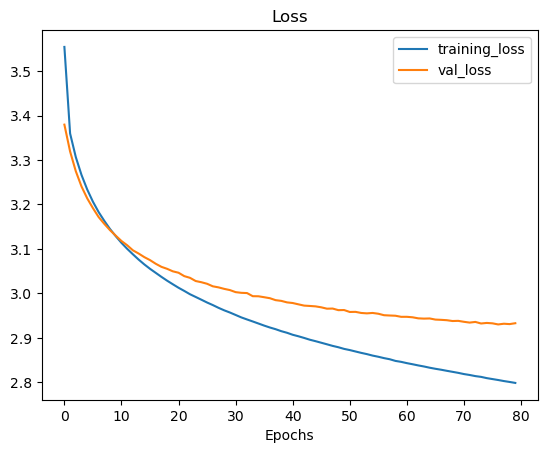

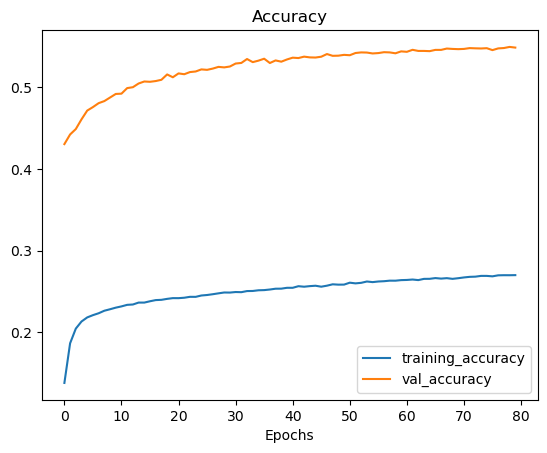

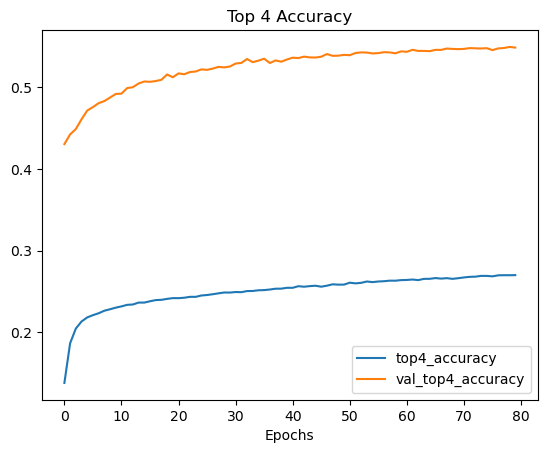

In [27]:
vgg19_1_history_genre = vgg19(vgg19_1_config)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_1 (Dense)             (None, 95)                48735     
                                                                 
 activation_1 (Activation)   (None, 95)                0         
                                                                 
Total params: 20073119 (76.57 MB)
Trainable params: 20073119 (76.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0628 - accuracy: 0.2339 - top_2_accuracy: 0.3754 - top_3_accuracy: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1084s 1s/step - loss: 3.0628 - accuracy: 0.2339 - top_2_accuracy: 0.3754 - top_3_accuracy: 0.4581 - top_4_accuracy: 0.5236 - ROC-AUC: 0.8910 - PR-AUC: 0.1797 - tp: 1129.0000 - fp: 796.0000 - tn: 4155508.0000 - fn: 43087.0000 - precision: 0.5865 - recall: 0.0255 - f1_score: 0.0255 - val_loss: 2.9092 - val_accuracy: 0.2573 - val_top_2_accuracy: 0.3982 - val_top_3_accuracy: 0.4805 - val_top_4_accuracy: 0.5468 - val_ROC-AUC: 0.9053 - val_PR-AUC: 0.2046 - val_tp: 275.0000 - val_fp: 131.0000 - val_tn: 1033681.0000 - val_fn: 10723.0000 - val_precision: 0.6773 - val_recall: 0.0250 - val_f1_score: 0.0286 - lr: 1.0000e-04
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8575 - accuracy: 0.2654 - top_2_accuracy: 0.4085 - top_3_accuracy: 0.4988 - top_4_accuracy: 0.5651 - ROC-AUC: 0.9064 - PR-AUC: 0.2116 - tp: 1250.0000 - fp: 825.0000 - tn: 3117061.0000 - fn: 31919.0000 - precision: 0.6024 - recall: 0.0377 - f1_score: 0.0331INFO

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1077s 1s/step - loss: 2.8575 - accuracy: 0.2654 - top_2_accuracy: 0.4085 - top_3_accuracy: 0.4988 - top_4_accuracy: 0.5651 - ROC-AUC: 0.9064 - PR-AUC: 0.2116 - tp: 1250.0000 - fp: 825.0000 - tn: 3117061.0000 - fn: 31919.0000 - precision: 0.6024 - recall: 0.0377 - f1_score: 0.0331 - val_loss: 2.8139 - val_accuracy: 0.2741 - val_top_2_accuracy: 0.4209 - val_top_3_accuracy: 0.5065 - val_top_4_accuracy: 0.5757 - val_ROC-AUC: 0.9081 - val_PR-AUC: 0.2219 - val_tp: 499.0000 - val_fp: 277.0000 - val_tn: 1033535.0000 - val_fn: 10499.0000 - val_precision: 0.6430 - val_recall: 0.0454 - val_f1_score: 0.0349 - lr: 1.0000e-04
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7784 - accuracy: 0.2835 - top_2_accuracy: 0.4274 - top_3_accuracy: 0.5172 - top_4_accuracy: 0.5819 - ROC-AUC: 0.9112 - PR-AUC: 0.2315 - tp: 1661.0000 - fp: 995.0000 - tn: 3116891.0000 - fn: 31508.0000 - precision: 0.6254 - recall: 0.0501 - f1_score: 0.0410INFO

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1077s 1s/step - loss: 2.7784 - accuracy: 0.2835 - top_2_accuracy: 0.4274 - top_3_accuracy: 0.5172 - top_4_accuracy: 0.5819 - ROC-AUC: 0.9112 - PR-AUC: 0.2315 - tp: 1661.0000 - fp: 995.0000 - tn: 3116891.0000 - fn: 31508.0000 - precision: 0.6254 - recall: 0.0501 - f1_score: 0.0410 - val_loss: 2.7779 - val_accuracy: 0.2819 - val_top_2_accuracy: 0.4243 - val_top_3_accuracy: 0.5168 - val_top_4_accuracy: 0.5850 - val_ROC-AUC: 0.9140 - val_PR-AUC: 0.2315 - val_tp: 338.0000 - val_fp: 140.0000 - val_tn: 1033672.0000 - val_fn: 10660.0000 - val_precision: 0.7071 - val_recall: 0.0307 - val_f1_score: 0.0384 - lr: 1.0000e-04
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7156 - accuracy: 0.2967 - top_2_accuracy: 0.4398 - top_3_accuracy: 0.5312 - top_4_accuracy: 0.5957 - ROC-AUC: 0.9157 - PR-AUC: 0.2486 - tp: 1993.0000 - fp: 1103.0000 - tn: 3116783.0000 - fn: 31176.0000 - precision: 0.6437 - recall: 0.0601 - f1_score: 0.0477INF

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1077s 1s/step - loss: 2.7156 - accuracy: 0.2967 - top_2_accuracy: 0.4398 - top_3_accuracy: 0.5312 - top_4_accuracy: 0.5957 - ROC-AUC: 0.9157 - PR-AUC: 0.2486 - tp: 1993.0000 - fp: 1103.0000 - tn: 3116783.0000 - fn: 31176.0000 - precision: 0.6437 - recall: 0.0601 - f1_score: 0.0477 - val_loss: 2.7569 - val_accuracy: 0.2853 - val_top_2_accuracy: 0.4282 - val_top_3_accuracy: 0.5225 - val_top_4_accuracy: 0.5914 - val_ROC-AUC: 0.9154 - val_PR-AUC: 0.2395 - val_tp: 449.0000 - val_fp: 197.0000 - val_tn: 1033615.0000 - val_fn: 10549.0000 - val_precision: 0.6950 - val_recall: 0.0408 - val_f1_score: 0.0475 - lr: 1.0000e-04
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6601 - accuracy: 0.3082 - top_2_accuracy: 0.4527 - top_3_accuracy: 0.5459 - top_4_accuracy: 0.6086 - ROC-AUC: 0.9196 - PR-AUC: 0.2634 - tp: 2253.0000 - fp: 1268.0000 - tn: 3116618.0000 - fn: 30916.0000 - precision: 0.6399 - recall: 0.0679 - f1_score: 0.0532IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1077s 1s/step - loss: 2.6601 - accuracy: 0.3082 - top_2_accuracy: 0.4527 - top_3_accuracy: 0.5459 - top_4_accuracy: 0.6086 - ROC-AUC: 0.9196 - PR-AUC: 0.2634 - tp: 2253.0000 - fp: 1268.0000 - tn: 3116618.0000 - fn: 30916.0000 - precision: 0.6399 - recall: 0.0679 - f1_score: 0.0532 - val_loss: 2.6957 - val_accuracy: 0.2973 - val_top_2_accuracy: 0.4496 - val_top_3_accuracy: 0.5393 - val_top_4_accuracy: 0.6049 - val_ROC-AUC: 0.9155 - val_PR-AUC: 0.2542 - val_tp: 814.0000 - val_fp: 536.0000 - val_tn: 1033276.0000 - val_fn: 10184.0000 - val_precision: 0.6030 - val_recall: 0.0740 - val_f1_score: 0.0556 - lr: 1.0000e-04
Epoch 6/100
1037/1037 [==============================] - ETA: 0s - loss: 2.5963 - accuracy: 0.3169 - top_2_accuracy: 0.4648 - top_3_accuracy: 0.5585 - top_4_accuracy: 0.6247 - ROC-AUC: 0.9241 - PR-AUC: 0.2781 - tp: 2646.0000 - fp: 1409.0000 - tn: 3116477.0000 - fn: 30523.0000 - precision: 0.6525 - recall: 0.0798 - f1_score: 0.0636IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1079s 1s/step - loss: 2.5963 - accuracy: 0.3169 - top_2_accuracy: 0.4648 - top_3_accuracy: 0.5585 - top_4_accuracy: 0.6247 - ROC-AUC: 0.9241 - PR-AUC: 0.2781 - tp: 2646.0000 - fp: 1409.0000 - tn: 3116477.0000 - fn: 30523.0000 - precision: 0.6525 - recall: 0.0798 - f1_score: 0.0636 - val_loss: 2.6927 - val_accuracy: 0.3026 - val_top_2_accuracy: 0.4493 - val_top_3_accuracy: 0.5406 - val_top_4_accuracy: 0.6052 - val_ROC-AUC: 0.9151 - val_PR-AUC: 0.2619 - val_tp: 826.0000 - val_fp: 490.0000 - val_tn: 1033322.0000 - val_fn: 10172.0000 - val_precision: 0.6277 - val_recall: 0.0751 - val_f1_score: 0.0537 - lr: 1.0000e-04
Epoch 7/100
1037/1037 [==============================] - 1076s 1s/step - loss: 2.5270 - accuracy: 0.3310 - top_2_accuracy: 0.4809 - top_3_accuracy: 0.5731 - top_4_accuracy: 0.6389 - ROC-AUC: 0.9279 - PR-AUC: 0.2985 - tp: 3030.0000 - fp: 1617.0000 - tn: 3116269.0000 - fn: 30139.0000 - precision: 0.6520 - recall: 0.0914 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1077s 1s/step - loss: 2.4478 - accuracy: 0.3472 - top_2_accuracy: 0.4985 - top_3_accuracy: 0.5936 - top_4_accuracy: 0.6578 - ROC-AUC: 0.9326 - PR-AUC: 0.3196 - tp: 3600.0000 - fp: 1802.0000 - tn: 3116084.0000 - fn: 29569.0000 - precision: 0.6664 - recall: 0.1085 - f1_score: 0.0870 - val_loss: 2.6857 - val_accuracy: 0.3025 - val_top_2_accuracy: 0.4519 - val_top_3_accuracy: 0.5460 - val_top_4_accuracy: 0.6107 - val_ROC-AUC: 0.9159 - val_PR-AUC: 0.2606 - val_tp: 871.0000 - val_fp: 595.0000 - val_tn: 1033217.0000 - val_fn: 10127.0000 - val_precision: 0.5941 - val_recall: 0.0792 - val_f1_score: 0.0622 - lr: 1.0000e-04
Epoch 9/100
1037/1037 [==============================] - 1074s 1s/step - loss: 2.3476 - accuracy: 0.3667 - top_2_accuracy: 0.5221 - top_3_accuracy: 0.6139 - top_4_accuracy: 0.6773 - ROC-AUC: 0.9386 - PR-AUC: 0.3505 - tp: 4359.0000 - fp: 2054.0000 - tn: 3115832.0000 - fn: 28810.0000 - precision: 0.6797 - recall: 0.1314 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_1_TL_FT/assets


344/344 [==============================] - 88s 256ms/step - loss: 2.9824 - accuracy: 0.2968 - top_2_accuracy: 0.4376 - top_3_accuracy: 0.5251 - top_4_accuracy: 0.5858 - ROC-AUC: 0.8857 - PR-AUC: 0.2521 - tp: 1791.0000 - fp: 2161.0000 - tn: 1031651.0000 - fn: 9207.0000 - precision: 0.4532 - recall: 0.1628 - f1_score: 0.1044
VALID:
 [2.9823970794677734, 0.2967812418937683, 0.4376250207424164, 0.5250954627990723, 0.5858337879180908, 0.8857195377349854, 0.2520541548728943, 1791.0, 2161.0, 1031651.0, 9207.0, 0.4531882703304291, 0.16284778714179993, 0.10437947511672974]
346/346 [==============================] - 89s 258ms/step - loss: 2.9851 - accuracy: 0.2947 - top_2_accuracy: 0.4384 - top_3_accuracy: 0.5262 - top_4_accuracy: 0.5900 - ROC-AUC: 0.8867 - PR-AUC: 0.2480 - tp: 1786.0000 - fp: 2201.0000 - tn: 1036217.0000 - fn: 9261.0000 - precision: 0.4480 - recall: 0.1617 - f1_score: 0.1082
TEST:
 [2.985135555267334, 0.294650137424469, 0.4383995532989502, 0.5262061953544617, 0.5900244116783142

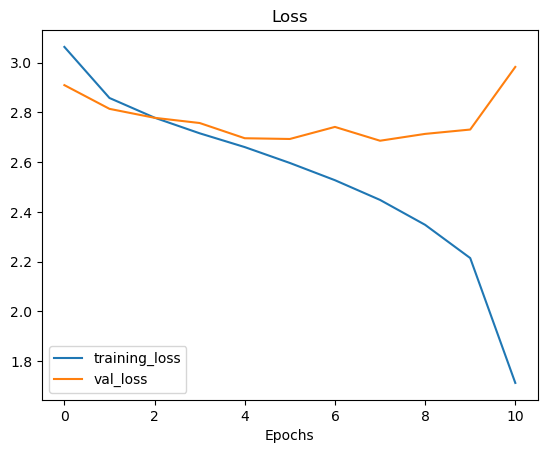

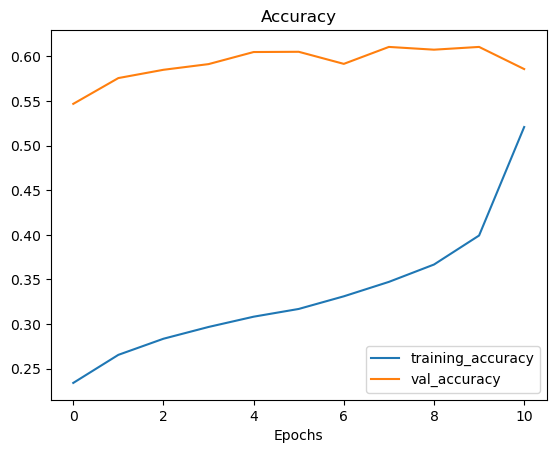

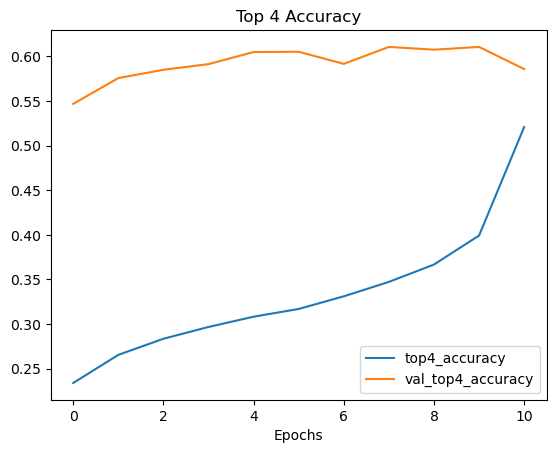

In [28]:
vgg19_1_history_genre_ft = fine_tune(vgg19_1_config)

### Genre | VGG19 | Learning from scratch

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1099s 1s/step - loss: 3.3494 - accuracy: 0.1810 - top_2_accuracy: 0.3501 - top_3_accuracy: 0.4271 - top_4_accuracy: 0.4882 - ROC-AUC: 0.8731 - PR-AUC: 0.1676 - tp: 2019.0000 - fp: 2081.0000 - tn: 4154223.0000 - fn: 42197.0000 - precision: 0.4924 - recall: 0.0457 - f1_score: 0.0482 - val_loss: 3.1966 - val_accuracy: 0.2049 - val_top_2_accuracy: 0.3346 - val_top_3_accuracy: 0.4100 - val_top_4_accuracy: 0.4715 - val_ROC-AUC: 0.8750 - val_PR-AUC: 0.1543 - val_tp: 380.0000 - val_fp: 434.0000 - val_tn: 1033378.0000 - val_fn: 10618.0000 - val_precision: 0.4668 - val_recall: 0.0346 - val_f1_score: 0.0106
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1265 - accuracy: 0.2210 - top_2_accuracy: 0.3535 - top_3_accuracy: 0.4299 - top_4_accuracy: 0.4939 - ROC-AUC: 0.8835 - PR-AUC: 0.1602 - tp: 497.0000 - fp: 411.0000 - tn: 3117475.0000 - fn: 32672.0000 - precision: 0.5474 - recall: 0.0150 - f1_score: 0.0170INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1080s 1s/step - loss: 3.1265 - accuracy: 0.2210 - top_2_accuracy: 0.3535 - top_3_accuracy: 0.4299 - top_4_accuracy: 0.4939 - ROC-AUC: 0.8835 - PR-AUC: 0.1602 - tp: 497.0000 - fp: 411.0000 - tn: 3117475.0000 - fn: 32672.0000 - precision: 0.5474 - recall: 0.0150 - f1_score: 0.0170 - val_loss: 3.0139 - val_accuracy: 0.2396 - val_top_2_accuracy: 0.3780 - val_top_3_accuracy: 0.4559 - val_top_4_accuracy: 0.5151 - val_ROC-AUC: 0.8934 - val_PR-AUC: 0.1850 - val_tp: 385.0000 - val_fp: 268.0000 - val_tn: 1033544.0000 - val_fn: 10613.0000 - val_precision: 0.5896 - val_recall: 0.0350 - val_f1_score: 0.0188
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0139 - accuracy: 0.2407 - top_2_accuracy: 0.3777 - top_3_accuracy: 0.4560 - top_4_accuracy: 0.5218 - ROC-AUC: 0.8942 - PR-AUC: 0.1832 - tp: 938.0000 - fp: 632.0000 - tn: 3117254.0000 - fn: 32231.0000 - precision: 0.5975 - recall: 0.0283 - f1_score: 0.0208INFO:tensorflow:Assets 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1079s 1s/step - loss: 3.0139 - accuracy: 0.2407 - top_2_accuracy: 0.3777 - top_3_accuracy: 0.4560 - top_4_accuracy: 0.5218 - ROC-AUC: 0.8942 - PR-AUC: 0.1832 - tp: 938.0000 - fp: 632.0000 - tn: 3117254.0000 - fn: 32231.0000 - precision: 0.5975 - recall: 0.0283 - f1_score: 0.0208 - val_loss: 2.9814 - val_accuracy: 0.2459 - val_top_2_accuracy: 0.3838 - val_top_3_accuracy: 0.4681 - val_top_4_accuracy: 0.5359 - val_ROC-AUC: 0.9010 - val_PR-AUC: 0.1914 - val_tp: 177.0000 - val_fp: 57.0000 - val_tn: 1033755.0000 - val_fn: 10821.0000 - val_precision: 0.7564 - val_recall: 0.0161 - val_f1_score: 0.0223
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9376 - accuracy: 0.2524 - top_2_accuracy: 0.3902 - top_3_accuracy: 0.4746 - top_4_accuracy: 0.5429 - ROC-AUC: 0.9008 - PR-AUC: 0.1986 - tp: 1229.0000 - fp: 776.0000 - tn: 3117110.0000 - fn: 31940.0000 - precision: 0.6130 - recall: 0.0371 - f1_score: 0.0257INFO:tensorflow:Assets 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1079s 1s/step - loss: 2.9376 - accuracy: 0.2524 - top_2_accuracy: 0.3902 - top_3_accuracy: 0.4746 - top_4_accuracy: 0.5429 - ROC-AUC: 0.9008 - PR-AUC: 0.1986 - tp: 1229.0000 - fp: 776.0000 - tn: 3117110.0000 - fn: 31940.0000 - precision: 0.6130 - recall: 0.0371 - f1_score: 0.0257 - val_loss: 2.9317 - val_accuracy: 0.2554 - val_top_2_accuracy: 0.3966 - val_top_3_accuracy: 0.4763 - val_top_4_accuracy: 0.5410 - val_ROC-AUC: 0.9004 - val_PR-AUC: 0.1927 - val_tp: 92.0000 - val_fp: 30.0000 - val_tn: 1033782.0000 - val_fn: 10906.0000 - val_precision: 0.7541 - val_recall: 0.0084 - val_f1_score: 0.0264
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8747 - accuracy: 0.2614 - top_2_accuracy: 0.4048 - top_3_accuracy: 0.4896 - top_4_accuracy: 0.5553 - ROC-AUC: 0.9058 - PR-AUC: 0.2102 - tp: 1375.0000 - fp: 841.0000 - tn: 3117045.0000 - fn: 31794.0000 - precision: 0.6205 - recall: 0.0415 - f1_score: 0.0298INFO:tensorflow:Assets 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1079s 1s/step - loss: 2.8747 - accuracy: 0.2614 - top_2_accuracy: 0.4048 - top_3_accuracy: 0.4896 - top_4_accuracy: 0.5553 - ROC-AUC: 0.9058 - PR-AUC: 0.2102 - tp: 1375.0000 - fp: 841.0000 - tn: 3117045.0000 - fn: 31794.0000 - precision: 0.6205 - recall: 0.0415 - f1_score: 0.0298 - val_loss: 2.8706 - val_accuracy: 0.2702 - val_top_2_accuracy: 0.4070 - val_top_3_accuracy: 0.4915 - val_top_4_accuracy: 0.5599 - val_ROC-AUC: 0.9026 - val_PR-AUC: 0.2146 - val_tp: 540.0000 - val_fp: 356.0000 - val_tn: 1033456.0000 - val_fn: 10458.0000 - val_precision: 0.6027 - val_recall: 0.0491 - val_f1_score: 0.0308
Epoch 6/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8125 - accuracy: 0.2770 - top_2_accuracy: 0.4178 - top_3_accuracy: 0.5058 - top_4_accuracy: 0.5703 - ROC-AUC: 0.9099 - PR-AUC: 0.2244 - tp: 1631.0000 - fp: 940.0000 - tn: 3116946.0000 - fn: 31538.0000 - precision: 0.6344 - recall: 0.0492 - f1_score: 0.0361INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1078s 1s/step - loss: 2.8125 - accuracy: 0.2770 - top_2_accuracy: 0.4178 - top_3_accuracy: 0.5058 - top_4_accuracy: 0.5703 - ROC-AUC: 0.9099 - PR-AUC: 0.2244 - tp: 1631.0000 - fp: 940.0000 - tn: 3116946.0000 - fn: 31538.0000 - precision: 0.6344 - recall: 0.0492 - f1_score: 0.0361 - val_loss: 2.8636 - val_accuracy: 0.2659 - val_top_2_accuracy: 0.4002 - val_top_3_accuracy: 0.4918 - val_top_4_accuracy: 0.5554 - val_ROC-AUC: 0.9065 - val_PR-AUC: 0.2136 - val_tp: 275.0000 - val_fp: 100.0000 - val_tn: 1033712.0000 - val_fn: 10723.0000 - val_precision: 0.7333 - val_recall: 0.0250 - val_f1_score: 0.0367
Epoch 7/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7656 - accuracy: 0.2826 - top_2_accuracy: 0.4277 - top_3_accuracy: 0.5171 - top_4_accuracy: 0.5837 - ROC-AUC: 0.9134 - PR-AUC: 0.2350 - tp: 1801.0000 - fp: 1007.0000 - tn: 3116879.0000 - fn: 31368.0000 - precision: 0.6414 - recall: 0.0543 - f1_score: 0.0404INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1078s 1s/step - loss: 2.7656 - accuracy: 0.2826 - top_2_accuracy: 0.4277 - top_3_accuracy: 0.5171 - top_4_accuracy: 0.5837 - ROC-AUC: 0.9134 - PR-AUC: 0.2350 - tp: 1801.0000 - fp: 1007.0000 - tn: 3116879.0000 - fn: 31368.0000 - precision: 0.6414 - recall: 0.0543 - f1_score: 0.0404 - val_loss: 2.7994 - val_accuracy: 0.2807 - val_top_2_accuracy: 0.4213 - val_top_3_accuracy: 0.5067 - val_top_4_accuracy: 0.5738 - val_ROC-AUC: 0.9091 - val_PR-AUC: 0.2285 - val_tp: 424.0000 - val_fp: 213.0000 - val_tn: 1033599.0000 - val_fn: 10574.0000 - val_precision: 0.6656 - val_recall: 0.0386 - val_f1_score: 0.0380
Epoch 8/100
1037/1037 [==============================] - 1077s 1s/step - loss: 2.7185 - accuracy: 0.2899 - top_2_accuracy: 0.4372 - top_3_accuracy: 0.5279 - top_4_accuracy: 0.5953 - ROC-AUC: 0.9166 - PR-AUC: 0.2453 - tp: 1927.0000 - fp: 1097.0000 - tn: 3116789.0000 - fn: 31242.0000 - precision: 0.6372 - recall: 0.0581 - f1_score: 0.0454 - val_loss: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1086s 1s/step - loss: 2.6656 - accuracy: 0.3003 - top_2_accuracy: 0.4472 - top_3_accuracy: 0.5411 - top_4_accuracy: 0.6067 - ROC-AUC: 0.9202 - PR-AUC: 0.2578 - tp: 2172.0000 - fp: 1236.0000 - tn: 3116650.0000 - fn: 30997.0000 - precision: 0.6373 - recall: 0.0655 - f1_score: 0.0521 - val_loss: 2.7473 - val_accuracy: 0.2870 - val_top_2_accuracy: 0.4334 - val_top_3_accuracy: 0.5258 - val_top_4_accuracy: 0.5935 - val_ROC-AUC: 0.9123 - val_PR-AUC: 0.2414 - val_tp: 521.0000 - val_fp: 281.0000 - val_tn: 1033531.0000 - val_fn: 10477.0000 - val_precision: 0.6496 - val_recall: 0.0474 - val_f1_score: 0.0501
Epoch 10/100
1037/1037 [==============================] - 1077s 1s/step - loss: 2.6118 - accuracy: 0.3112 - top_2_accuracy: 0.4609 - top_3_accuracy: 0.5531 - top_4_accuracy: 0.6198 - ROC-AUC: 0.9233 - PR-AUC: 0.2723 - tp: 2446.0000 - fp: 1393.0000 - tn: 3116493.0000 - fn: 30723.0000 - precision: 0.6371 - recall: 0.0737 - f1_score: 0.0614 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1078s 1s/step - loss: 2.5524 - accuracy: 0.3229 - top_2_accuracy: 0.4725 - top_3_accuracy: 0.5652 - top_4_accuracy: 0.6332 - ROC-AUC: 0.9280 - PR-AUC: 0.2882 - tp: 2822.0000 - fp: 1482.0000 - tn: 3116404.0000 - fn: 30347.0000 - precision: 0.6557 - recall: 0.0851 - f1_score: 0.0721 - val_loss: 2.7405 - val_accuracy: 0.2790 - val_top_2_accuracy: 0.4366 - val_top_3_accuracy: 0.5307 - val_top_4_accuracy: 0.5967 - val_ROC-AUC: 0.9142 - val_PR-AUC: 0.2402 - val_tp: 629.0000 - val_fp: 391.0000 - val_tn: 1033421.0000 - val_fn: 10369.0000 - val_precision: 0.6167 - val_recall: 0.0572 - val_f1_score: 0.0538
Epoch 12/100
1037/1037 [==============================] - 1077s 1s/step - loss: 2.4833 - accuracy: 0.3384 - top_2_accuracy: 0.4906 - top_3_accuracy: 0.5833 - top_4_accuracy: 0.6481 - ROC-AUC: 0.9310 - PR-AUC: 0.3082 - tp: 3262.0000 - fp: 1666.0000 - tn: 3116220.0000 - fn: 29907.0000 - precision: 0.6619 - recall: 0.0983 - f1_score: 0.0863 - val_loss:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/VGG19_2/assets


344/344 [==============================] - 89s 258ms/step - loss: 2.8229 - accuracy: 0.2820 - top_2_accuracy: 0.4301 - top_3_accuracy: 0.5230 - top_4_accuracy: 0.5866 - ROC-AUC: 0.9013 - PR-AUC: 0.2383 - tp: 1201.0000 - fp: 1295.0000 - tn: 1032517.0000 - fn: 9797.0000 - precision: 0.4812 - recall: 0.1092 - f1_score: 0.0707
VALID:
 [2.822944402694702, 0.2819603681564331, 0.4300782084465027, 0.5230041742324829, 0.5865612030029297, 0.9013442993164062, 0.23831838369369507, 1201.0, 1295.0, 1032517.0, 9797.0, 0.4811698794364929, 0.10920166969299316, 0.07069414108991623]
346/346 [==============================] - 90s 260ms/step - loss: 2.8237 - accuracy: 0.2837 - top_2_accuracy: 0.4319 - top_3_accuracy: 0.5232 - top_4_accuracy: 0.5847 - ROC-AUC: 0.9009 - PR-AUC: 0.2387 - tp: 1206.0000 - fp: 1306.0000 - tn: 1037112.0000 - fn: 9841.0000 - precision: 0.4801 - recall: 0.1092 - f1_score: 0.0721
TEST:
 [2.8237123489379883, 0.2836969196796417, 0.43188196420669556, 0.5232189893722534, 0.5846835970878

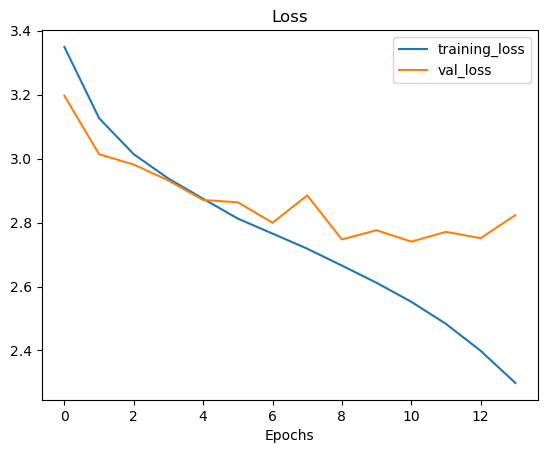

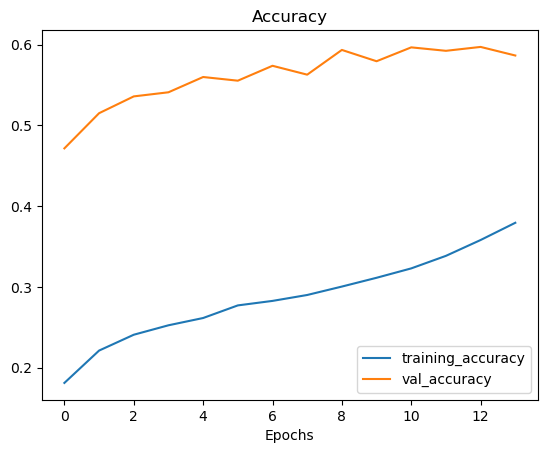

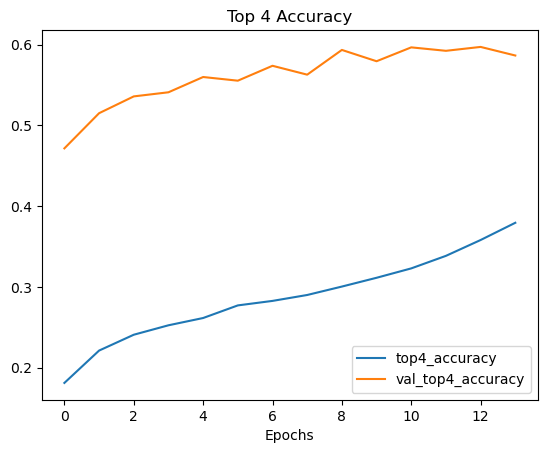

In [34]:
vgg19_2_history_genre = vgg19(vgg19_2_config)

## Genre | EfficientNetB0
### Genre | EfficientNetB0 | Transfer Learning

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 block3b_expand_activation   (None, None, None, 192)      0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_project_conv (Conv  (None, None, None, 48)       9216      ['block3b_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3b_project_bn (BatchN  (None, None, None, 48)       192       ['block3b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_drop (Dropout)      (None, None, None, 48)       0         ['block3b_project_bn[0][0]']  
          

 2D)                                                                                              
                                                                                                  
 block4b_project_bn (BatchN  (None, None, None, 96)       384       ['block4b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, None, None, 96)       0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, None, None, 96)       0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_e

 block5a_project_conv (Conv  (None, None, None, 112)      64512     ['block5a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5a_project_bn (BatchN  (None, None, None, 112)      448       ['block5a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5b_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block5b_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block5c_drop (Dropout)      (None, None, None, 112)      0         ['block5c_project_bn[0][0]']  
                                                                                                  
 block5c_add (Add)           (None, None, None, 112)      0         ['block5c_drop[0][0]',        
                                                                     'block5b_add[0][0]']         
                                                                                                  
 block5d_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5d_e

 block5e_project_bn (BatchN  (None, None, None, 112)      448       ['block5e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5e_drop (Dropout)      (None, None, None, 112)      0         ['block5e_project_bn[0][0]']  
                                                                                                  
 block5e_add (Add)           (None, None, None, 112)      0         ['block5e_drop[0][0]',        
                                                                     'block5d_add[0][0]']         
                                                                                                  
 block6a_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5e_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block6b_add (Add)           (None, None, None, 192)      0         ['block6b_drop[0][0]',        
                                                                     'block6a_project_bn[0][0]']  
                                                                                                  
 block6c_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6c_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)      (None, None, None, 192)      0         ['block6d_project_bn[0][0]']  
                                                                                                  
 block6d_add (Add)           (None, None, None, 192)      0         ['block6d_drop[0][0]',        
                                                                     'block6c_add[0][0]']         
                                                                                                  
 block6e_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6e_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6f_drop (Dropout)      (None, None, None, 192)      0         ['block6f_project_bn[0][0]']  
                                                                                                  
 block6f_add (Add)           (None, None, None, 192)      0         ['block6f_drop[0][0]',        
                                                                     'block6e_add[0][0]']         
                                                                                                  
 block6g_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6f_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6g_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6g_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block6h_drop (Dropout)      (None, None, None, 192)      0         ['block6h_project_bn[0][0]']  
                                                                                                  
 block6h_add (Add)           (None, None, None, 192)      0         ['block6h_drop[0][0]',        
                                                                     'block6g_add[0][0]']         
                                                                                                  
 top_conv (Conv2D)           (None, None, None, 1280)     245760    ['block6h_add[0][0]']         
                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )        

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 179s 167ms/step - loss: 3.4948 - accuracy: 0.1306 - top_2_accuracy: 0.3056 - top_3_accuracy: 0.3881 - top_4_accuracy: 0.4537 - ROC-AUC: 0.8549 - PR-AUC: 0.1322 - tp: 1786.0000 - fp: 2201.0000 - tn: 4154103.0000 - fn: 42430.0000 - precision: 0.4480 - recall: 0.0404 - f1_score: 0.0422 - val_loss: 3.4561 - val_accuracy: 0.1341 - val_top_2_accuracy: 0.2645 - val_top_3_accuracy: 0.3483 - val_top_4_accuracy: 0.4154 - val_ROC-AUC: 0.8488 - val_PR-AUC: 0.0845 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0025
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 3.4723 - accuracy: 0.1314 - top_2_accuracy: 0.2625 - top_3_accuracy: 0.3446 - top_4_accuracy: 0.4097 - ROC-AUC: 0.8452 - PR-AUC: 0.0830 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 162s 156ms/step - loss: 3.4723 - accuracy: 0.1314 - top_2_accuracy: 0.2625 - top_3_accuracy: 0.3446 - top_4_accuracy: 0.4097 - ROC-AUC: 0.8452 - PR-AUC: 0.0830 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0044 - val_loss: 3.4549 - val_accuracy: 0.1341 - val_top_2_accuracy: 0.2645 - val_top_3_accuracy: 0.3483 - val_top_4_accuracy: 0.4154 - val_ROC-AUC: 0.8457 - val_PR-AUC: 0.0858 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0025
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 3.4716 - accuracy: 0.1315 - top_2_accuracy: 0.2634 - top_3_accuracy: 0.3457 - top_4_accuracy: 0.4112 - ROC-AUC: 0.8454 - PR-AUC: 0.0833 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 160s 154ms/step - loss: 3.4716 - accuracy: 0.1315 - top_2_accuracy: 0.2634 - top_3_accuracy: 0.3457 - top_4_accuracy: 0.4112 - ROC-AUC: 0.8454 - PR-AUC: 0.0833 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0044 - val_loss: 3.4531 - val_accuracy: 0.1301 - val_top_2_accuracy: 0.2645 - val_top_3_accuracy: 0.3483 - val_top_4_accuracy: 0.4158 - val_ROC-AUC: 0.8496 - val_PR-AUC: 0.0851 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0025
Epoch 4/100
1037/1037 [==============================] - 153s 147ms/step - loss: 3.4697 - accuracy: 0.1336 - top_2_accuracy: 0.2631 - top_3_accuracy: 0.3454 - top_4_accuracy: 0.4102 - ROC-AUC: 0.8458 - PR-AUC: 0.0837 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 162s 156ms/step - loss: 3.4688 - accuracy: 0.1330 - top_2_accuracy: 0.2630 - top_3_accuracy: 0.3468 - top_4_accuracy: 0.4117 - ROC-AUC: 0.8457 - PR-AUC: 0.0837 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0045 - val_loss: 3.4528 - val_accuracy: 0.1342 - val_top_2_accuracy: 0.2648 - val_top_3_accuracy: 0.3483 - val_top_4_accuracy: 0.4154 - val_ROC-AUC: 0.8529 - val_PR-AUC: 0.0889 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0025
Epoch 6/100
1037/1037 [==============================] - 152s 146ms/step - loss: 3.4664 - accuracy: 0.1325 - top_2_accuracy: 0.2633 - top_3_accuracy: 0.3468 - top_4_accuracy: 0.4109 - ROC-AUC: 0.8459 - PR-AUC: 0.0840 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 161s 155ms/step - loss: 3.4659 - accuracy: 0.1366 - top_2_accuracy: 0.2638 - top_3_accuracy: 0.3479 - top_4_accuracy: 0.4117 - ROC-AUC: 0.8465 - PR-AUC: 0.0849 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0046 - val_loss: 3.4453 - val_accuracy: 0.1344 - val_top_2_accuracy: 0.2648 - val_top_3_accuracy: 0.3483 - val_top_4_accuracy: 0.4154 - val_ROC-AUC: 0.8470 - val_PR-AUC: 0.0897 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0026
Epoch 8/100
1037/1037 [==============================] - 151s 146ms/step - loss: 3.4639 - accuracy: 0.1356 - top_2_accuracy: 0.2643 - top_3_accuracy: 0.3496 - top_4_accuracy: 0.4112 - ROC-AUC: 0.8464 - PR-AUC: 0.0848 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 161s 155ms/step - loss: 3.4631 - accuracy: 0.1354 - top_2_accuracy: 0.2647 - top_3_accuracy: 0.3498 - top_4_accuracy: 0.4117 - ROC-AUC: 0.8466 - PR-AUC: 0.0856 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0046 - val_loss: 3.4434 - val_accuracy: 0.1344 - val_top_2_accuracy: 0.2648 - val_top_3_accuracy: 0.3555 - val_top_4_accuracy: 0.4154 - val_ROC-AUC: 0.8519 - val_PR-AUC: 0.0910 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0026
Epoch 11/100
1037/1037 [==============================] - 151s 145ms/step - loss: 3.4614 - accuracy: 0.1356 - top_2_accuracy: 0.2647 - top_3_accuracy: 0.3504 - top_4_accuracy: 0.4098 - ROC-AUC: 0.8465 - PR-AUC: 0.0859 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.000

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 160s 155ms/step - loss: 3.4594 - accuracy: 0.1399 - top_2_accuracy: 0.2660 - top_3_accuracy: 0.3495 - top_4_accuracy: 0.4118 - ROC-AUC: 0.8468 - PR-AUC: 0.0867 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0050 - val_loss: 3.4385 - val_accuracy: 0.1346 - val_top_2_accuracy: 0.2647 - val_top_3_accuracy: 0.3659 - val_top_4_accuracy: 0.4154 - val_ROC-AUC: 0.8480 - val_PR-AUC: 0.0920 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0026
Epoch 13/100
1037/1037 [==============================] - 150s 144ms/step - loss: 3.4586 - accuracy: 0.1390 - top_2_accuracy: 0.2652 - top_3_accuracy: 0.3514 - top_4_accuracy: 0.4119 - ROC-AUC: 0.8470 - PR-AUC: 0.0866 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.000

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 162s 156ms/step - loss: 3.4568 - accuracy: 0.1403 - top_2_accuracy: 0.2667 - top_3_accuracy: 0.3516 - top_4_accuracy: 0.4123 - ROC-AUC: 0.8466 - PR-AUC: 0.0875 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0051 - val_loss: 3.4371 - val_accuracy: 0.1455 - val_top_2_accuracy: 0.2647 - val_top_3_accuracy: 0.3652 - val_top_4_accuracy: 0.4158 - val_ROC-AUC: 0.8500 - val_PR-AUC: 0.0940 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0044
Epoch 16/100
1037/1037 [==============================] - 152s 147ms/step - loss: 3.4556 - accuracy: 0.1424 - top_2_accuracy: 0.2680 - top_3_accuracy: 0.3519 - top_4_accuracy: 0.4113 - ROC-AUC: 0.8468 - PR-AUC: 0.0879 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.000

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 162s 156ms/step - loss: 3.4532 - accuracy: 0.1433 - top_2_accuracy: 0.2680 - top_3_accuracy: 0.3531 - top_4_accuracy: 0.4131 - ROC-AUC: 0.8471 - PR-AUC: 0.0885 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3117885.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0053 - val_loss: 3.4368 - val_accuracy: 0.1603 - val_top_2_accuracy: 0.2662 - val_top_3_accuracy: 0.3682 - val_top_4_accuracy: 0.4156 - val_ROC-AUC: 0.8500 - val_PR-AUC: 0.0955 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10997.0000 - val_precision: 1.0000 - val_recall: 9.0926e-05 - val_f1_score: 0.0055
Epoch 19/100
1037/1037 [==============================] - ETA: 0s - loss: 3.4521 - accuracy: 0.1401 - top_2_accuracy: 0.2679 - top_3_accuracy: 0.3547 - top_4_accuracy: 0.4126 - ROC-AUC: 0.8470 - PR-AUC: 0.0892 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 162s 156ms/step - loss: 3.4521 - accuracy: 0.1401 - top_2_accuracy: 0.2679 - top_3_accuracy: 0.3547 - top_4_accuracy: 0.4126 - ROC-AUC: 0.8470 - PR-AUC: 0.0892 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3117886.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0055 - val_loss: 3.4349 - val_accuracy: 0.1627 - val_top_2_accuracy: 0.2650 - val_top_3_accuracy: 0.3680 - val_top_4_accuracy: 0.4189 - val_ROC-AUC: 0.8500 - val_PR-AUC: 0.0965 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10997.0000 - val_precision: 1.0000 - val_recall: 9.0926e-05 - val_f1_score: 0.0055
Epoch 20/100
1037/1037 [==============================] - 151s 145ms/step - loss: 3.4511 - accuracy: 0.1442 - top_2_accuracy: 0.2691 - top_3_accuracy: 0.3539 - top_4_accuracy: 0.4118 - ROC-AUC: 0.8472 - PR-AUC: 0.0892 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3117885.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_s

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 160s 155ms/step - loss: 3.4504 - accuracy: 0.1444 - top_2_accuracy: 0.2697 - top_3_accuracy: 0.3527 - top_4_accuracy: 0.4128 - ROC-AUC: 0.8474 - PR-AUC: 0.0894 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3117885.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0056 - val_loss: 3.4326 - val_accuracy: 0.1472 - val_top_2_accuracy: 0.2650 - val_top_3_accuracy: 0.3678 - val_top_4_accuracy: 0.4158 - val_ROC-AUC: 0.8508 - val_PR-AUC: 0.0950 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10997.0000 - val_precision: 1.0000 - val_recall: 9.0926e-05 - val_f1_score: 0.0046
Epoch 22/100
1037/1037 [==============================] - 151s 145ms/step - loss: 3.4488 - accuracy: 0.1443 - top_2_accuracy: 0.2712 - top_3_accuracy: 0.3540 - top_4_accuracy: 0.4140 - ROC-AUC: 0.8470 - PR-AUC: 0.0898 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3117885.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 161s 155ms/step - loss: 3.4465 - accuracy: 0.1458 - top_2_accuracy: 0.2723 - top_3_accuracy: 0.3553 - top_4_accuracy: 0.4143 - ROC-AUC: 0.8482 - PR-AUC: 0.0906 - tp: 0.0000e+00 - fp: 1.0000 - tn: 3117885.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0059 - val_loss: 3.4290 - val_accuracy: 0.1616 - val_top_2_accuracy: 0.2760 - val_top_3_accuracy: 0.3483 - val_top_4_accuracy: 0.4022 - val_ROC-AUC: 0.8505 - val_PR-AUC: 0.0983 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10997.0000 - val_precision: 1.0000 - val_recall: 9.0926e-05 - val_f1_score: 0.0065
Epoch 25/100
1037/1037 [==============================] - 152s 146ms/step - loss: 3.4457 - accuracy: 0.1472 - top_2_accuracy: 0.2709 - top_3_accuracy: 0.3548 - top_4_accuracy: 0.4133 - ROC-AUC: 0.8480 - PR-AUC: 0.0913 - tp: 0.0000e+00 - fp: 2.0000 - tn: 3117884.0000 - fn: 33169.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL/assets


344/344 [==============================] - 38s 110ms/step - loss: 3.4370 - accuracy: 0.1376 - top_2_accuracy: 0.2889 - top_3_accuracy: 0.3483 - top_4_accuracy: 0.4154 - ROC-AUC: 0.8492 - PR-AUC: 0.0980 - tp: 2.0000 - fp: 2.0000 - tn: 1033810.0000 - fn: 10996.0000 - precision: 0.5000 - recall: 1.8185e-04 - f1_score: 0.0048
VALID:
 [3.4369945526123047, 0.13757047057151794, 0.2888706922531128, 0.3483360707759857, 0.4154391586780548, 0.8492217063903809, 0.09798305481672287, 2.0, 2.0, 1033810.0, 10996.0, 0.5, 0.00018185123917646706, 0.004812153987586498]
346/346 [==============================] - 42s 120ms/step - loss: 3.4475 - accuracy: 0.1362 - top_2_accuracy: 0.2884 - top_3_accuracy: 0.3470 - top_4_accuracy: 0.4140 - ROC-AUC: 0.8477 - PR-AUC: 0.0961 - tp: 0.0000e+00 - fp: 1.0000 - tn: 1038417.0000 - fn: 11047.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0048
TEST:
 [3.447462797164917, 0.13623608648777008, 0.28840407729148865, 0.3469720184803009, 0.41404905915260315, 0.

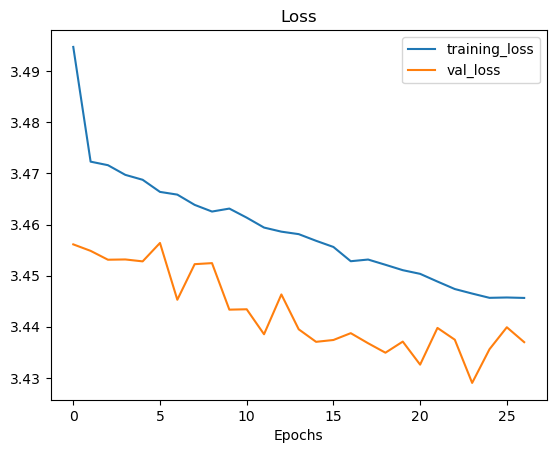

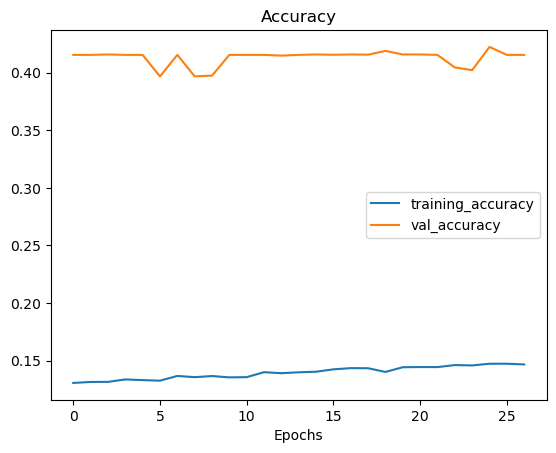

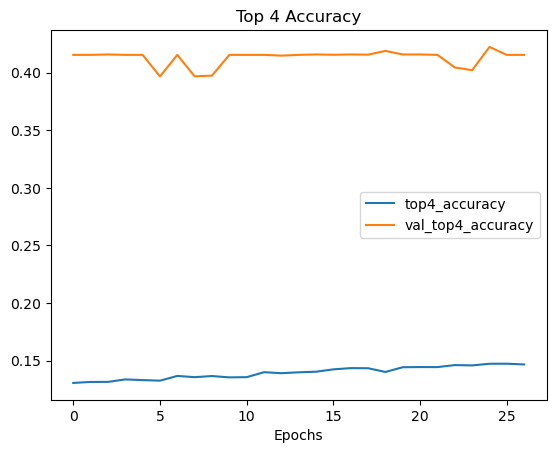

In [29]:
effnet_1_history_genre = effnet(effnet_1_config)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 pooling_layer (GlobalMaxPo  (None, 1280)              0         
 oling2D)                                                        
                                                                 
 dense_2 (Dense)             (None, 95)                121695    
                                                                 
 activation_2 (Activation)   (None, 95)                0         
                                                                 
Total params: 6041007 (23.04 MB)
Trainable params: 5980399 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 385s 353ms/step - loss: 3.5074 - accuracy: 0.1345 - top_2_accuracy: 0.2607 - top_3_accuracy: 0.3397 - top_4_accuracy: 0.4037 - ROC-AUC: 0.8432 - PR-AUC: 0.0845 - tp: 14.0000 - fp: 33.0000 - tn: 4156271.0000 - fn: 44202.0000 - precision: 0.2979 - recall: 3.1663e-04 - f1_score: 0.0059 - val_loss: 3.4618 - val_accuracy: 0.1369 - val_top_2_accuracy: 0.2643 - val_top_3_accuracy: 0.3129 - val_top_4_accuracy: 0.4070 - val_ROC-AUC: 0.8470 - val_PR-AUC: 0.0874 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0030 - lr: 1.0000e-04
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 3.3368 - accuracy: 0.1833 - top_2_accuracy: 0.3083 - top_3_accuracy: 0.3811 - top_4_accuracy: 0.4378 - ROC-AUC: 0.8591 - PR-AUC: 0.1269 - tp: 244.0000 - fp: 208.0000 - tn: 3117678.0000 - fn: 32925.0000 - precision: 0.5398 - recall: 0.0074 - f1_sco

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 333s 320ms/step - loss: 3.3368 - accuracy: 0.1833 - top_2_accuracy: 0.3083 - top_3_accuracy: 0.3811 - top_4_accuracy: 0.4378 - ROC-AUC: 0.8591 - PR-AUC: 0.1269 - tp: 244.0000 - fp: 208.0000 - tn: 3117678.0000 - fn: 32925.0000 - precision: 0.5398 - recall: 0.0074 - f1_score: 0.0102 - val_loss: 3.2005 - val_accuracy: 0.2163 - val_top_2_accuracy: 0.3422 - val_top_3_accuracy: 0.4148 - val_top_4_accuracy: 0.4695 - val_ROC-AUC: 0.8766 - val_PR-AUC: 0.1617 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1033812.0000 - val_fn: 10998.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0139 - lr: 1.0000e-04
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1108 - accuracy: 0.2272 - top_2_accuracy: 0.3566 - top_3_accuracy: 0.4354 - top_4_accuracy: 0.4999 - ROC-AUC: 0.8831 - PR-AUC: 0.1682 - tp: 784.0000 - fp: 558.0000 - tn: 3117328.0000 - fn: 32385.0000 - precision: 0.5842 - recall: 0.0236 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 330s 318ms/step - loss: 3.1108 - accuracy: 0.2272 - top_2_accuracy: 0.3566 - top_3_accuracy: 0.4354 - top_4_accuracy: 0.4999 - ROC-AUC: 0.8831 - PR-AUC: 0.1682 - tp: 784.0000 - fp: 558.0000 - tn: 3117328.0000 - fn: 32385.0000 - precision: 0.5842 - recall: 0.0236 - f1_score: 0.0184 - val_loss: 3.0291 - val_accuracy: 0.2427 - val_top_2_accuracy: 0.3781 - val_top_3_accuracy: 0.4564 - val_top_4_accuracy: 0.5162 - val_ROC-AUC: 0.8898 - val_PR-AUC: 0.1901 - val_tp: 547.0000 - val_fp: 443.0000 - val_tn: 1033369.0000 - val_fn: 10451.0000 - val_precision: 0.5525 - val_recall: 0.0497 - val_f1_score: 0.0213 - lr: 1.0000e-04
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9903 - accuracy: 0.2431 - top_2_accuracy: 0.3790 - top_3_accuracy: 0.4639 - top_4_accuracy: 0.5301 - ROC-AUC: 0.8942 - PR-AUC: 0.1910 - tp: 1186.0000 - fp: 710.0000 - tn: 3117176.0000 - fn: 31983.0000 - precision: 0.6255 - recall: 0.0358 - f1_score: 0.0258INF

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 333s 320ms/step - loss: 2.9903 - accuracy: 0.2431 - top_2_accuracy: 0.3790 - top_3_accuracy: 0.4639 - top_4_accuracy: 0.5301 - ROC-AUC: 0.8942 - PR-AUC: 0.1910 - tp: 1186.0000 - fp: 710.0000 - tn: 3117176.0000 - fn: 31983.0000 - precision: 0.6255 - recall: 0.0358 - f1_score: 0.0258 - val_loss: 2.9664 - val_accuracy: 0.2505 - val_top_2_accuracy: 0.3911 - val_top_3_accuracy: 0.4765 - val_top_4_accuracy: 0.5458 - val_ROC-AUC: 0.8941 - val_PR-AUC: 0.1998 - val_tp: 453.0000 - val_fp: 278.0000 - val_tn: 1033534.0000 - val_fn: 10545.0000 - val_precision: 0.6197 - val_recall: 0.0412 - val_f1_score: 0.0279 - lr: 1.0000e-04
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9187 - accuracy: 0.2562 - top_2_accuracy: 0.3911 - top_3_accuracy: 0.4793 - top_4_accuracy: 0.5467 - ROC-AUC: 0.8997 - PR-AUC: 0.2043 - tp: 1344.0000 - fp: 826.0000 - tn: 3117060.0000 - fn: 31825.0000 - precision: 0.6194 - recall: 0.0405 - f1_score: 0.0332IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 330s 318ms/step - loss: 2.9187 - accuracy: 0.2562 - top_2_accuracy: 0.3911 - top_3_accuracy: 0.4793 - top_4_accuracy: 0.5467 - ROC-AUC: 0.8997 - PR-AUC: 0.2043 - tp: 1344.0000 - fp: 826.0000 - tn: 3117060.0000 - fn: 31825.0000 - precision: 0.6194 - recall: 0.0405 - f1_score: 0.0332 - val_loss: 2.9300 - val_accuracy: 0.2481 - val_top_2_accuracy: 0.3928 - val_top_3_accuracy: 0.4798 - val_top_4_accuracy: 0.5439 - val_ROC-AUC: 0.9020 - val_PR-AUC: 0.2005 - val_tp: 466.0000 - val_fp: 337.0000 - val_tn: 1033475.0000 - val_fn: 10532.0000 - val_precision: 0.5803 - val_recall: 0.0424 - val_f1_score: 0.0286 - lr: 1.0000e-04
Epoch 6/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8511 - accuracy: 0.2671 - top_2_accuracy: 0.4065 - top_3_accuracy: 0.4942 - top_4_accuracy: 0.5615 - ROC-AUC: 0.9053 - PR-AUC: 0.2185 - tp: 1504.0000 - fp: 895.0000 - tn: 3116991.0000 - fn: 31665.0000 - precision: 0.6269 - recall: 0.0453 - f1_score: 0.0403IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 333s 320ms/step - loss: 2.8511 - accuracy: 0.2671 - top_2_accuracy: 0.4065 - top_3_accuracy: 0.4942 - top_4_accuracy: 0.5615 - ROC-AUC: 0.9053 - PR-AUC: 0.2185 - tp: 1504.0000 - fp: 895.0000 - tn: 3116991.0000 - fn: 31665.0000 - precision: 0.6269 - recall: 0.0453 - f1_score: 0.0403 - val_loss: 2.8990 - val_accuracy: 0.2629 - val_top_2_accuracy: 0.4024 - val_top_3_accuracy: 0.4875 - val_top_4_accuracy: 0.5515 - val_ROC-AUC: 0.9038 - val_PR-AUC: 0.2111 - val_tp: 411.0000 - val_fp: 214.0000 - val_tn: 1033598.0000 - val_fn: 10587.0000 - val_precision: 0.6576 - val_recall: 0.0374 - val_f1_score: 0.0373 - lr: 1.0000e-04
Epoch 7/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7828 - accuracy: 0.2771 - top_2_accuracy: 0.4214 - top_3_accuracy: 0.5115 - top_4_accuracy: 0.5793 - ROC-AUC: 0.9106 - PR-AUC: 0.2336 - tp: 1775.0000 - fp: 996.0000 - tn: 3116890.0000 - fn: 31394.0000 - precision: 0.6406 - recall: 0.0535 - f1_score: 0.0463IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 330s 317ms/step - loss: 2.7828 - accuracy: 0.2771 - top_2_accuracy: 0.4214 - top_3_accuracy: 0.5115 - top_4_accuracy: 0.5793 - ROC-AUC: 0.9106 - PR-AUC: 0.2336 - tp: 1775.0000 - fp: 996.0000 - tn: 3116890.0000 - fn: 31394.0000 - precision: 0.6406 - recall: 0.0535 - f1_score: 0.0463 - val_loss: 2.8660 - val_accuracy: 0.2660 - val_top_2_accuracy: 0.4108 - val_top_3_accuracy: 0.4982 - val_top_4_accuracy: 0.5615 - val_ROC-AUC: 0.9008 - val_PR-AUC: 0.2170 - val_tp: 517.0000 - val_fp: 314.0000 - val_tn: 1033498.0000 - val_fn: 10481.0000 - val_precision: 0.6221 - val_recall: 0.0470 - val_f1_score: 0.0421 - lr: 1.0000e-04
Epoch 8/100
1037/1037 [==============================] - 319s 307ms/step - loss: 2.6908 - accuracy: 0.2949 - top_2_accuracy: 0.4422 - top_3_accuracy: 0.5306 - top_4_accuracy: 0.5982 - ROC-AUC: 0.9173 - PR-AUC: 0.2567 - tp: 2177.0000 - fp: 1168.0000 - tn: 3116718.0000 - fn: 30992.0000 - precision: 0.6508 - recall: 0.0656 - f1_score:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_1_TL_FT/assets


344/344 [==============================] - 38s 110ms/step - loss: 2.9220 - accuracy: 0.2685 - top_2_accuracy: 0.4053 - top_3_accuracy: 0.4972 - top_4_accuracy: 0.5604 - ROC-AUC: 0.8933 - PR-AUC: 0.2183 - tp: 918.0000 - fp: 891.0000 - tn: 1032921.0000 - fn: 10080.0000 - precision: 0.5075 - recall: 0.0835 - f1_score: 0.0736
VALID:
 [2.9219930171966553, 0.2685033679008484, 0.40534642338752747, 0.4971812963485718, 0.5603746175765991, 0.8932843208312988, 0.21825946867465973, 918.0, 891.0, 1032921.0, 10080.0, 0.5074626803398132, 0.08346971869468689, 0.07363634556531906]
346/346 [==============================] - 41s 118ms/step - loss: 2.9190 - accuracy: 0.2652 - top_2_accuracy: 0.4040 - top_3_accuracy: 0.5009 - top_4_accuracy: 0.5682 - ROC-AUC: 0.8932 - PR-AUC: 0.2165 - tp: 913.0000 - fp: 953.0000 - tn: 1037465.0000 - fn: 10134.0000 - precision: 0.4893 - recall: 0.0826 - f1_score: 0.0673
TEST:
 [2.919039487838745, 0.2652303874492645, 0.4040010869503021, 0.5008599758148193, 0.5682085752487183

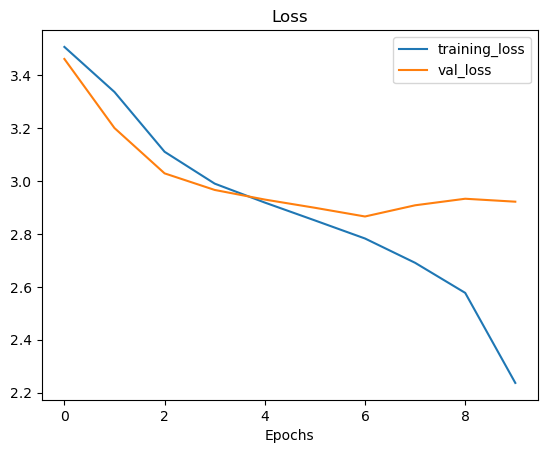

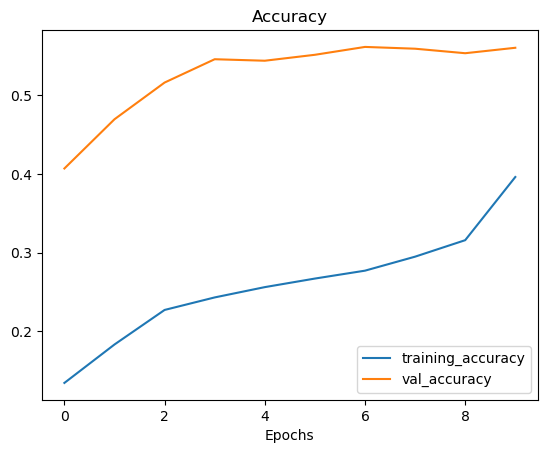

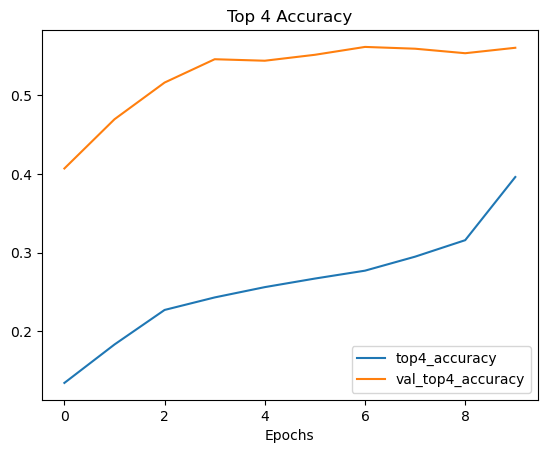

In [30]:
effnet_1_history_genre_ft = fine_tune(effnet_1_config)

### Genre | EfficientNetB0 | Learning from scratch

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_6[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 block3b_expand_activation   (None, None, None, 192)      0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_project_conv (Conv  (None, None, None, 48)       9216      ['block3b_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3b_project_bn (BatchN  (None, None, None, 48)       192       ['block3b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_drop (Dropout)      (None, None, None, 48)       0         ['block3b_project_bn[0][0]']  
          

 2D)                                                                                              
                                                                                                  
 block4b_project_bn (BatchN  (None, None, None, 96)       384       ['block4b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, None, None, 96)       0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, None, None, 96)       0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_e

 block5a_project_conv (Conv  (None, None, None, 112)      64512     ['block5a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5a_project_bn (BatchN  (None, None, None, 112)      448       ['block5a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5b_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block5b_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block5c_drop (Dropout)      (None, None, None, 112)      0         ['block5c_project_bn[0][0]']  
                                                                                                  
 block5c_add (Add)           (None, None, None, 112)      0         ['block5c_drop[0][0]',        
                                                                     'block5b_add[0][0]']         
                                                                                                  
 block5d_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5d_e

 block5e_project_bn (BatchN  (None, None, None, 112)      448       ['block5e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5e_drop (Dropout)      (None, None, None, 112)      0         ['block5e_project_bn[0][0]']  
                                                                                                  
 block5e_add (Add)           (None, None, None, 112)      0         ['block5e_drop[0][0]',        
                                                                     'block5d_add[0][0]']         
                                                                                                  
 block6a_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5e_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block6b_add (Add)           (None, None, None, 192)      0         ['block6b_drop[0][0]',        
                                                                     'block6a_project_bn[0][0]']  
                                                                                                  
 block6c_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6c_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)      (None, None, None, 192)      0         ['block6d_project_bn[0][0]']  
                                                                                                  
 block6d_add (Add)           (None, None, None, 192)      0         ['block6d_drop[0][0]',        
                                                                     'block6c_add[0][0]']         
                                                                                                  
 block6e_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6e_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6f_drop (Dropout)      (None, None, None, 192)      0         ['block6f_project_bn[0][0]']  
                                                                                                  
 block6f_add (Add)           (None, None, None, 192)      0         ['block6f_drop[0][0]',        
                                                                     'block6e_add[0][0]']         
                                                                                                  
 block6g_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6f_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6g_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6g_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block6h_drop (Dropout)      (None, None, None, 192)      0         ['block6h_project_bn[0][0]']  
                                                                                                  
 block6h_add (Add)           (None, None, None, 192)      0         ['block6h_drop[0][0]',        
                                                                     'block6g_add[0][0]']         
                                                                                                  
 top_conv (Conv2D)           (None, None, None, 1280)     245760    ['block6h_add[0][0]']         
                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )        

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 554s 497ms/step - loss: 3.7331 - accuracy: 0.1304 - top_2_accuracy: 0.2830 - top_3_accuracy: 0.3630 - top_4_accuracy: 0.4266 - ROC-AUC: 0.8403 - PR-AUC: 0.1219 - tp: 1316.0000 - fp: 1702.0000 - tn: 4154602.0000 - fn: 42900.0000 - precision: 0.4361 - recall: 0.0298 - f1_score: 0.0305 - val_loss: 3.5483 - val_accuracy: 0.1653 - val_top_2_accuracy: 0.2868 - val_top_3_accuracy: 0.3648 - val_top_4_accuracy: 0.4165 - val_ROC-AUC: 0.8299 - val_PR-AUC: 0.1003 - val_tp: 23.0000 - val_fp: 29.0000 - val_tn: 1033783.0000 - val_fn: 10975.0000 - val_precision: 0.4423 - val_recall: 0.0021 - val_f1_score: 0.0105
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 3.4062 - accuracy: 0.1803 - top_2_accuracy: 0.3066 - top_3_accuracy: 0.3852 - top_4_accuracy: 0.4488 - ROC-AUC: 0.8503 - PR-AUC: 0.1209 - tp: 551.0000 - fp: 779.0000 - tn: 3117107.0000 - fn: 32618.0000 - precision: 0.4143 - recall: 0.0166 - f1_score: 0.0156INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 427s 411ms/step - loss: 3.4062 - accuracy: 0.1803 - top_2_accuracy: 0.3066 - top_3_accuracy: 0.3852 - top_4_accuracy: 0.4488 - ROC-AUC: 0.8503 - PR-AUC: 0.1209 - tp: 551.0000 - fp: 779.0000 - tn: 3117107.0000 - fn: 32618.0000 - precision: 0.4143 - recall: 0.0166 - f1_score: 0.0156 - val_loss: 3.3197 - val_accuracy: 0.1738 - val_top_2_accuracy: 0.2867 - val_top_3_accuracy: 0.3745 - val_top_4_accuracy: 0.4520 - val_ROC-AUC: 0.8649 - val_PR-AUC: 0.1324 - val_tp: 410.0000 - val_fp: 453.0000 - val_tn: 1033359.0000 - val_fn: 10588.0000 - val_precision: 0.4751 - val_recall: 0.0373 - val_f1_score: 0.0201
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 3.2150 - accuracy: 0.2088 - top_2_accuracy: 0.3365 - top_3_accuracy: 0.4203 - top_4_accuracy: 0.4845 - ROC-AUC: 0.8722 - PR-AUC: 0.1502 - tp: 982.0000 - fp: 983.0000 - tn: 3116903.0000 - fn: 32187.0000 - precision: 0.4997 - recall: 0.0296 - f1_score: 0.0217INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 431s 415ms/step - loss: 3.2150 - accuracy: 0.2088 - top_2_accuracy: 0.3365 - top_3_accuracy: 0.4203 - top_4_accuracy: 0.4845 - ROC-AUC: 0.8722 - PR-AUC: 0.1502 - tp: 982.0000 - fp: 983.0000 - tn: 3116903.0000 - fn: 32187.0000 - precision: 0.4997 - recall: 0.0296 - f1_score: 0.0217 - val_loss: 3.1779 - val_accuracy: 0.2004 - val_top_2_accuracy: 0.3398 - val_top_3_accuracy: 0.4206 - val_top_4_accuracy: 0.4832 - val_ROC-AUC: 0.8746 - val_PR-AUC: 0.1565 - val_tp: 352.0000 - val_fp: 293.0000 - val_tn: 1033519.0000 - val_fn: 10646.0000 - val_precision: 0.5457 - val_recall: 0.0320 - val_f1_score: 0.0192
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1174 - accuracy: 0.2228 - top_2_accuracy: 0.3549 - top_3_accuracy: 0.4378 - top_4_accuracy: 0.5039 - ROC-AUC: 0.8815 - PR-AUC: 0.1650 - tp: 1044.0000 - fp: 986.0000 - tn: 3116900.0000 - fn: 32125.0000 - precision: 0.5143 - recall: 0.0315 - f1_score: 0.0262INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 426s 410ms/step - loss: 3.1174 - accuracy: 0.2228 - top_2_accuracy: 0.3549 - top_3_accuracy: 0.4378 - top_4_accuracy: 0.5039 - ROC-AUC: 0.8815 - PR-AUC: 0.1650 - tp: 1044.0000 - fp: 986.0000 - tn: 3116900.0000 - fn: 32125.0000 - precision: 0.5143 - recall: 0.0315 - f1_score: 0.0262 - val_loss: 3.0748 - val_accuracy: 0.2245 - val_top_2_accuracy: 0.3618 - val_top_3_accuracy: 0.4454 - val_top_4_accuracy: 0.5155 - val_ROC-AUC: 0.8844 - val_PR-AUC: 0.1720 - val_tp: 348.0000 - val_fp: 278.0000 - val_tn: 1033534.0000 - val_fn: 10650.0000 - val_precision: 0.5559 - val_recall: 0.0316 - val_f1_score: 0.0240
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0333 - accuracy: 0.2374 - top_2_accuracy: 0.3731 - top_3_accuracy: 0.4602 - top_4_accuracy: 0.5254 - ROC-AUC: 0.8889 - PR-AUC: 0.1823 - tp: 1274.0000 - fp: 1036.0000 - tn: 3116850.0000 - fn: 31895.0000 - precision: 0.5515 - recall: 0.0384 - f1_score: 0.0323INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 429s 413ms/step - loss: 3.0333 - accuracy: 0.2374 - top_2_accuracy: 0.3731 - top_3_accuracy: 0.4602 - top_4_accuracy: 0.5254 - ROC-AUC: 0.8889 - PR-AUC: 0.1823 - tp: 1274.0000 - fp: 1036.0000 - tn: 3116850.0000 - fn: 31895.0000 - precision: 0.5515 - recall: 0.0384 - f1_score: 0.0323 - val_loss: 3.0483 - val_accuracy: 0.2316 - val_top_2_accuracy: 0.3703 - val_top_3_accuracy: 0.4525 - val_top_4_accuracy: 0.5211 - val_ROC-AUC: 0.8886 - val_PR-AUC: 0.1747 - val_tp: 315.0000 - val_fp: 293.0000 - val_tn: 1033519.0000 - val_fn: 10683.0000 - val_precision: 0.5181 - val_recall: 0.0286 - val_f1_score: 0.0297
Epoch 6/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9615 - accuracy: 0.2494 - top_2_accuracy: 0.3887 - top_3_accuracy: 0.4740 - top_4_accuracy: 0.5408 - ROC-AUC: 0.8953 - PR-AUC: 0.1939 - tp: 1382.0000 - fp: 1110.0000 - tn: 3116776.0000 - fn: 31787.0000 - precision: 0.5546 - recall: 0.0417 - f1_score: 0.0401INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 435s 418ms/step - loss: 2.9615 - accuracy: 0.2494 - top_2_accuracy: 0.3887 - top_3_accuracy: 0.4740 - top_4_accuracy: 0.5408 - ROC-AUC: 0.8953 - PR-AUC: 0.1939 - tp: 1382.0000 - fp: 1110.0000 - tn: 3116776.0000 - fn: 31787.0000 - precision: 0.5546 - recall: 0.0417 - f1_score: 0.0401 - val_loss: 3.0204 - val_accuracy: 0.2327 - val_top_2_accuracy: 0.3662 - val_top_3_accuracy: 0.4521 - val_top_4_accuracy: 0.5266 - val_ROC-AUC: 0.8907 - val_PR-AUC: 0.1763 - val_tp: 170.0000 - val_fp: 118.0000 - val_tn: 1033694.0000 - val_fn: 10828.0000 - val_precision: 0.5903 - val_recall: 0.0155 - val_f1_score: 0.0404
Epoch 7/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8732 - accuracy: 0.2643 - top_2_accuracy: 0.4050 - top_3_accuracy: 0.4935 - top_4_accuracy: 0.5614 - ROC-AUC: 0.9021 - PR-AUC: 0.2174 - tp: 1771.0000 - fp: 1152.0000 - tn: 3116734.0000 - fn: 31398.0000 - precision: 0.6059 - recall: 0.0534 - f1_score: 0.0482INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 428s 412ms/step - loss: 2.8732 - accuracy: 0.2643 - top_2_accuracy: 0.4050 - top_3_accuracy: 0.4935 - top_4_accuracy: 0.5614 - ROC-AUC: 0.9021 - PR-AUC: 0.2174 - tp: 1771.0000 - fp: 1152.0000 - tn: 3116734.0000 - fn: 31398.0000 - precision: 0.6059 - recall: 0.0534 - f1_score: 0.0482 - val_loss: 2.9788 - val_accuracy: 0.2484 - val_top_2_accuracy: 0.3808 - val_top_3_accuracy: 0.4704 - val_top_4_accuracy: 0.5355 - val_ROC-AUC: 0.8939 - val_PR-AUC: 0.1936 - val_tp: 475.0000 - val_fp: 354.0000 - val_tn: 1033458.0000 - val_fn: 10523.0000 - val_precision: 0.5730 - val_recall: 0.0432 - val_f1_score: 0.0451
Epoch 8/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7678 - accuracy: 0.2888 - top_2_accuracy: 0.4288 - top_3_accuracy: 0.5200 - top_4_accuracy: 0.5867 - ROC-AUC: 0.9099 - PR-AUC: 0.2422 - tp: 2164.0000 - fp: 1354.0000 - tn: 3116532.0000 - fn: 31005.0000 - precision: 0.6151 - recall: 0.0652 - f1_score: 0.0645INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 425s 409ms/step - loss: 2.7678 - accuracy: 0.2888 - top_2_accuracy: 0.4288 - top_3_accuracy: 0.5200 - top_4_accuracy: 0.5867 - ROC-AUC: 0.9099 - PR-AUC: 0.2422 - tp: 2164.0000 - fp: 1354.0000 - tn: 3116532.0000 - fn: 31005.0000 - precision: 0.6151 - recall: 0.0652 - f1_score: 0.0645 - val_loss: 2.9205 - val_accuracy: 0.2626 - val_top_2_accuracy: 0.4081 - val_top_3_accuracy: 0.4934 - val_top_4_accuracy: 0.5620 - val_ROC-AUC: 0.8936 - val_PR-AUC: 0.2088 - val_tp: 755.0000 - val_fp: 746.0000 - val_tn: 1033066.0000 - val_fn: 10243.0000 - val_precision: 0.5030 - val_recall: 0.0686 - val_f1_score: 0.0526
Epoch 9/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6310 - accuracy: 0.3153 - top_2_accuracy: 0.4602 - top_3_accuracy: 0.5505 - top_4_accuracy: 0.6140 - ROC-AUC: 0.9198 - PR-AUC: 0.2787 - tp: 2842.0000 - fp: 1541.0000 - tn: 3116345.0000 - fn: 30327.0000 - precision: 0.6484 - recall: 0.0857 - f1_score: 0.0848INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 441s 425ms/step - loss: 2.6310 - accuracy: 0.3153 - top_2_accuracy: 0.4602 - top_3_accuracy: 0.5505 - top_4_accuracy: 0.6140 - ROC-AUC: 0.9198 - PR-AUC: 0.2787 - tp: 2842.0000 - fp: 1541.0000 - tn: 3116345.0000 - fn: 30327.0000 - precision: 0.6484 - recall: 0.0857 - f1_score: 0.0848 - val_loss: 2.9092 - val_accuracy: 0.2659 - val_top_2_accuracy: 0.4063 - val_top_3_accuracy: 0.4934 - val_top_4_accuracy: 0.5594 - val_ROC-AUC: 0.8948 - val_PR-AUC: 0.2158 - val_tp: 811.0000 - val_fp: 711.0000 - val_tn: 1033101.0000 - val_fn: 10187.0000 - val_precision: 0.5329 - val_recall: 0.0737 - val_f1_score: 0.0545
Epoch 10/100
1037/1037 [==============================] - 418s 403ms/step - loss: 2.4619 - accuracy: 0.3518 - top_2_accuracy: 0.4995 - top_3_accuracy: 0.5898 - top_4_accuracy: 0.6529 - ROC-AUC: 0.9301 - PR-AUC: 0.3274 - tp: 3772.0000 - fp: 1778.0000 - tn: 3116108.0000 - fn: 29397.0000 - precision: 0.6796 - recall: 0.1137 - f1_score: 0.1163 - val_l

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/EfficientNetV2B0_2/assets


344/344 [==============================] - 59s 170ms/step - loss: 3.0264 - accuracy: 0.2597 - top_2_accuracy: 0.3973 - top_3_accuracy: 0.4891 - top_4_accuracy: 0.5546 - ROC-AUC: 0.8813 - PR-AUC: 0.2091 - tp: 1271.0000 - fp: 1635.0000 - tn: 1032177.0000 - fn: 9727.0000 - precision: 0.4374 - recall: 0.1156 - f1_score: 0.0698
VALID:
 [3.026364803314209, 0.2596835792064667, 0.3972540497779846, 0.48908892273902893, 0.554555356502533, 0.8812717795372009, 0.20906449854373932, 1271.0, 1635.0, 1032177.0, 9727.0, 0.4373709559440613, 0.11556646972894669, 0.06979802995920181]
346/346 [==============================] - 67s 195ms/step - loss: 4.1513 - accuracy: 0.1350 - top_2_accuracy: 0.2321 - top_3_accuracy: 0.3027 - top_4_accuracy: 0.3610 - ROC-AUC: 0.7845 - PR-AUC: 0.0740 - tp: 441.0000 - fp: 2026.0000 - tn: 1036392.0000 - fn: 10606.0000 - precision: 0.1788 - recall: 0.0399 - f1_score: 0.0207
TEST:
 [4.151349067687988, 0.13496877253055573, 0.23209920525550842, 0.30270662903785706, 0.361002981662

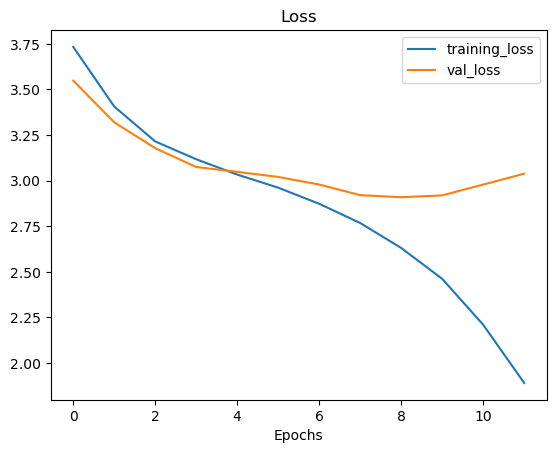

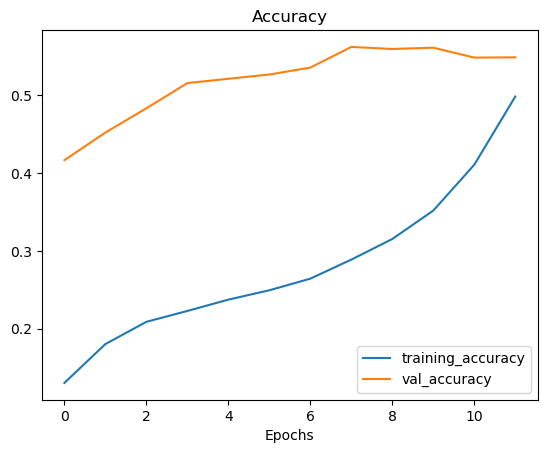

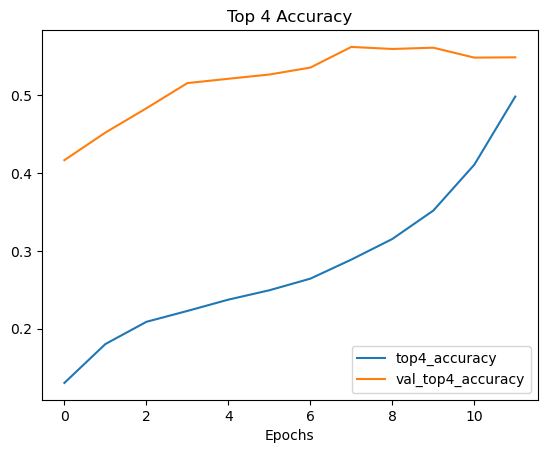

In [35]:
effnet_2_history_genre = effnet(effnet_2_config)

## Genre | Xception
### Genre | Xception | Transfer Learning

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, None, None, 728)      0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, None, None, 728)      536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, None, None, 728)      2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, None, None, 728)      536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, None, None, 728)      2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, None, None, 728)      0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, None, None, 728)      0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, None, None, 728)      0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, None, None, 728)      536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, None, None, 728)      0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, None, None, 728)      536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, None, None, 728)      2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, None, None, 728)      0         ['block12_sepconv3_bn[0][0]', 
          

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 320s 302ms/step - loss: 3.3569 - accuracy: 0.1823 - top_2_accuracy: 0.3291 - top_3_accuracy: 0.4120 - top_4_accuracy: 0.4767 - ROC-AUC: 0.8674 - PR-AUC: 0.1453 - tp: 982.0000 - fp: 1007.0000 - tn: 4155297.0000 - fn: 43234.0000 - precision: 0.4937 - recall: 0.0222 - f1_score: 0.0310 - val_loss: 3.1881 - val_accuracy: 0.2096 - val_top_2_accuracy: 0.3371 - val_top_3_accuracy: 0.4247 - val_top_4_accuracy: 0.4868 - val_ROC-AUC: 0.8789 - val_PR-AUC: 0.1498 - val_tp: 68.0000 - val_fp: 52.0000 - val_tn: 1033760.0000 - val_fn: 10930.0000 - val_precision: 0.5667 - val_recall: 0.0062 - val_f1_score: 0.0169
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 3.1279 - accuracy: 0.2238 - top_2_accuracy: 0.3526 - top_3_accuracy: 0.4350 - top_4_accuracy: 0.4995 - ROC-AUC: 0.8836 - PR-AUC: 0.1596 - tp: 320.0000 - fp: 231.0000 - tn: 3117655.0000 - fn: 32849.0000 - precision: 0.5808 - recall: 0.0096 - f1_score: 0.0200INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 291ms/step - loss: 3.1279 - accuracy: 0.2238 - top_2_accuracy: 0.3526 - top_3_accuracy: 0.4350 - top_4_accuracy: 0.4995 - ROC-AUC: 0.8836 - PR-AUC: 0.1596 - tp: 320.0000 - fp: 231.0000 - tn: 3117655.0000 - fn: 32849.0000 - precision: 0.5808 - recall: 0.0096 - f1_score: 0.0200 - val_loss: 3.0908 - val_accuracy: 0.2304 - val_top_2_accuracy: 0.3581 - val_top_3_accuracy: 0.4441 - val_top_4_accuracy: 0.5092 - val_ROC-AUC: 0.8864 - val_PR-AUC: 0.1678 - val_tp: 138.0000 - val_fp: 101.0000 - val_tn: 1033711.0000 - val_fn: 10860.0000 - val_precision: 0.5774 - val_recall: 0.0125 - val_f1_score: 0.0205
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0365 - accuracy: 0.2372 - top_2_accuracy: 0.3711 - top_3_accuracy: 0.4545 - top_4_accuracy: 0.5186 - ROC-AUC: 0.8934 - PR-AUC: 0.1765 - tp: 536.0000 - fp: 316.0000 - tn: 3117570.0000 - fn: 32633.0000 - precision: 0.6291 - recall: 0.0162 - f1_score: 0.0249INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 303s 292ms/step - loss: 3.0365 - accuracy: 0.2372 - top_2_accuracy: 0.3711 - top_3_accuracy: 0.4545 - top_4_accuracy: 0.5186 - ROC-AUC: 0.8934 - PR-AUC: 0.1765 - tp: 536.0000 - fp: 316.0000 - tn: 3117570.0000 - fn: 32633.0000 - precision: 0.6291 - recall: 0.0162 - f1_score: 0.0249 - val_loss: 3.0478 - val_accuracy: 0.2397 - val_top_2_accuracy: 0.3713 - val_top_3_accuracy: 0.4581 - val_top_4_accuracy: 0.5216 - val_ROC-AUC: 0.8909 - val_PR-AUC: 0.1768 - val_tp: 179.0000 - val_fp: 123.0000 - val_tn: 1033689.0000 - val_fn: 10819.0000 - val_precision: 0.5927 - val_recall: 0.0163 - val_f1_score: 0.0248
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9774 - accuracy: 0.2461 - top_2_accuracy: 0.3794 - top_3_accuracy: 0.4634 - top_4_accuracy: 0.5300 - ROC-AUC: 0.8994 - PR-AUC: 0.1870 - tp: 669.0000 - fp: 393.0000 - tn: 3117493.0000 - fn: 32500.0000 - precision: 0.6299 - recall: 0.0202 - f1_score: 0.0297INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 302s 290ms/step - loss: 2.9774 - accuracy: 0.2461 - top_2_accuracy: 0.3794 - top_3_accuracy: 0.4634 - top_4_accuracy: 0.5300 - ROC-AUC: 0.8994 - PR-AUC: 0.1870 - tp: 669.0000 - fp: 393.0000 - tn: 3117493.0000 - fn: 32500.0000 - precision: 0.6299 - recall: 0.0202 - f1_score: 0.0297 - val_loss: 3.0268 - val_accuracy: 0.2451 - val_top_2_accuracy: 0.3796 - val_top_3_accuracy: 0.4623 - val_top_4_accuracy: 0.5301 - val_ROC-AUC: 0.8919 - val_PR-AUC: 0.1808 - val_tp: 208.0000 - val_fp: 153.0000 - val_tn: 1033659.0000 - val_fn: 10790.0000 - val_precision: 0.5762 - val_recall: 0.0189 - val_f1_score: 0.0300
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9304 - accuracy: 0.2542 - top_2_accuracy: 0.3877 - top_3_accuracy: 0.4728 - top_4_accuracy: 0.5405 - ROC-AUC: 0.9042 - PR-AUC: 0.1960 - tp: 772.0000 - fp: 440.0000 - tn: 3117446.0000 - fn: 32397.0000 - precision: 0.6370 - recall: 0.0233 - f1_score: 0.0337INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 303s 292ms/step - loss: 2.9304 - accuracy: 0.2542 - top_2_accuracy: 0.3877 - top_3_accuracy: 0.4728 - top_4_accuracy: 0.5405 - ROC-AUC: 0.9042 - PR-AUC: 0.1960 - tp: 772.0000 - fp: 440.0000 - tn: 3117446.0000 - fn: 32397.0000 - precision: 0.6370 - recall: 0.0233 - f1_score: 0.0337 - val_loss: 2.9990 - val_accuracy: 0.2463 - val_top_2_accuracy: 0.3820 - val_top_3_accuracy: 0.4698 - val_top_4_accuracy: 0.5316 - val_ROC-AUC: 0.8946 - val_PR-AUC: 0.1869 - val_tp: 232.0000 - val_fp: 163.0000 - val_tn: 1033649.0000 - val_fn: 10766.0000 - val_precision: 0.5873 - val_recall: 0.0211 - val_f1_score: 0.0310
Epoch 6/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8923 - accuracy: 0.2586 - top_2_accuracy: 0.3917 - top_3_accuracy: 0.4812 - top_4_accuracy: 0.5458 - ROC-AUC: 0.9086 - PR-AUC: 0.2025 - tp: 871.0000 - fp: 509.0000 - tn: 3117377.0000 - fn: 32298.0000 - precision: 0.6312 - recall: 0.0263 - f1_score: 0.0366INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.8923 - accuracy: 0.2586 - top_2_accuracy: 0.3917 - top_3_accuracy: 0.4812 - top_4_accuracy: 0.5458 - ROC-AUC: 0.9086 - PR-AUC: 0.2025 - tp: 871.0000 - fp: 509.0000 - tn: 3117377.0000 - fn: 32298.0000 - precision: 0.6312 - recall: 0.0263 - f1_score: 0.0366 - val_loss: 2.9855 - val_accuracy: 0.2530 - val_top_2_accuracy: 0.3873 - val_top_3_accuracy: 0.4744 - val_top_4_accuracy: 0.5376 - val_ROC-AUC: 0.8950 - val_PR-AUC: 0.1880 - val_tp: 224.0000 - val_fp: 157.0000 - val_tn: 1033655.0000 - val_fn: 10774.0000 - val_precision: 0.5879 - val_recall: 0.0204 - val_f1_score: 0.0333
Epoch 7/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8601 - accuracy: 0.2641 - top_2_accuracy: 0.3943 - top_3_accuracy: 0.4869 - top_4_accuracy: 0.5536 - ROC-AUC: 0.9115 - PR-AUC: 0.2086 - tp: 947.0000 - fp: 515.0000 - tn: 3117371.0000 - fn: 32222.0000 - precision: 0.6477 - recall: 0.0286 - f1_score: 0.0393INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.8601 - accuracy: 0.2641 - top_2_accuracy: 0.3943 - top_3_accuracy: 0.4869 - top_4_accuracy: 0.5536 - ROC-AUC: 0.9115 - PR-AUC: 0.2086 - tp: 947.0000 - fp: 515.0000 - tn: 3117371.0000 - fn: 32222.0000 - precision: 0.6477 - recall: 0.0286 - f1_score: 0.0393 - val_loss: 2.9677 - val_accuracy: 0.2538 - val_top_2_accuracy: 0.3900 - val_top_3_accuracy: 0.4785 - val_top_4_accuracy: 0.5443 - val_ROC-AUC: 0.8956 - val_PR-AUC: 0.1931 - val_tp: 307.0000 - val_fp: 203.0000 - val_tn: 1033609.0000 - val_fn: 10691.0000 - val_precision: 0.6020 - val_recall: 0.0279 - val_f1_score: 0.0332
Epoch 8/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8303 - accuracy: 0.2684 - top_2_accuracy: 0.4039 - top_3_accuracy: 0.4917 - top_4_accuracy: 0.5596 - ROC-AUC: 0.9144 - PR-AUC: 0.2143 - tp: 989.0000 - fp: 539.0000 - tn: 3117347.0000 - fn: 32180.0000 - precision: 0.6473 - recall: 0.0298 - f1_score: 0.0442INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 303s 292ms/step - loss: 2.8303 - accuracy: 0.2684 - top_2_accuracy: 0.4039 - top_3_accuracy: 0.4917 - top_4_accuracy: 0.5596 - ROC-AUC: 0.9144 - PR-AUC: 0.2143 - tp: 989.0000 - fp: 539.0000 - tn: 3117347.0000 - fn: 32180.0000 - precision: 0.6473 - recall: 0.0298 - f1_score: 0.0442 - val_loss: 2.9646 - val_accuracy: 0.2611 - val_top_2_accuracy: 0.3913 - val_top_3_accuracy: 0.4773 - val_top_4_accuracy: 0.5436 - val_ROC-AUC: 0.8968 - val_PR-AUC: 0.1943 - val_tp: 249.0000 - val_fp: 149.0000 - val_tn: 1033663.0000 - val_fn: 10749.0000 - val_precision: 0.6256 - val_recall: 0.0226 - val_f1_score: 0.0365
Epoch 9/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8044 - accuracy: 0.2703 - top_2_accuracy: 0.4067 - top_3_accuracy: 0.5005 - top_4_accuracy: 0.5672 - ROC-AUC: 0.9167 - PR-AUC: 0.2184 - tp: 1061.0000 - fp: 556.0000 - tn: 3117330.0000 - fn: 32108.0000 - precision: 0.6562 - recall: 0.0320 - f1_score: 0.0470INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.8044 - accuracy: 0.2703 - top_2_accuracy: 0.4067 - top_3_accuracy: 0.5005 - top_4_accuracy: 0.5672 - ROC-AUC: 0.9167 - PR-AUC: 0.2184 - tp: 1061.0000 - fp: 556.0000 - tn: 3117330.0000 - fn: 32108.0000 - precision: 0.6562 - recall: 0.0320 - f1_score: 0.0470 - val_loss: 2.9492 - val_accuracy: 0.2570 - val_top_2_accuracy: 0.3953 - val_top_3_accuracy: 0.4842 - val_top_4_accuracy: 0.5449 - val_ROC-AUC: 0.8970 - val_PR-AUC: 0.1981 - val_tp: 341.0000 - val_fp: 235.0000 - val_tn: 1033577.0000 - val_fn: 10657.0000 - val_precision: 0.5920 - val_recall: 0.0310 - val_f1_score: 0.0371
Epoch 10/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7811 - accuracy: 0.2740 - top_2_accuracy: 0.4105 - top_3_accuracy: 0.5047 - top_4_accuracy: 0.5705 - ROC-AUC: 0.9195 - PR-AUC: 0.2231 - tp: 1098.0000 - fp: 566.0000 - tn: 3117320.0000 - fn: 32071.0000 - precision: 0.6599 - recall: 0.0331 - f1_score: 0.0549INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 303s 292ms/step - loss: 2.7811 - accuracy: 0.2740 - top_2_accuracy: 0.4105 - top_3_accuracy: 0.5047 - top_4_accuracy: 0.5705 - ROC-AUC: 0.9195 - PR-AUC: 0.2231 - tp: 1098.0000 - fp: 566.0000 - tn: 3117320.0000 - fn: 32071.0000 - precision: 0.6599 - recall: 0.0331 - f1_score: 0.0549 - val_loss: 2.9457 - val_accuracy: 0.2560 - val_top_2_accuracy: 0.3926 - val_top_3_accuracy: 0.4821 - val_top_4_accuracy: 0.5500 - val_ROC-AUC: 0.8975 - val_PR-AUC: 0.1978 - val_tp: 358.0000 - val_fp: 250.0000 - val_tn: 1033562.0000 - val_fn: 10640.0000 - val_precision: 0.5888 - val_recall: 0.0326 - val_f1_score: 0.0356
Epoch 11/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7578 - accuracy: 0.2759 - top_2_accuracy: 0.4149 - top_3_accuracy: 0.5076 - top_4_accuracy: 0.5746 - ROC-AUC: 0.9215 - PR-AUC: 0.2273 - tp: 1172.0000 - fp: 593.0000 - tn: 3117293.0000 - fn: 31997.0000 - precision: 0.6640 - recall: 0.0353 - f1_score: 0.0566INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.7578 - accuracy: 0.2759 - top_2_accuracy: 0.4149 - top_3_accuracy: 0.5076 - top_4_accuracy: 0.5746 - ROC-AUC: 0.9215 - PR-AUC: 0.2273 - tp: 1172.0000 - fp: 593.0000 - tn: 3117293.0000 - fn: 31997.0000 - precision: 0.6640 - recall: 0.0353 - f1_score: 0.0566 - val_loss: 2.9375 - val_accuracy: 0.2613 - val_top_2_accuracy: 0.3993 - val_top_3_accuracy: 0.4837 - val_top_4_accuracy: 0.5504 - val_ROC-AUC: 0.8987 - val_PR-AUC: 0.2012 - val_tp: 369.0000 - val_fp: 253.0000 - val_tn: 1033559.0000 - val_fn: 10629.0000 - val_precision: 0.5932 - val_recall: 0.0336 - val_f1_score: 0.0388
Epoch 12/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7368 - accuracy: 0.2799 - top_2_accuracy: 0.4175 - top_3_accuracy: 0.5139 - top_4_accuracy: 0.5798 - ROC-AUC: 0.9237 - PR-AUC: 0.2319 - tp: 1207.0000 - fp: 602.0000 - tn: 3117284.0000 - fn: 31962.0000 - precision: 0.6672 - recall: 0.0364 - f1_score: 0.0626INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.7368 - accuracy: 0.2799 - top_2_accuracy: 0.4175 - top_3_accuracy: 0.5139 - top_4_accuracy: 0.5798 - ROC-AUC: 0.9237 - PR-AUC: 0.2319 - tp: 1207.0000 - fp: 602.0000 - tn: 3117284.0000 - fn: 31962.0000 - precision: 0.6672 - recall: 0.0364 - f1_score: 0.0626 - val_loss: 2.9355 - val_accuracy: 0.2611 - val_top_2_accuracy: 0.3967 - val_top_3_accuracy: 0.4841 - val_top_4_accuracy: 0.5530 - val_ROC-AUC: 0.8980 - val_PR-AUC: 0.2016 - val_tp: 391.0000 - val_fp: 273.0000 - val_tn: 1033539.0000 - val_fn: 10607.0000 - val_precision: 0.5889 - val_recall: 0.0356 - val_f1_score: 0.0406
Epoch 13/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7172 - accuracy: 0.2834 - top_2_accuracy: 0.4211 - top_3_accuracy: 0.5166 - top_4_accuracy: 0.5846 - ROC-AUC: 0.9252 - PR-AUC: 0.2357 - tp: 1269.0000 - fp: 611.0000 - tn: 3117275.0000 - fn: 31900.0000 - precision: 0.6750 - recall: 0.0383 - f1_score: 0.0672INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 303s 292ms/step - loss: 2.7172 - accuracy: 0.2834 - top_2_accuracy: 0.4211 - top_3_accuracy: 0.5166 - top_4_accuracy: 0.5846 - ROC-AUC: 0.9252 - PR-AUC: 0.2357 - tp: 1269.0000 - fp: 611.0000 - tn: 3117275.0000 - fn: 31900.0000 - precision: 0.6750 - recall: 0.0383 - f1_score: 0.0672 - val_loss: 2.9288 - val_accuracy: 0.2620 - val_top_2_accuracy: 0.3981 - val_top_3_accuracy: 0.4871 - val_top_4_accuracy: 0.5518 - val_ROC-AUC: 0.8994 - val_PR-AUC: 0.2035 - val_tp: 383.0000 - val_fp: 268.0000 - val_tn: 1033544.0000 - val_fn: 10615.0000 - val_precision: 0.5883 - val_recall: 0.0348 - val_f1_score: 0.0406
Epoch 14/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6992 - accuracy: 0.2851 - top_2_accuracy: 0.4232 - top_3_accuracy: 0.5211 - top_4_accuracy: 0.5897 - ROC-AUC: 0.9278 - PR-AUC: 0.2391 - tp: 1316.0000 - fp: 652.0000 - tn: 3117234.0000 - fn: 31853.0000 - precision: 0.6687 - recall: 0.0397 - f1_score: 0.0824INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.6992 - accuracy: 0.2851 - top_2_accuracy: 0.4232 - top_3_accuracy: 0.5211 - top_4_accuracy: 0.5897 - ROC-AUC: 0.9278 - PR-AUC: 0.2391 - tp: 1316.0000 - fp: 652.0000 - tn: 3117234.0000 - fn: 31853.0000 - precision: 0.6687 - recall: 0.0397 - f1_score: 0.0824 - val_loss: 2.9253 - val_accuracy: 0.2628 - val_top_2_accuracy: 0.3975 - val_top_3_accuracy: 0.4904 - val_top_4_accuracy: 0.5558 - val_ROC-AUC: 0.9003 - val_PR-AUC: 0.2039 - val_tp: 358.0000 - val_fp: 229.0000 - val_tn: 1033583.0000 - val_fn: 10640.0000 - val_precision: 0.6099 - val_recall: 0.0326 - val_f1_score: 0.0429
Epoch 15/100
1037/1037 [==============================] - 297s 286ms/step - loss: 2.6800 - accuracy: 0.2871 - top_2_accuracy: 0.4298 - top_3_accuracy: 0.5252 - top_4_accuracy: 0.5947 - ROC-AUC: 0.9289 - PR-AUC: 0.2436 - tp: 1367.0000 - fp: 633.0000 - tn: 3117253.0000 - fn: 31802.0000 - precision: 0.6835 - recall: 0.0412 - f1_score: 0.0870 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.6648 - accuracy: 0.2905 - top_2_accuracy: 0.4312 - top_3_accuracy: 0.5298 - top_4_accuracy: 0.5972 - ROC-AUC: 0.9301 - PR-AUC: 0.2462 - tp: 1372.0000 - fp: 643.0000 - tn: 3117243.0000 - fn: 31797.0000 - precision: 0.6809 - recall: 0.0414 - f1_score: 0.1009 - val_loss: 2.9229 - val_accuracy: 0.2667 - val_top_2_accuracy: 0.4002 - val_top_3_accuracy: 0.4916 - val_top_4_accuracy: 0.5586 - val_ROC-AUC: 0.9004 - val_PR-AUC: 0.2044 - val_tp: 334.0000 - val_fp: 223.0000 - val_tn: 1033589.0000 - val_fn: 10664.0000 - val_precision: 0.5996 - val_recall: 0.0304 - val_f1_score: 0.0505
Epoch 17/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6479 - accuracy: 0.2935 - top_2_accuracy: 0.4346 - top_3_accuracy: 0.5319 - top_4_accuracy: 0.6007 - ROC-AUC: 0.9318 - PR-AUC: 0.2501 - tp: 1420.0000 - fp: 666.0000 - tn: 3117220.0000 - fn: 31749.0000 - precision: 0.6807 - recall: 0.0428 - f1_score: 0.1166INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 303s 292ms/step - loss: 2.6479 - accuracy: 0.2935 - top_2_accuracy: 0.4346 - top_3_accuracy: 0.5319 - top_4_accuracy: 0.6007 - ROC-AUC: 0.9318 - PR-AUC: 0.2501 - tp: 1420.0000 - fp: 666.0000 - tn: 3117220.0000 - fn: 31749.0000 - precision: 0.6807 - recall: 0.0428 - f1_score: 0.1166 - val_loss: 2.9162 - val_accuracy: 0.2650 - val_top_2_accuracy: 0.3973 - val_top_3_accuracy: 0.4930 - val_top_4_accuracy: 0.5606 - val_ROC-AUC: 0.9004 - val_PR-AUC: 0.2052 - val_tp: 378.0000 - val_fp: 244.0000 - val_tn: 1033568.0000 - val_fn: 10620.0000 - val_precision: 0.6077 - val_recall: 0.0344 - val_f1_score: 0.0482
Epoch 18/100
1037/1037 [==============================] - 297s 286ms/step - loss: 2.6312 - accuracy: 0.2945 - top_2_accuracy: 0.4386 - top_3_accuracy: 0.5378 - top_4_accuracy: 0.6046 - ROC-AUC: 0.9332 - PR-AUC: 0.2532 - tp: 1427.0000 - fp: 660.0000 - tn: 3117226.0000 - fn: 31742.0000 - precision: 0.6838 - recall: 0.0430 - f1_score: 0.1136 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 301s 290ms/step - loss: 2.6170 - accuracy: 0.2961 - top_2_accuracy: 0.4419 - top_3_accuracy: 0.5400 - top_4_accuracy: 0.6102 - ROC-AUC: 0.9346 - PR-AUC: 0.2560 - tp: 1513.0000 - fp: 665.0000 - tn: 3117221.0000 - fn: 31656.0000 - precision: 0.6947 - recall: 0.0456 - f1_score: 0.1202 - val_loss: 2.9159 - val_accuracy: 0.2660 - val_top_2_accuracy: 0.4013 - val_top_3_accuracy: 0.4944 - val_top_4_accuracy: 0.5630 - val_ROC-AUC: 0.8995 - val_PR-AUC: 0.2056 - val_tp: 344.0000 - val_fp: 197.0000 - val_tn: 1033615.0000 - val_fn: 10654.0000 - val_precision: 0.6359 - val_recall: 0.0313 - val_f1_score: 0.0491
Epoch 20/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6023 - accuracy: 0.2988 - top_2_accuracy: 0.4448 - top_3_accuracy: 0.5437 - top_4_accuracy: 0.6113 - ROC-AUC: 0.9360 - PR-AUC: 0.2594 - tp: 1492.0000 - fp: 669.0000 - tn: 3117217.0000 - fn: 31677.0000 - precision: 0.6904 - recall: 0.0450 - f1_score: 0.1346INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 303s 292ms/step - loss: 2.6023 - accuracy: 0.2988 - top_2_accuracy: 0.4448 - top_3_accuracy: 0.5437 - top_4_accuracy: 0.6113 - ROC-AUC: 0.9360 - PR-AUC: 0.2594 - tp: 1492.0000 - fp: 669.0000 - tn: 3117217.0000 - fn: 31677.0000 - precision: 0.6904 - recall: 0.0450 - f1_score: 0.1346 - val_loss: 2.9112 - val_accuracy: 0.2690 - val_top_2_accuracy: 0.4038 - val_top_3_accuracy: 0.4961 - val_top_4_accuracy: 0.5623 - val_ROC-AUC: 0.9002 - val_PR-AUC: 0.2102 - val_tp: 424.0000 - val_fp: 281.0000 - val_tn: 1033531.0000 - val_fn: 10574.0000 - val_precision: 0.6014 - val_recall: 0.0386 - val_f1_score: 0.0524
Epoch 21/100
1037/1037 [==============================] - 297s 286ms/step - loss: 2.5885 - accuracy: 0.3021 - top_2_accuracy: 0.4454 - top_3_accuracy: 0.5466 - top_4_accuracy: 0.6152 - ROC-AUC: 0.9367 - PR-AUC: 0.2624 - tp: 1530.0000 - fp: 674.0000 - tn: 3117212.0000 - fn: 31639.0000 - precision: 0.6942 - recall: 0.0461 - f1_score: 0.1452 - val_los

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL/assets


344/344 [==============================] - 75s 216ms/step - loss: 2.9123 - accuracy: 0.2680 - top_2_accuracy: 0.4044 - top_3_accuracy: 0.4968 - top_4_accuracy: 0.5652 - ROC-AUC: 0.8986 - PR-AUC: 0.2096 - tp: 464.0000 - fp: 314.0000 - tn: 1033498.0000 - fn: 10534.0000 - precision: 0.5964 - recall: 0.0422 - f1_score: 0.0507
VALID:
 [2.912278175354004, 0.26795780658721924, 0.40443718433380127, 0.49681758880615234, 0.5651936531066895, 0.8985701203346252, 0.20955663919448853, 464.0, 314.0, 1033498.0, 10534.0, 0.596401035785675, 0.04218949005007744, 0.050732869654893875]
346/346 [==============================] - 78s 225ms/step - loss: 2.9121 - accuracy: 0.2650 - top_2_accuracy: 0.4033 - top_3_accuracy: 0.4955 - top_4_accuracy: 0.5592 - ROC-AUC: 0.8993 - PR-AUC: 0.2100 - tp: 473.0000 - fp: 322.0000 - tn: 1038096.0000 - fn: 10574.0000 - precision: 0.5950 - recall: 0.0428 - f1_score: 0.0497
TEST:
 [2.912128448486328, 0.26495879888534546, 0.4032769203186035, 0.49551913142204285, 0.5592468380928

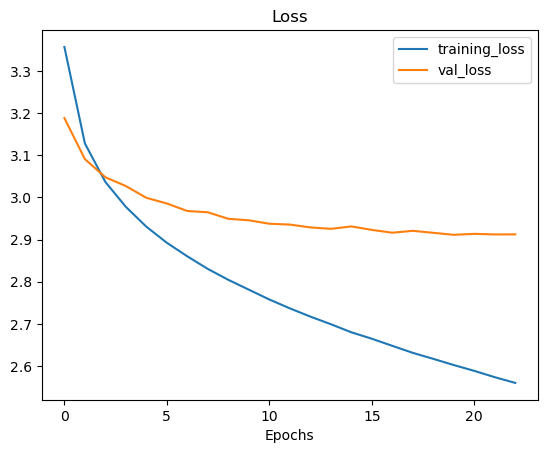

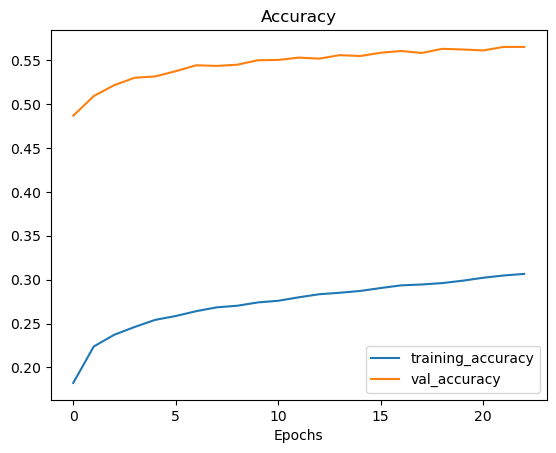

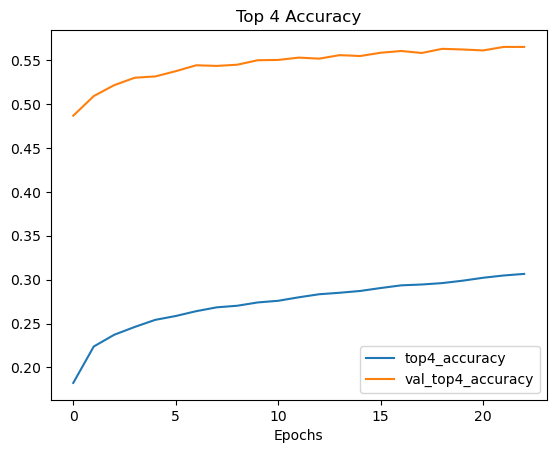

In [31]:
xception_1_history_genre = xception(xception_1_config)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 pooling_layer (GlobalMaxPo  (None, 2048)              0         
 oling2D)                                                        
                                                                 
 dense_3 (Dense)             (None, 95)                194655    
                                                                 
 activation_3 (Activation)   (None, 95)                0         
                                                                 
Total params: 21056135 (80.32 MB)
Trainable params: 2100160

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 924s 879ms/step - loss: 2.8682 - accuracy: 0.2674 - top_2_accuracy: 0.4047 - top_3_accuracy: 0.4938 - top_4_accuracy: 0.5607 - ROC-AUC: 0.9039 - PR-AUC: 0.2115 - tp: 2143.0000 - fp: 1492.0000 - tn: 4154812.0000 - fn: 42073.0000 - precision: 0.5895 - recall: 0.0485 - f1_score: 0.0432 - val_loss: 2.7494 - val_accuracy: 0.2891 - val_top_2_accuracy: 0.4396 - val_top_3_accuracy: 0.5314 - val_top_4_accuracy: 0.5938 - val_ROC-AUC: 0.9103 - val_PR-AUC: 0.2445 - val_tp: 903.0000 - val_fp: 679.0000 - val_tn: 1033133.0000 - val_fn: 10095.0000 - val_precision: 0.5708 - val_recall: 0.0821 - val_f1_score: 0.0383 - lr: 1.0000e-04
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6296 - accuracy: 0.3088 - top_2_accuracy: 0.4557 - top_3_accuracy: 0.5479 - top_4_accuracy: 0.6128 - ROC-AUC: 0.9225 - PR-AUC: 0.2687 - tp: 2641.0000 - fp: 1585.0000 - tn: 3116301.0000 - fn: 30528.0000 - precision: 0.6249 - recall: 0.0796 - f1_score: 0.0627

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 902s 869ms/step - loss: 2.6296 - accuracy: 0.3088 - top_2_accuracy: 0.4557 - top_3_accuracy: 0.5479 - top_4_accuracy: 0.6128 - ROC-AUC: 0.9225 - PR-AUC: 0.2687 - tp: 2641.0000 - fp: 1585.0000 - tn: 3116301.0000 - fn: 30528.0000 - precision: 0.6249 - recall: 0.0796 - f1_score: 0.0627 - val_loss: 2.6669 - val_accuracy: 0.3085 - val_top_2_accuracy: 0.4546 - val_top_3_accuracy: 0.5456 - val_top_4_accuracy: 0.6099 - val_ROC-AUC: 0.9212 - val_PR-AUC: 0.2692 - val_tp: 717.0000 - val_fp: 318.0000 - val_tn: 1033494.0000 - val_fn: 10281.0000 - val_precision: 0.6928 - val_recall: 0.0652 - val_f1_score: 0.0595 - lr: 1.0000e-04
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 2.4559 - accuracy: 0.3373 - top_2_accuracy: 0.4918 - top_3_accuracy: 0.5877 - top_4_accuracy: 0.6549 - ROC-AUC: 0.9332 - PR-AUC: 0.3143 - tp: 3613.0000 - fp: 1879.0000 - tn: 3116007.0000 - fn: 29556.0000 - precision: 0.6579 - recall: 0.1089 - f1_score: 0.0956

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 896s 863ms/step - loss: 2.4559 - accuracy: 0.3373 - top_2_accuracy: 0.4918 - top_3_accuracy: 0.5877 - top_4_accuracy: 0.6549 - ROC-AUC: 0.9332 - PR-AUC: 0.3143 - tp: 3613.0000 - fp: 1879.0000 - tn: 3116007.0000 - fn: 29556.0000 - precision: 0.6579 - recall: 0.1089 - f1_score: 0.0956 - val_loss: 2.6490 - val_accuracy: 0.3144 - val_top_2_accuracy: 0.4584 - val_top_3_accuracy: 0.5503 - val_top_4_accuracy: 0.6142 - val_ROC-AUC: 0.9177 - val_PR-AUC: 0.2742 - val_tp: 1095.0000 - val_fp: 798.0000 - val_tn: 1033014.0000 - val_fn: 9903.0000 - val_precision: 0.5784 - val_recall: 0.0996 - val_f1_score: 0.0758 - lr: 1.0000e-04
Epoch 4/100
1037/1037 [==============================] - 873s 841ms/step - loss: 2.2534 - accuracy: 0.3835 - top_2_accuracy: 0.5362 - top_3_accuracy: 0.6323 - top_4_accuracy: 0.6944 - ROC-AUC: 0.9441 - PR-AUC: 0.3739 - tp: 5143.0000 - fp: 2334.0000 - tn: 3115552.0000 - fn: 28026.0000 - precision: 0.6878 - recall: 0.1551 - f1_score

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_1_TL_FT/assets


344/344 [==============================] - 76s 218ms/step - loss: 3.2079 - accuracy: 0.3123 - top_2_accuracy: 0.4488 - top_3_accuracy: 0.5392 - top_4_accuracy: 0.6049 - ROC-AUC: 0.8731 - PR-AUC: 0.2727 - tp: 2370.0000 - fp: 3141.0000 - tn: 1030671.0000 - fn: 8628.0000 - precision: 0.4300 - recall: 0.2155 - f1_score: 0.1313
VALID:
 [3.207909345626831, 0.31232950091362, 0.448808878660202, 0.5391889214515686, 0.604928195476532, 0.8730756640434265, 0.2727299928665161, 2370.0, 3141.0, 1030671.0, 8628.0, 0.43004900217056274, 0.21549372375011444, 0.13125135004520416]
346/346 [==============================] - 77s 223ms/step - loss: 3.2019 - accuracy: 0.3156 - top_2_accuracy: 0.4494 - top_3_accuracy: 0.5404 - top_4_accuracy: 0.6049 - ROC-AUC: 0.8746 - PR-AUC: 0.2745 - tp: 2365.0000 - fp: 3195.0000 - tn: 1035223.0000 - fn: 8682.0000 - precision: 0.4254 - recall: 0.2141 - f1_score: 0.1459
TEST:
 [3.201937198638916, 0.31556078791618347, 0.4494432806968689, 0.5404182076454163, 0.604870080947876, 0

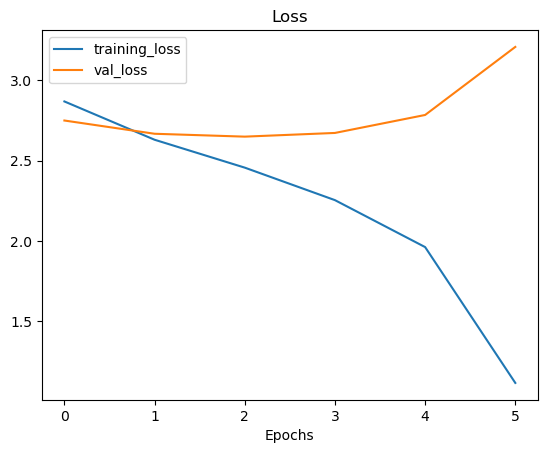

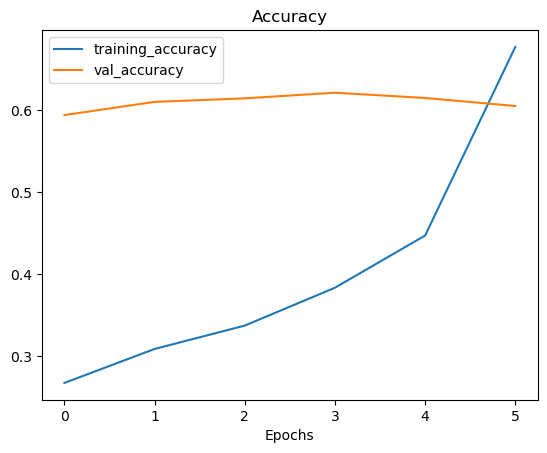

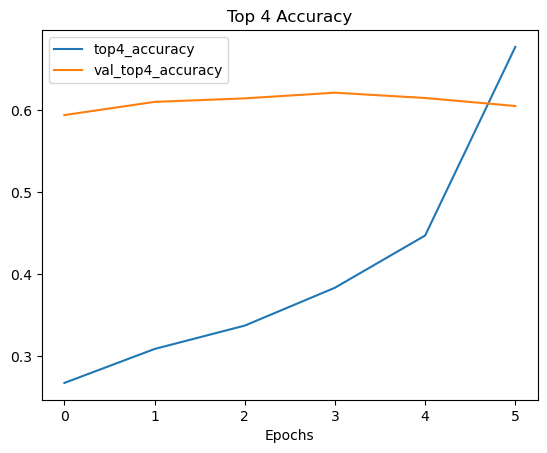

In [32]:
xception_1_history_genre_ft = fine_tune(xception_1_config)

### Genre | Xception | Learning from scratch

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_7[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]

 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, None, None, 728)      0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, None, None, 728)      536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, None, None, 728)      2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
          

 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, None, None, 728)      536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, None, None, 728)      2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, None, None, 728)      0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
          

 block9_sepconv3_bn (BatchN  (None, None, None, 728)      2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_19 (Add)                (None, None, None, 728)      0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_18[0][0]']              
                                                                                                  
 block10_sepconv1_act (Acti  (None, None, None, 728)      0         ['add_19[0][0]']              
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, None, None, 728)      536536    ['block10_sepconv1_act[0][0]']
 eConv2D) 

                                                                                                  
 block12_sepconv3_act (Acti  (None, None, None, 728)      0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, None, None, 728)      536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, None, None, 728)      2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_22 (A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 976s 927ms/step - loss: 3.0983 - accuracy: 0.2319 - top_2_accuracy: 0.3298 - top_3_accuracy: 0.4112 - top_4_accuracy: 0.4740 - ROC-AUC: 0.8547 - PR-AUC: 0.1355 - tp: 1820.0000 - fp: 3278.0000 - tn: 4153026.0000 - fn: 42396.0000 - precision: 0.3570 - recall: 0.0412 - f1_score: 0.0286 - val_loss: 2.9610 - val_accuracy: 0.2527 - val_top_2_accuracy: 0.3924 - val_top_3_accuracy: 0.4765 - val_top_4_accuracy: 0.5445 - val_ROC-AUC: 0.8963 - val_PR-AUC: 0.1922 - val_tp: 828.0000 - val_fp: 947.0000 - val_tn: 1032865.0000 - val_fn: 10170.0000 - val_precision: 0.4665 - val_recall: 0.0753 - val_f1_score: 0.0372
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8069 - accuracy: 0.2826 - top_2_accuracy: 0.4221 - top_3_accuracy: 0.5098 - top_4_accuracy: 0.5766 - ROC-AUC: 0.9071 - PR-AUC: 0.2299 - tp: 2049.0000 - fp: 1477.0000 - tn: 3116409.0000 - fn: 31120.0000 - precision: 0.5811 - recall: 0.0618 - f1_score: 0.0495INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 915s 882ms/step - loss: 2.8069 - accuracy: 0.2826 - top_2_accuracy: 0.4221 - top_3_accuracy: 0.5098 - top_4_accuracy: 0.5766 - ROC-AUC: 0.9071 - PR-AUC: 0.2299 - tp: 2049.0000 - fp: 1477.0000 - tn: 3116409.0000 - fn: 31120.0000 - precision: 0.5811 - recall: 0.0618 - f1_score: 0.0495 - val_loss: 2.8423 - val_accuracy: 0.2810 - val_top_2_accuracy: 0.4086 - val_top_3_accuracy: 0.4973 - val_top_4_accuracy: 0.5656 - val_ROC-AUC: 0.9045 - val_PR-AUC: 0.2264 - val_tp: 624.0000 - val_fp: 402.0000 - val_tn: 1033410.0000 - val_fn: 10374.0000 - val_precision: 0.6082 - val_recall: 0.0567 - val_f1_score: 0.0398
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 2.5963 - accuracy: 0.3237 - top_2_accuracy: 0.4679 - top_3_accuracy: 0.5590 - top_4_accuracy: 0.6239 - ROC-AUC: 0.9217 - PR-AUC: 0.2860 - tp: 2847.0000 - fp: 1516.0000 - tn: 3116370.0000 - fn: 30322.0000 - precision: 0.6525 - recall: 0.0858 - f1_score: 0.0709INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 917s 884ms/step - loss: 2.5963 - accuracy: 0.3237 - top_2_accuracy: 0.4679 - top_3_accuracy: 0.5590 - top_4_accuracy: 0.6239 - ROC-AUC: 0.9217 - PR-AUC: 0.2860 - tp: 2847.0000 - fp: 1516.0000 - tn: 3116370.0000 - fn: 30322.0000 - precision: 0.6525 - recall: 0.0858 - f1_score: 0.0709 - val_loss: 2.8330 - val_accuracy: 0.2731 - val_top_2_accuracy: 0.4238 - val_top_3_accuracy: 0.5130 - val_top_4_accuracy: 0.5826 - val_ROC-AUC: 0.9015 - val_PR-AUC: 0.2174 - val_tp: 820.0000 - val_fp: 908.0000 - val_tn: 1032904.0000 - val_fn: 10178.0000 - val_precision: 0.4745 - val_recall: 0.0746 - val_f1_score: 0.0475
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 2.3043 - accuracy: 0.3985 - top_2_accuracy: 0.5431 - top_3_accuracy: 0.6328 - top_4_accuracy: 0.6910 - ROC-AUC: 0.9393 - PR-AUC: 0.3787 - tp: 4396.0000 - fp: 1607.0000 - tn: 3116279.0000 - fn: 28773.0000 - precision: 0.7323 - recall: 0.1325 - f1_score: 0.1170INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 912s 878ms/step - loss: 2.3043 - accuracy: 0.3985 - top_2_accuracy: 0.5431 - top_3_accuracy: 0.6328 - top_4_accuracy: 0.6910 - ROC-AUC: 0.9393 - PR-AUC: 0.3787 - tp: 4396.0000 - fp: 1607.0000 - tn: 3116279.0000 - fn: 28773.0000 - precision: 0.7323 - recall: 0.1325 - f1_score: 0.1170 - val_loss: 2.8153 - val_accuracy: 0.2874 - val_top_2_accuracy: 0.4210 - val_top_3_accuracy: 0.5114 - val_top_4_accuracy: 0.5789 - val_ROC-AUC: 0.9015 - val_PR-AUC: 0.2374 - val_tp: 852.0000 - val_fp: 657.0000 - val_tn: 1033155.0000 - val_fn: 10146.0000 - val_precision: 0.5646 - val_recall: 0.0775 - val_f1_score: 0.0586
Epoch 5/100
1037/1037 [==============================] - 907s 874ms/step - loss: 1.8383 - accuracy: 0.5236 - top_2_accuracy: 0.6619 - top_3_accuracy: 0.7367 - top_4_accuracy: 0.7850 - ROC-AUC: 0.9638 - PR-AUC: 0.5490 - tp: 7772.0000 - fp: 1414.0000 - tn: 3116472.0000 - fn: 25397.0000 - precision: 0.8461 - recall: 0.2343 - f1_score: 0.2148 - val_lo

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/Xception_2/assets


344/344 [==============================] - 82s 238ms/step - loss: 3.1033 - accuracy: 0.2768 - top_2_accuracy: 0.4028 - top_3_accuracy: 0.4896 - top_4_accuracy: 0.5491 - ROC-AUC: 0.8694 - PR-AUC: 0.2181 - tp: 1636.0000 - fp: 2101.0000 - tn: 1031711.0000 - fn: 9362.0000 - precision: 0.4378 - recall: 0.1488 - f1_score: 0.0718
VALID:
 [3.103337287902832, 0.27677759528160095, 0.4028005003929138, 0.4896344840526581, 0.549099862575531, 0.8694419860839844, 0.2180703580379486, 1636.0, 2101.0, 1031711.0, 9362.0, 0.4377843141555786, 0.1487543135881424, 0.071775421500206]
346/346 [==============================] - 86s 248ms/step - loss: 4.3196 - accuracy: 0.1543 - top_2_accuracy: 0.2420 - top_3_accuracy: 0.3045 - top_4_accuracy: 0.3582 - ROC-AUC: 0.7623 - PR-AUC: 0.0829 - tp: 676.0000 - fp: 2433.0000 - tn: 1035985.0000 - fn: 10371.0000 - precision: 0.2174 - recall: 0.0612 - f1_score: 0.0325
TEST:
 [4.319646835327148, 0.15434055030345917, 0.2419661432504654, 0.30451706051826477, 0.35819679498672485

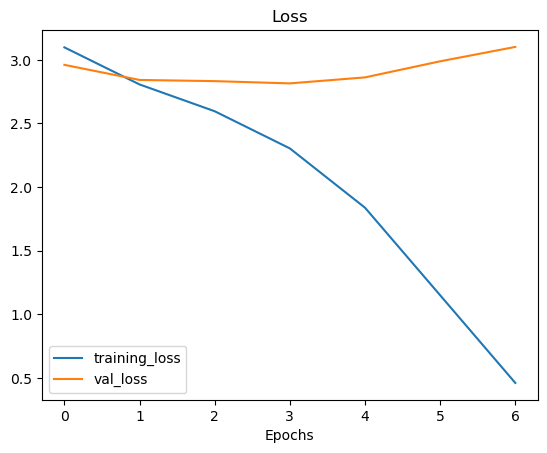

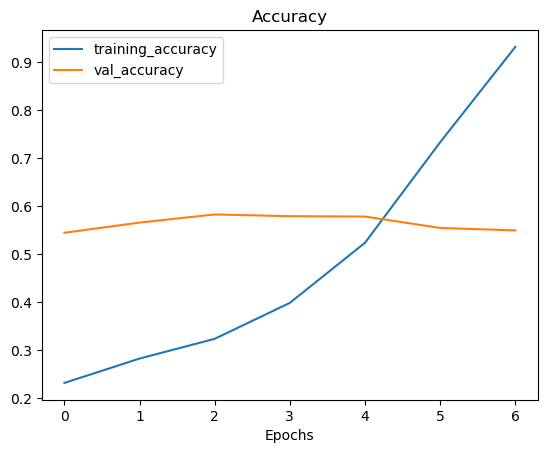

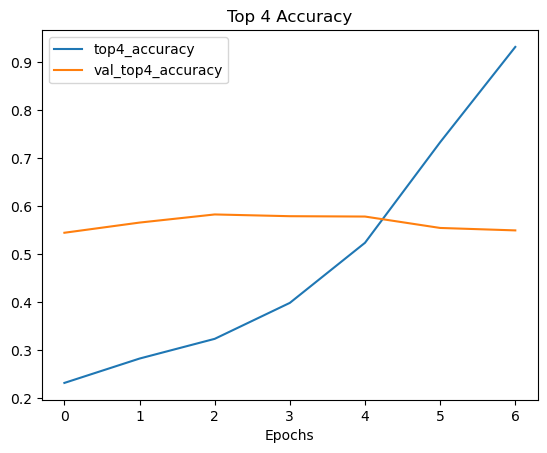

In [36]:
xception_2_history_genre = xception(xception_2_config)

## Genre | Densenet201
### Genre | Densenet201 | Transfer Learning

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, None, None, 160)      640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, None, None, 160)      0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, None, None, 128)      20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, None, None, 128)      512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, None, None, 160)      0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, None, None, 288)      0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, None, None, 256)      0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, None, None, 256)      1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, None, None, 256)      0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, None, None, 128)      32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, None, None, 384)      0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, None, None, 384)      1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, None, None, 384)      0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, None, None, 512)      0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, None, None, 512)      2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, None, None, 512)      0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, None, None, 640)      0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, None, None, 640)      2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, None, None, 640)      0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, None, None, 768)      0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, None, None, 768)      3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, None, None, 896)      0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, None, None, 896)      3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, None, None, 1024)     0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, None, None, 1024)     4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, None, None, 1152)     0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, None, None, 1280)     0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

 conv4_block36_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block36_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block36_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block36_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block36_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block36_concat (Conc  (None, None, None, 1408)     0         ['conv4_block35_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block40_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block40_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block40_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block40_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block40_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block40_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block44_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block44_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block44_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block44_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block44_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block44_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block48_1_conv (Conv  (None, None, None, 128)      225280    ['conv4_block48_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block48_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block48_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block48_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block48_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block48_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block48_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, None, None, 992)      0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, None, None, 992)      3968      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, None, None, 992)      0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
          

 conv5_block7_2_conv (Conv2  (None, None, None, 32)       36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, None, None, 1120)     0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, None, None, 1120)     4480      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, None, None, 1120)     0         ['conv5_block8_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block11_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, None, None, 1248)     0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, None, None, 1248)     4992      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, None, None, 1376)     0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, None, None, 1376)     5504      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block19_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, None, None, 1504)     0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, None, None, 1504)     6016      ['conv5_block19_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block23_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, None, None, 1632)     0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, None, None, 1760)     0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
          

 conv5_block31_1_bn (BatchN  (None, None, None, 128)      512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, None, None, 1888)     0         ['conv5_block30_concat[0][0]',
 atenate) 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 358s 339ms/step - loss: 3.5927 - accuracy: 0.1583 - top_2_accuracy: 0.2667 - top_3_accuracy: 0.3437 - top_4_accuracy: 0.4046 - ROC-AUC: 0.8299 - PR-AUC: 0.0998 - tp: 594.0000 - fp: 1383.0000 - tn: 3116503.0000 - fn: 32575.0000 - precision: 0.3005 - recall: 0.0179 - f1_score: 0.0164 - val_loss: 3.3041 - val_accuracy: 0.1937 - val_top_2_accuracy: 0.3247 - val_top_3_accuracy: 0.4031 - val_top_4_accuracy: 0.4630 - val_ROC-AUC: 0.8594 - val_PR-AUC: 0.1355 - val_tp: 309.0000 - val_fp: 454.0000 - val_tn: 1033358.0000 - val_fn: 10689.0000 - val_precision: 0.4050 - val_recall: 0.0281 - val_f1_score: 0.0205
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 3.2006 - accuracy: 0.2138 - top_2_accuracy: 0.3380 - top_3_accuracy: 0.4225 - top_4_accuracy: 0.4878 - ROC-AUC: 0.8707 - PR-AUC: 0.1525 - tp: 1129.0000 - fp: 1422.0000 - tn: 3116464.0000 - fn: 32040.0000 - precision: 0.4426 - recall: 0.0340 - f1_score: 0.0274INFO:tensorflow:As

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 343s 330ms/step - loss: 3.2006 - accuracy: 0.2138 - top_2_accuracy: 0.3380 - top_3_accuracy: 0.4225 - top_4_accuracy: 0.4878 - ROC-AUC: 0.8707 - PR-AUC: 0.1525 - tp: 1129.0000 - fp: 1422.0000 - tn: 3116464.0000 - fn: 32040.0000 - precision: 0.4426 - recall: 0.0340 - f1_score: 0.0274 - val_loss: 3.1579 - val_accuracy: 0.2180 - val_top_2_accuracy: 0.3503 - val_top_3_accuracy: 0.4353 - val_top_4_accuracy: 0.5028 - val_ROC-AUC: 0.8741 - val_PR-AUC: 0.1649 - val_tp: 488.0000 - val_fp: 523.0000 - val_tn: 1033289.0000 - val_fn: 10510.0000 - val_precision: 0.4827 - val_recall: 0.0444 - val_f1_score: 0.0272
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 3.0551 - accuracy: 0.2337 - top_2_accuracy: 0.3651 - top_3_accuracy: 0.4545 - top_4_accuracy: 0.5194 - ROC-AUC: 0.8858 - PR-AUC: 0.1757 - tp: 1390.0000 - fp: 1376.0000 - tn: 3116510.0000 - fn: 31779.0000 - precision: 0.5025 - recall: 0.0419 - f1_score: 0.0351INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 343s 330ms/step - loss: 3.0551 - accuracy: 0.2337 - top_2_accuracy: 0.3651 - top_3_accuracy: 0.4545 - top_4_accuracy: 0.5194 - ROC-AUC: 0.8858 - PR-AUC: 0.1757 - tp: 1390.0000 - fp: 1376.0000 - tn: 3116510.0000 - fn: 31779.0000 - precision: 0.5025 - recall: 0.0419 - f1_score: 0.0351 - val_loss: 3.0844 - val_accuracy: 0.2327 - val_top_2_accuracy: 0.3619 - val_top_3_accuracy: 0.4547 - val_top_4_accuracy: 0.5186 - val_ROC-AUC: 0.8802 - val_PR-AUC: 0.1754 - val_tp: 498.0000 - val_fp: 464.0000 - val_tn: 1033348.0000 - val_fn: 10500.0000 - val_precision: 0.5177 - val_recall: 0.0453 - val_f1_score: 0.0334
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9648 - accuracy: 0.2492 - top_2_accuracy: 0.3821 - top_3_accuracy: 0.4708 - top_4_accuracy: 0.5370 - ROC-AUC: 0.8953 - PR-AUC: 0.1916 - tp: 1506.0000 - fp: 1343.0000 - tn: 3116543.0000 - fn: 31663.0000 - precision: 0.5286 - recall: 0.0454 - f1_score: 0.0411INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 343s 330ms/step - loss: 2.9648 - accuracy: 0.2492 - top_2_accuracy: 0.3821 - top_3_accuracy: 0.4708 - top_4_accuracy: 0.5370 - ROC-AUC: 0.8953 - PR-AUC: 0.1916 - tp: 1506.0000 - fp: 1343.0000 - tn: 3116543.0000 - fn: 31663.0000 - precision: 0.5286 - recall: 0.0454 - f1_score: 0.0411 - val_loss: 3.0288 - val_accuracy: 0.2427 - val_top_2_accuracy: 0.3795 - val_top_3_accuracy: 0.4680 - val_top_4_accuracy: 0.5330 - val_ROC-AUC: 0.8848 - val_PR-AUC: 0.1849 - val_tp: 452.0000 - val_fp: 389.0000 - val_tn: 1033423.0000 - val_fn: 10546.0000 - val_precision: 0.5375 - val_recall: 0.0411 - val_f1_score: 0.0405
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8929 - accuracy: 0.2602 - top_2_accuracy: 0.3962 - top_3_accuracy: 0.4841 - top_4_accuracy: 0.5529 - ROC-AUC: 0.9024 - PR-AUC: 0.2042 - tp: 1681.0000 - fp: 1333.0000 - tn: 3116553.0000 - fn: 31488.0000 - precision: 0.5577 - recall: 0.0507 - f1_score: 0.0480INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 341s 329ms/step - loss: 2.8929 - accuracy: 0.2602 - top_2_accuracy: 0.3962 - top_3_accuracy: 0.4841 - top_4_accuracy: 0.5529 - ROC-AUC: 0.9024 - PR-AUC: 0.2042 - tp: 1681.0000 - fp: 1333.0000 - tn: 3116553.0000 - fn: 31488.0000 - precision: 0.5577 - recall: 0.0507 - f1_score: 0.0480 - val_loss: 2.9991 - val_accuracy: 0.2512 - val_top_2_accuracy: 0.3792 - val_top_3_accuracy: 0.4760 - val_top_4_accuracy: 0.5370 - val_ROC-AUC: 0.8879 - val_PR-AUC: 0.1939 - val_tp: 553.0000 - val_fp: 457.0000 - val_tn: 1033355.0000 - val_fn: 10445.0000 - val_precision: 0.5475 - val_recall: 0.0503 - val_f1_score: 0.0418
Epoch 6/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8350 - accuracy: 0.2673 - top_2_accuracy: 0.4071 - top_3_accuracy: 0.4984 - top_4_accuracy: 0.5649 - ROC-AUC: 0.9081 - PR-AUC: 0.2149 - tp: 1750.0000 - fp: 1280.0000 - tn: 3116606.0000 - fn: 31419.0000 - precision: 0.5776 - recall: 0.0528 - f1_score: 0.0527INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 342s 329ms/step - loss: 2.8350 - accuracy: 0.2673 - top_2_accuracy: 0.4071 - top_3_accuracy: 0.4984 - top_4_accuracy: 0.5649 - ROC-AUC: 0.9081 - PR-AUC: 0.2149 - tp: 1750.0000 - fp: 1280.0000 - tn: 3116606.0000 - fn: 31419.0000 - precision: 0.5776 - recall: 0.0528 - f1_score: 0.0527 - val_loss: 2.9884 - val_accuracy: 0.2558 - val_top_2_accuracy: 0.3939 - val_top_3_accuracy: 0.4760 - val_top_4_accuracy: 0.5403 - val_ROC-AUC: 0.8880 - val_PR-AUC: 0.2001 - val_tp: 718.0000 - val_fp: 662.0000 - val_tn: 1033150.0000 - val_fn: 10280.0000 - val_precision: 0.5203 - val_recall: 0.0653 - val_f1_score: 0.0414
Epoch 7/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7875 - accuracy: 0.2727 - top_2_accuracy: 0.4148 - top_3_accuracy: 0.5063 - top_4_accuracy: 0.5732 - ROC-AUC: 0.9124 - PR-AUC: 0.2241 - tp: 1836.0000 - fp: 1272.0000 - tn: 3116614.0000 - fn: 31333.0000 - precision: 0.5907 - recall: 0.0554 - f1_score: 0.0583INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 342s 329ms/step - loss: 2.7875 - accuracy: 0.2727 - top_2_accuracy: 0.4148 - top_3_accuracy: 0.5063 - top_4_accuracy: 0.5732 - ROC-AUC: 0.9124 - PR-AUC: 0.2241 - tp: 1836.0000 - fp: 1272.0000 - tn: 3116614.0000 - fn: 31333.0000 - precision: 0.5907 - recall: 0.0554 - f1_score: 0.0583 - val_loss: 2.9561 - val_accuracy: 0.2548 - val_top_2_accuracy: 0.3943 - val_top_3_accuracy: 0.4844 - val_top_4_accuracy: 0.5507 - val_ROC-AUC: 0.8898 - val_PR-AUC: 0.1996 - val_tp: 514.0000 - val_fp: 440.0000 - val_tn: 1033372.0000 - val_fn: 10484.0000 - val_precision: 0.5388 - val_recall: 0.0467 - val_f1_score: 0.0451
Epoch 8/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7468 - accuracy: 0.2798 - top_2_accuracy: 0.4201 - top_3_accuracy: 0.5140 - top_4_accuracy: 0.5828 - ROC-AUC: 0.9162 - PR-AUC: 0.2317 - tp: 1898.0000 - fp: 1285.0000 - tn: 3116601.0000 - fn: 31271.0000 - precision: 0.5963 - recall: 0.0572 - f1_score: 0.0653INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 343s 330ms/step - loss: 2.7468 - accuracy: 0.2798 - top_2_accuracy: 0.4201 - top_3_accuracy: 0.5140 - top_4_accuracy: 0.5828 - ROC-AUC: 0.9162 - PR-AUC: 0.2317 - tp: 1898.0000 - fp: 1285.0000 - tn: 3116601.0000 - fn: 31271.0000 - precision: 0.5963 - recall: 0.0572 - f1_score: 0.0653 - val_loss: 2.9284 - val_accuracy: 0.2572 - val_top_2_accuracy: 0.3967 - val_top_3_accuracy: 0.4904 - val_top_4_accuracy: 0.5576 - val_ROC-AUC: 0.8952 - val_PR-AUC: 0.2069 - val_tp: 543.0000 - val_fp: 380.0000 - val_tn: 1033432.0000 - val_fn: 10455.0000 - val_precision: 0.5883 - val_recall: 0.0494 - val_f1_score: 0.0491
Epoch 9/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7082 - accuracy: 0.2862 - top_2_accuracy: 0.4295 - top_3_accuracy: 0.5233 - top_4_accuracy: 0.5893 - ROC-AUC: 0.9201 - PR-AUC: 0.2393 - tp: 1982.0000 - fp: 1267.0000 - tn: 3116619.0000 - fn: 31187.0000 - precision: 0.6100 - recall: 0.0598 - f1_score: 0.0781INFO:tensorflow:A

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 343s 330ms/step - loss: 2.7082 - accuracy: 0.2862 - top_2_accuracy: 0.4295 - top_3_accuracy: 0.5233 - top_4_accuracy: 0.5893 - ROC-AUC: 0.9201 - PR-AUC: 0.2393 - tp: 1982.0000 - fp: 1267.0000 - tn: 3116619.0000 - fn: 31187.0000 - precision: 0.6100 - recall: 0.0598 - f1_score: 0.0781 - val_loss: 2.9243 - val_accuracy: 0.2559 - val_top_2_accuracy: 0.3992 - val_top_3_accuracy: 0.4858 - val_top_4_accuracy: 0.5542 - val_ROC-AUC: 0.8958 - val_PR-AUC: 0.2067 - val_tp: 526.0000 - val_fp: 383.0000 - val_tn: 1033429.0000 - val_fn: 10472.0000 - val_precision: 0.5787 - val_recall: 0.0478 - val_f1_score: 0.0506
Epoch 10/100
1037/1037 [==============================] - 322s 310ms/step - loss: 2.6733 - accuracy: 0.2936 - top_2_accuracy: 0.4350 - top_3_accuracy: 0.5300 - top_4_accuracy: 0.5995 - ROC-AUC: 0.9231 - PR-AUC: 0.2467 - tp: 2020.0000 - fp: 1229.0000 - tn: 3116657.0000 - fn: 31149.0000 - precision: 0.6217 - recall: 0.0609 - f1_score: 0.0863 - val_l

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 342s 329ms/step - loss: 2.6451 - accuracy: 0.2960 - top_2_accuracy: 0.4415 - top_3_accuracy: 0.5350 - top_4_accuracy: 0.6042 - ROC-AUC: 0.9260 - PR-AUC: 0.2519 - tp: 2124.0000 - fp: 1236.0000 - tn: 3116650.0000 - fn: 31045.0000 - precision: 0.6321 - recall: 0.0640 - f1_score: 0.0926 - val_loss: 2.8949 - val_accuracy: 0.2681 - val_top_2_accuracy: 0.4071 - val_top_3_accuracy: 0.4993 - val_top_4_accuracy: 0.5626 - val_ROC-AUC: 0.8971 - val_PR-AUC: 0.2128 - val_tp: 484.0000 - val_fp: 365.0000 - val_tn: 1033447.0000 - val_fn: 10514.0000 - val_precision: 0.5701 - val_recall: 0.0440 - val_f1_score: 0.0555
Epoch 12/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6167 - accuracy: 0.3007 - top_2_accuracy: 0.4472 - top_3_accuracy: 0.5420 - top_4_accuracy: 0.6128 - ROC-AUC: 0.9285 - PR-AUC: 0.2577 - tp: 2147.0000 - fp: 1208.0000 - tn: 3116678.0000 - fn: 31022.0000 - precision: 0.6399 - recall: 0.0647 - f1_score: 0.1041INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 342s 329ms/step - loss: 2.6167 - accuracy: 0.3007 - top_2_accuracy: 0.4472 - top_3_accuracy: 0.5420 - top_4_accuracy: 0.6128 - ROC-AUC: 0.9285 - PR-AUC: 0.2577 - tp: 2147.0000 - fp: 1208.0000 - tn: 3116678.0000 - fn: 31022.0000 - precision: 0.6399 - recall: 0.0647 - f1_score: 0.1041 - val_loss: 2.8898 - val_accuracy: 0.2675 - val_top_2_accuracy: 0.4098 - val_top_3_accuracy: 0.5005 - val_top_4_accuracy: 0.5644 - val_ROC-AUC: 0.8970 - val_PR-AUC: 0.2183 - val_tp: 615.0000 - val_fp: 451.0000 - val_tn: 1033361.0000 - val_fn: 10383.0000 - val_precision: 0.5769 - val_recall: 0.0559 - val_f1_score: 0.0568
Epoch 13/100
1037/1037 [==============================] - 322s 310ms/step - loss: 2.5910 - accuracy: 0.3029 - top_2_accuracy: 0.4511 - top_3_accuracy: 0.5482 - top_4_accuracy: 0.6155 - ROC-AUC: 0.9303 - PR-AUC: 0.2630 - tp: 2190.0000 - fp: 1201.0000 - tn: 3116685.0000 - fn: 30979.0000 - precision: 0.6458 - recall: 0.0660 - f1_score: 0.1207 - val_l

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 341s 329ms/step - loss: 2.5672 - accuracy: 0.3060 - top_2_accuracy: 0.4559 - top_3_accuracy: 0.5516 - top_4_accuracy: 0.6221 - ROC-AUC: 0.9330 - PR-AUC: 0.2679 - tp: 2251.0000 - fp: 1219.0000 - tn: 3116667.0000 - fn: 30918.0000 - precision: 0.6487 - recall: 0.0679 - f1_score: 0.1363 - val_loss: 2.8796 - val_accuracy: 0.2700 - val_top_2_accuracy: 0.4158 - val_top_3_accuracy: 0.5027 - val_top_4_accuracy: 0.5696 - val_ROC-AUC: 0.8963 - val_PR-AUC: 0.2213 - val_tp: 767.0000 - val_fp: 554.0000 - val_tn: 1033258.0000 - val_fn: 10231.0000 - val_precision: 0.5806 - val_recall: 0.0697 - val_f1_score: 0.0584
Epoch 15/100
1037/1037 [==============================] - ETA: 0s - loss: 2.5436 - accuracy: 0.3115 - top_2_accuracy: 0.4614 - top_3_accuracy: 0.5580 - top_4_accuracy: 0.6269 - ROC-AUC: 0.9344 - PR-AUC: 0.2729 - tp: 2288.0000 - fp: 1182.0000 - tn: 3116704.0000 - fn: 30881.0000 - precision: 0.6594 - recall: 0.0690 - f1_score: 0.1438INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 341s 328ms/step - loss: 2.5436 - accuracy: 0.3115 - top_2_accuracy: 0.4614 - top_3_accuracy: 0.5580 - top_4_accuracy: 0.6269 - ROC-AUC: 0.9344 - PR-AUC: 0.2729 - tp: 2288.0000 - fp: 1182.0000 - tn: 3116704.0000 - fn: 30881.0000 - precision: 0.6594 - recall: 0.0690 - f1_score: 0.1438 - val_loss: 2.8753 - val_accuracy: 0.2755 - val_top_2_accuracy: 0.4136 - val_top_3_accuracy: 0.5009 - val_top_4_accuracy: 0.5656 - val_ROC-AUC: 0.8982 - val_PR-AUC: 0.2210 - val_tp: 684.0000 - val_fp: 505.0000 - val_tn: 1033307.0000 - val_fn: 10314.0000 - val_precision: 0.5753 - val_recall: 0.0622 - val_f1_score: 0.0614
Epoch 16/100
1037/1037 [==============================] - 323s 311ms/step - loss: 2.5221 - accuracy: 0.3158 - top_2_accuracy: 0.4637 - top_3_accuracy: 0.5612 - top_4_accuracy: 0.6333 - ROC-AUC: 0.9361 - PR-AUC: 0.2781 - tp: 2355.0000 - fp: 1220.0000 - tn: 3116666.0000 - fn: 30814.0000 - precision: 0.6587 - recall: 0.0710 - f1_score: 0.1565 - val_l

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 352s 339ms/step - loss: 2.4842 - accuracy: 0.3193 - top_2_accuracy: 0.4706 - top_3_accuracy: 0.5702 - top_4_accuracy: 0.6419 - ROC-AUC: 0.9392 - PR-AUC: 0.2865 - tp: 2505.0000 - fp: 1245.0000 - tn: 3116641.0000 - fn: 30664.0000 - precision: 0.6680 - recall: 0.0755 - f1_score: 0.1804 - val_loss: 2.8713 - val_accuracy: 0.2727 - val_top_2_accuracy: 0.4153 - val_top_3_accuracy: 0.5055 - val_top_4_accuracy: 0.5710 - val_ROC-AUC: 0.8977 - val_PR-AUC: 0.2223 - val_tp: 667.0000 - val_fp: 458.0000 - val_tn: 1033354.0000 - val_fn: 10331.0000 - val_precision: 0.5929 - val_recall: 0.0606 - val_f1_score: 0.0652
Epoch 19/100
1037/1037 [==============================] - ETA: 0s - loss: 2.4662 - accuracy: 0.3238 - top_2_accuracy: 0.4783 - top_3_accuracy: 0.5772 - top_4_accuracy: 0.6475 - ROC-AUC: 0.9406 - PR-AUC: 0.2900 - tp: 2463.0000 - fp: 1214.0000 - tn: 3116672.0000 - fn: 30706.0000 - precision: 0.6698 - recall: 0.0743 - f1_score: 0.1978INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 346s 333ms/step - loss: 2.4662 - accuracy: 0.3238 - top_2_accuracy: 0.4783 - top_3_accuracy: 0.5772 - top_4_accuracy: 0.6475 - ROC-AUC: 0.9406 - PR-AUC: 0.2900 - tp: 2463.0000 - fp: 1214.0000 - tn: 3116672.0000 - fn: 30706.0000 - precision: 0.6698 - recall: 0.0743 - f1_score: 0.1978 - val_loss: 2.8669 - val_accuracy: 0.2730 - val_top_2_accuracy: 0.4138 - val_top_3_accuracy: 0.5088 - val_top_4_accuracy: 0.5711 - val_ROC-AUC: 0.8978 - val_PR-AUC: 0.2212 - val_tp: 660.0000 - val_fp: 469.0000 - val_tn: 1033343.0000 - val_fn: 10338.0000 - val_precision: 0.5846 - val_recall: 0.0600 - val_f1_score: 0.0652
Epoch 20/100
1037/1037 [==============================] - ETA: 0s - loss: 2.4491 - accuracy: 0.3273 - top_2_accuracy: 0.4798 - top_3_accuracy: 0.5799 - top_4_accuracy: 0.6505 - ROC-AUC: 0.9414 - PR-AUC: 0.2938 - tp: 2531.0000 - fp: 1274.0000 - tn: 3116612.0000 - fn: 30638.0000 - precision: 0.6652 - recall: 0.0763 - f1_score: 0.2092INFO:tensorflow:

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 343s 330ms/step - loss: 2.4491 - accuracy: 0.3273 - top_2_accuracy: 0.4798 - top_3_accuracy: 0.5799 - top_4_accuracy: 0.6505 - ROC-AUC: 0.9414 - PR-AUC: 0.2938 - tp: 2531.0000 - fp: 1274.0000 - tn: 3116612.0000 - fn: 30638.0000 - precision: 0.6652 - recall: 0.0763 - f1_score: 0.2092 - val_loss: 2.8599 - val_accuracy: 0.2761 - val_top_2_accuracy: 0.4166 - val_top_3_accuracy: 0.5037 - val_top_4_accuracy: 0.5683 - val_ROC-AUC: 0.9009 - val_PR-AUC: 0.2247 - val_tp: 611.0000 - val_fp: 427.0000 - val_tn: 1033385.0000 - val_fn: 10387.0000 - val_precision: 0.5886 - val_recall: 0.0556 - val_f1_score: 0.0666
Epoch 21/100
1037/1037 [==============================] - 323s 311ms/step - loss: 2.4333 - accuracy: 0.3283 - top_2_accuracy: 0.4822 - top_3_accuracy: 0.5826 - top_4_accuracy: 0.6554 - ROC-AUC: 0.9428 - PR-AUC: 0.2985 - tp: 2570.0000 - fp: 1265.0000 - tn: 3116621.0000 - fn: 30599.0000 - precision: 0.6701 - recall: 0.0775 - f1_score: 0.2207 - val_l

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL/assets


344/344 [==============================] - 81s 234ms/step - loss: 2.8692 - accuracy: 0.2748 - top_2_accuracy: 0.4181 - top_3_accuracy: 0.5071 - top_4_accuracy: 0.5686 - ROC-AUC: 0.8973 - PR-AUC: 0.2231 - tp: 720.0000 - fp: 546.0000 - tn: 1033266.0000 - fn: 10278.0000 - precision: 0.5687 - recall: 0.0655 - f1_score: 0.0685
VALID:
 [2.8691508769989014, 0.27477723360061646, 0.4180760085582733, 0.5070921778678894, 0.5685579180717468, 0.8973383903503418, 0.22305724024772644, 720.0, 546.0, 1033266.0, 10278.0, 0.5687204003334045, 0.06546644866466522, 0.06846502423286438]
346/346 [==============================] - 86s 247ms/step - loss: 2.8712 - accuracy: 0.2737 - top_2_accuracy: 0.4121 - top_3_accuracy: 0.5048 - top_4_accuracy: 0.5707 - ROC-AUC: 0.8995 - PR-AUC: 0.2192 - tp: 720.0000 - fp: 556.0000 - tn: 1037862.0000 - fn: 10327.0000 - precision: 0.5643 - recall: 0.0652 - f1_score: 0.0661
TEST:
 [2.8712246417999268, 0.2737394869327545, 0.4121480882167816, 0.5047523975372314, 0.570652663707733

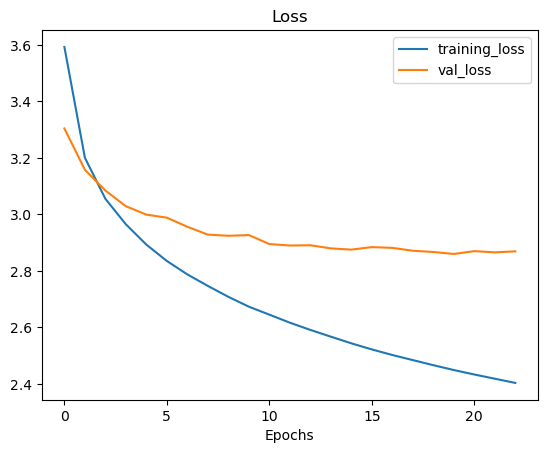

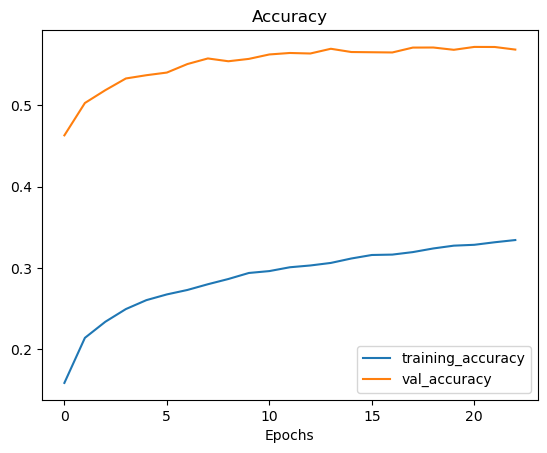

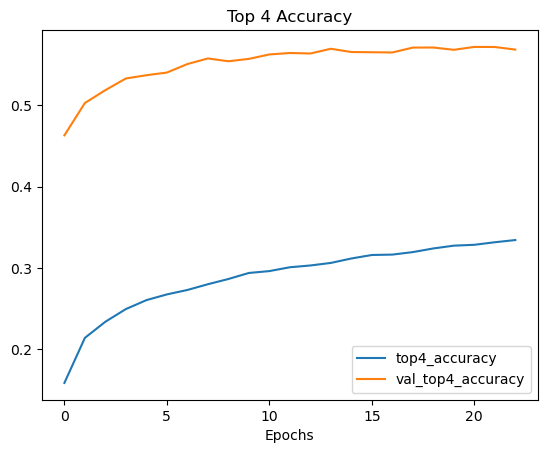

In [24]:
densenet_1_history_genre = densenet(densenet_1_config) # 0.0001

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920   18321984  
                             )                                   
                                                                 
 pooling_layer (GlobalMaxPo  (None, 1920)              0         
 oling2D)                                                        
                                                                 
 dense (Dense)               (None, 95)                182495    
                                                                 
 activation (Activation)     (None, 95)                0         
                                                                 
Total params: 18504479 (70.59 MB)
Trainable params: 18275423 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1404s 1s/step - loss: 2.9875 - accuracy: 0.2504 - top_2_accuracy: 0.4021 - top_3_accuracy: 0.4891 - top_4_accuracy: 0.5552 - ROC-AUC: 0.8883 - PR-AUC: 0.2071 - tp: 3568.0000 - fp: 4037.0000 - tn: 4152267.0000 - fn: 40648.0000 - precision: 0.4692 - recall: 0.0807 - f1_score: 0.0700 - val_loss: 2.8335 - val_accuracy: 0.2818 - val_top_2_accuracy: 0.4155 - val_top_3_accuracy: 0.5075 - val_top_4_accuracy: 0.5731 - val_ROC-AUC: 0.9035 - val_PR-AUC: 0.2259 - val_tp: 344.0000 - val_fp: 155.0000 - val_tn: 1033657.0000 - val_fn: 10654.0000 - val_precision: 0.6894 - val_recall: 0.0313 - val_f1_score: 0.0342 - lr: 1.0000e-04
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7619 - accuracy: 0.2878 - top_2_accuracy: 0.4296 - top_3_accuracy: 0.5205 - top_4_accuracy: 0.5881 - ROC-AUC: 0.9117 - PR-AUC: 0.2411 - tp: 1965.0000 - fp: 1129.0000 - tn: 3116757.0000 - fn: 31204.0000 - precision: 0.6351 - recall: 0.0592 - f1_score: 0.0419IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1324s 1s/step - loss: 2.7619 - accuracy: 0.2878 - top_2_accuracy: 0.4296 - top_3_accuracy: 0.5205 - top_4_accuracy: 0.5881 - ROC-AUC: 0.9117 - PR-AUC: 0.2411 - tp: 1965.0000 - fp: 1129.0000 - tn: 3116757.0000 - fn: 31204.0000 - precision: 0.6351 - recall: 0.0592 - f1_score: 0.0419 - val_loss: 2.7624 - val_accuracy: 0.2899 - val_top_2_accuracy: 0.4287 - val_top_3_accuracy: 0.5177 - val_top_4_accuracy: 0.5835 - val_ROC-AUC: 0.9126 - val_PR-AUC: 0.2428 - val_tp: 464.0000 - val_fp: 200.0000 - val_tn: 1033612.0000 - val_fn: 10534.0000 - val_precision: 0.6988 - val_recall: 0.0422 - val_f1_score: 0.0428 - lr: 1.0000e-04
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6574 - accuracy: 0.3052 - top_2_accuracy: 0.4517 - top_3_accuracy: 0.5435 - top_4_accuracy: 0.6111 - ROC-AUC: 0.9200 - PR-AUC: 0.2640 - tp: 2374.0000 - fp: 1280.0000 - tn: 3116606.0000 - fn: 30795.0000 - precision: 0.6497 - recall: 0.0716 - f1_score: 0.0523IN

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1258s 1s/step - loss: 2.6574 - accuracy: 0.3052 - top_2_accuracy: 0.4517 - top_3_accuracy: 0.5435 - top_4_accuracy: 0.6111 - ROC-AUC: 0.9200 - PR-AUC: 0.2640 - tp: 2374.0000 - fp: 1280.0000 - tn: 3116606.0000 - fn: 30795.0000 - precision: 0.6497 - recall: 0.0716 - f1_score: 0.0523 - val_loss: 2.6643 - val_accuracy: 0.3073 - val_top_2_accuracy: 0.4524 - val_top_3_accuracy: 0.5500 - val_top_4_accuracy: 0.6137 - val_ROC-AUC: 0.9190 - val_PR-AUC: 0.2663 - val_tp: 714.0000 - val_fp: 352.0000 - val_tn: 1033460.0000 - val_fn: 10284.0000 - val_precision: 0.6698 - val_recall: 0.0649 - val_f1_score: 0.0559 - lr: 1.0000e-04
Epoch 4/100
1037/1037 [==============================] - 1189s 1s/step - loss: 2.5648 - accuracy: 0.3223 - top_2_accuracy: 0.4700 - top_3_accuracy: 0.5640 - top_4_accuracy: 0.6303 - ROC-AUC: 0.9262 - PR-AUC: 0.2878 - tp: 2817.0000 - fp: 1454.0000 - tn: 3116432.0000 - fn: 30352.0000 - precision: 0.6596 - recall: 0.0849 - f1_score: 0.

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1216s 1s/step - loss: 2.1571 - accuracy: 0.4108 - top_2_accuracy: 0.5653 - top_3_accuracy: 0.6556 - top_4_accuracy: 0.7175 - ROC-AUC: 0.9498 - PR-AUC: 0.4076 - tp: 5198.0000 - fp: 1864.0000 - tn: 3116022.0000 - fn: 27971.0000 - precision: 0.7361 - recall: 0.1567 - f1_score: 0.1439 - val_loss: 2.5997 - val_accuracy: 0.3362 - val_top_2_accuracy: 0.4810 - val_top_3_accuracy: 0.5728 - val_top_4_accuracy: 0.6367 - val_ROC-AUC: 0.9144 - val_PR-AUC: 0.2951 - val_tp: 1392.0000 - val_fp: 1043.0000 - val_tn: 1032769.0000 - val_fn: 9606.0000 - val_precision: 0.5717 - val_recall: 0.1266 - val_f1_score: 0.0985 - lr: 2.0000e-05
Epoch 7/100
1037/1037 [==============================] - 1137s 1s/step - loss: 1.9866 - accuracy: 0.4484 - top_2_accuracy: 0.6041 - top_3_accuracy: 0.6939 - top_4_accuracy: 0.7532 - ROC-AUC: 0.9580 - PR-AUC: 0.4614 - tp: 6574.0000 - fp: 2081.0000 - tn: 3115805.0000 - fn: 26595.0000 - precision: 0.7596 - recall: 0.1982 - f1_score: 0

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_1_TL_FT/assets


344/344 [==============================] - 113s 325ms/step - loss: 2.7939 - accuracy: 0.3218 - top_2_accuracy: 0.4674 - top_3_accuracy: 0.5588 - top_4_accuracy: 0.6198 - ROC-AUC: 0.8963 - PR-AUC: 0.2849 - tp: 1870.0000 - fp: 1923.0000 - tn: 1031889.0000 - fn: 9128.0000 - precision: 0.4930 - recall: 0.1700 - f1_score: 0.1117
VALID:
 [2.793900489807129, 0.3217857778072357, 0.4674486219882965, 0.5588288903236389, 0.6198399662971497, 0.8963247537612915, 0.28493815660476685, 1870.0, 1923.0, 1031889.0, 9128.0, 0.4930134415626526, 0.17003092169761658, 0.11168250441551208]
346/346 [==============================] - 121s 351ms/step - loss: 2.7430 - accuracy: 0.3204 - top_2_accuracy: 0.4675 - top_3_accuracy: 0.5621 - top_4_accuracy: 0.6261 - ROC-AUC: 0.9021 - PR-AUC: 0.2886 - tp: 1879.0000 - fp: 1873.0000 - tn: 1036545.0000 - fn: 9168.0000 - precision: 0.5008 - recall: 0.1701 - f1_score: 0.1190
TEST:
 [2.743025779724121, 0.3203584551811218, 0.467547744512558, 0.5621435642242432, 0.62605232000350

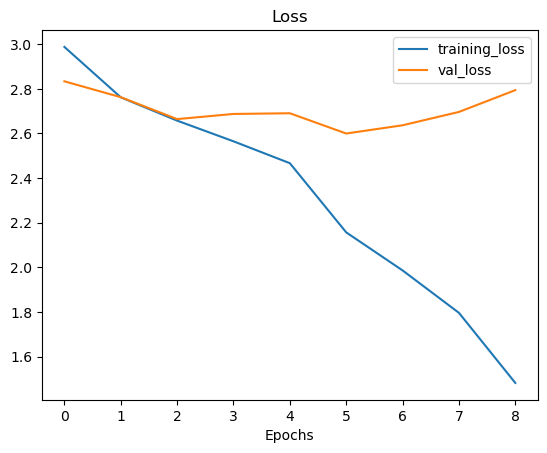

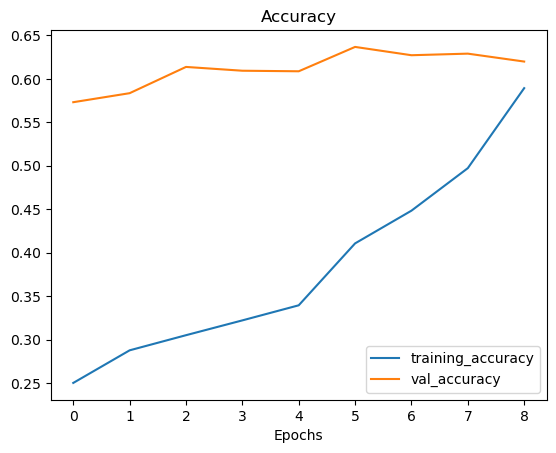

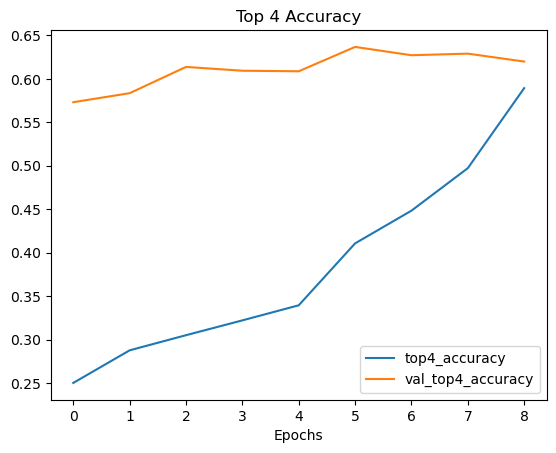

In [33]:
densenet_1_history_genre_ft = fine_tune(densenet_1_config) # 0.0001

In [ ]:
test_best_model(densenet_1_config)

 20/346 [>.............................] - ETA: 10:34 - loss: 3.8371 - accuracy: 0.0641 - top_2_accuracy: 0.1359 - top_3_accuracy: 0.1953 - top_4_accuracy: 0.2594 - ROC-AUC: 0.8269 - PR-AUC: 0.0503 - tp: 0.0000e+00 - fp: 17.0000 - tn: 60143.0000 - fn: 640.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0046

### Genre | Densenet201 | Learning from scratch

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, None, None, 3)        0         ['input_8[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, None, None, 160)      640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, None, None, 160)      0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, None, None, 128)      20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, None, None, 128)      512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, None, None, 160)      0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, None, None, 288)      0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, None, None, 128)      512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, None, None, 128)      0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, None, None, 32)       36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, None, None, 256)      0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, None, None, 256)      1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, None, None, 256)      0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, None, None, 128)      32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, None, None, 384)      0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, None, None, 384)      1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, None, None, 384)      0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, None, None, 512)      0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, None, None, 512)      2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, None, None, 512)      0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, None, None, 640)      0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, None, None, 640)      2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, None, None, 640)      0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, None, None, 768)      0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, None, None, 768)      3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, None, None, 896)      0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, None, None, 896)      3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, None, None, 1024)     0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, None, None, 1024)     4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, None, None, 1152)     0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, None, None, 1280)     0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

 conv4_block36_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block36_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block36_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block36_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block36_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block36_concat (Conc  (None, None, None, 1408)     0         ['conv4_block35_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block40_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block40_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block40_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block40_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block40_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block40_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block44_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block44_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block44_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block44_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block44_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block44_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block48_1_conv (Conv  (None, None, None, 128)      225280    ['conv4_block48_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block48_1_bn (BatchN  (None, None, None, 128)      512       ['conv4_block48_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block48_1_relu (Acti  (None, None, None, 128)      0         ['conv4_block48_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block48_2_conv (Conv  (None, None, None, 32)       36864     ['conv4_block48_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, None, None, 992)      0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, None, None, 992)      3968      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, None, None, 992)      0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
          

 conv5_block7_2_conv (Conv2  (None, None, None, 32)       36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, None, None, 1120)     0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, None, None, 1120)     4480      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, None, None, 1120)     0         ['conv5_block8_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block11_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, None, None, 1248)     0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, None, None, 1248)     4992      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, None, None, 1376)     0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, None, None, 1376)     5504      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block19_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, None, None, 1504)     0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, None, None, 1504)     6016      ['conv5_block19_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block23_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, None, None, 1632)     0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, None, None, 1760)     0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
          

 conv5_block31_1_bn (BatchN  (None, None, None, 128)      512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, None, None, 128)      0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, None, None, 32)       36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, None, None, 1888)     0         ['conv5_block30_concat[0][0]',
 atenate) 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1896s 2s/step - loss: 3.3071 - accuracy: 0.2114 - top_2_accuracy: 0.3104 - top_3_accuracy: 0.3869 - top_4_accuracy: 0.4471 - ROC-AUC: 0.8344 - PR-AUC: 0.1273 - tp: 2326.0000 - fp: 4787.0000 - tn: 4151517.0000 - fn: 41890.0000 - precision: 0.3270 - recall: 0.0526 - f1_score: 0.0315 - val_loss: 3.1355 - val_accuracy: 0.2307 - val_top_2_accuracy: 0.3607 - val_top_3_accuracy: 0.4460 - val_top_4_accuracy: 0.5098 - val_ROC-AUC: 0.8773 - val_PR-AUC: 0.1741 - val_tp: 759.0000 - val_fp: 998.0000 - val_tn: 1032814.0000 - val_fn: 10239.0000 - val_precision: 0.4320 - val_recall: 0.0690 - val_f1_score: 0.0309
Epoch 2/100
1037/1037 [==============================] - ETA: 0s - loss: 2.9569 - accuracy: 0.2567 - top_2_accuracy: 0.3900 - top_3_accuracy: 0.4832 - top_4_accuracy: 0.5493 - ROC-AUC: 0.8921 - PR-AUC: 0.2024 - tp: 2196.0000 - fp: 2093.0000 - tn: 3115793.0000 - fn: 30973.0000 - precision: 0.5120 - recall: 0.0662 - f1_score: 0.0463INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1522s 1s/step - loss: 2.9569 - accuracy: 0.2567 - top_2_accuracy: 0.3900 - top_3_accuracy: 0.4832 - top_4_accuracy: 0.5493 - ROC-AUC: 0.8921 - PR-AUC: 0.2024 - tp: 2196.0000 - fp: 2093.0000 - tn: 3115793.0000 - fn: 30973.0000 - precision: 0.5120 - recall: 0.0662 - f1_score: 0.0463 - val_loss: 2.9533 - val_accuracy: 0.2508 - val_top_2_accuracy: 0.3843 - val_top_3_accuracy: 0.4785 - val_top_4_accuracy: 0.5529 - val_ROC-AUC: 0.8920 - val_PR-AUC: 0.2001 - val_tp: 663.0000 - val_fp: 560.0000 - val_tn: 1033252.0000 - val_fn: 10335.0000 - val_precision: 0.5421 - val_recall: 0.0603 - val_f1_score: 0.0390
Epoch 3/100
1037/1037 [==============================] - ETA: 0s - loss: 2.8136 - accuracy: 0.2815 - top_2_accuracy: 0.4202 - top_3_accuracy: 0.5122 - top_4_accuracy: 0.5786 - ROC-AUC: 0.9041 - PR-AUC: 0.2317 - tp: 2572.0000 - fp: 2148.0000 - tn: 3115738.0000 - fn: 30597.0000 - precision: 0.5449 - recall: 0.0775 - f1_score: 0.0589INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1522s 1s/step - loss: 2.8136 - accuracy: 0.2815 - top_2_accuracy: 0.4202 - top_3_accuracy: 0.5122 - top_4_accuracy: 0.5786 - ROC-AUC: 0.9041 - PR-AUC: 0.2317 - tp: 2572.0000 - fp: 2148.0000 - tn: 3115738.0000 - fn: 30597.0000 - precision: 0.5449 - recall: 0.0775 - f1_score: 0.0589 - val_loss: 2.8618 - val_accuracy: 0.2743 - val_top_2_accuracy: 0.4083 - val_top_3_accuracy: 0.5038 - val_top_4_accuracy: 0.5700 - val_ROC-AUC: 0.9009 - val_PR-AUC: 0.2104 - val_tp: 749.0000 - val_fp: 883.0000 - val_tn: 1032929.0000 - val_fn: 10249.0000 - val_precision: 0.4589 - val_recall: 0.0681 - val_f1_score: 0.0465
Epoch 4/100
1037/1037 [==============================] - ETA: 0s - loss: 2.7109 - accuracy: 0.2963 - top_2_accuracy: 0.4419 - top_3_accuracy: 0.5357 - top_4_accuracy: 0.6022 - ROC-AUC: 0.9118 - PR-AUC: 0.2518 - tp: 2864.0000 - fp: 2168.0000 - tn: 3115718.0000 - fn: 30305.0000 - precision: 0.5692 - recall: 0.0863 - f1_score: 0.0692INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1548s 1s/step - loss: 2.7109 - accuracy: 0.2963 - top_2_accuracy: 0.4419 - top_3_accuracy: 0.5357 - top_4_accuracy: 0.6022 - ROC-AUC: 0.9118 - PR-AUC: 0.2518 - tp: 2864.0000 - fp: 2168.0000 - tn: 3115718.0000 - fn: 30305.0000 - precision: 0.5692 - recall: 0.0863 - f1_score: 0.0692 - val_loss: 2.8552 - val_accuracy: 0.2771 - val_top_2_accuracy: 0.4190 - val_top_3_accuracy: 0.5075 - val_top_4_accuracy: 0.5667 - val_ROC-AUC: 0.9004 - val_PR-AUC: 0.2321 - val_tp: 1041.0000 - val_fp: 937.0000 - val_tn: 1032875.0000 - val_fn: 9957.0000 - val_precision: 0.5263 - val_recall: 0.0947 - val_f1_score: 0.0565
Epoch 5/100
1037/1037 [==============================] - ETA: 0s - loss: 2.6000 - accuracy: 0.3170 - top_2_accuracy: 0.4669 - top_3_accuracy: 0.5606 - top_4_accuracy: 0.6259 - ROC-AUC: 0.9203 - PR-AUC: 0.2804 - tp: 3457.0000 - fp: 2353.0000 - tn: 3115533.0000 - fn: 29712.0000 - precision: 0.5950 - recall: 0.1042 - f1_score: 0.0854INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_2_checkpoints/cp.ckpt/assets


1037/1037 [==============================] - 1532s 1s/step - loss: 2.6000 - accuracy: 0.3170 - top_2_accuracy: 0.4669 - top_3_accuracy: 0.5606 - top_4_accuracy: 0.6259 - ROC-AUC: 0.9203 - PR-AUC: 0.2804 - tp: 3457.0000 - fp: 2353.0000 - tn: 3115533.0000 - fn: 29712.0000 - precision: 0.5950 - recall: 0.1042 - f1_score: 0.0854 - val_loss: 2.7959 - val_accuracy: 0.2837 - val_top_2_accuracy: 0.4349 - val_top_3_accuracy: 0.5305 - val_top_4_accuracy: 0.5922 - val_ROC-AUC: 0.8992 - val_PR-AUC: 0.2379 - val_tp: 982.0000 - val_fp: 906.0000 - val_tn: 1032906.0000 - val_fn: 10016.0000 - val_precision: 0.5201 - val_recall: 0.0893 - val_f1_score: 0.0657
Epoch 6/100
1037/1037 [==============================] - 1556s 1s/step - loss: 2.4770 - accuracy: 0.3440 - top_2_accuracy: 0.4951 - top_3_accuracy: 0.5878 - top_4_accuracy: 0.6532 - ROC-AUC: 0.9285 - PR-AUC: 0.3145 - tp: 4132.0000 - fp: 2511.0000 - tn: 3115375.0000 - fn: 29037.0000 - precision: 0.6220 - recall: 0.1246 - f1_score: 0.1081 - val_loss: 

INFO:tensorflow:Assets written to: /Volumes/Files/Syncthing/MA981/models_genre/densenet201_2/assets


344/344 [==============================] - 152s 441ms/step - loss: 2.8242 - accuracy: 0.2837 - top_2_accuracy: 0.4387 - top_3_accuracy: 0.5341 - top_4_accuracy: 0.5979 - ROC-AUC: 0.8965 - PR-AUC: 0.2444 - tp: 1401.0000 - fp: 1620.0000 - tn: 1032192.0000 - fn: 9597.0000 - precision: 0.4638 - recall: 0.1274 - f1_score: 0.0744
VALID:
 [2.8242294788360596, 0.283687949180603, 0.4387161433696747, 0.5340971350669861, 0.597926914691925, 0.896489679813385, 0.24442414939403534, 1401.0, 1620.0, 1032192.0, 9597.0, 0.46375373005867004, 0.12738679349422455, 0.07444965839385986]
346/346 [==============================] - 169s 487ms/step - loss: 4.0249 - accuracy: 0.1399 - top_2_accuracy: 0.2439 - top_3_accuracy: 0.3197 - top_4_accuracy: 0.3840 - ROC-AUC: 0.7994 - PR-AUC: 0.0845 - tp: 433.0000 - fp: 1680.0000 - tn: 1036738.0000 - fn: 10614.0000 - precision: 0.2049 - recall: 0.0392 - f1_score: 0.0252
TEST:
 [4.024905204772949, 0.1398569792509079, 0.24386711418628693, 0.31972479820251465, 0.383995652198

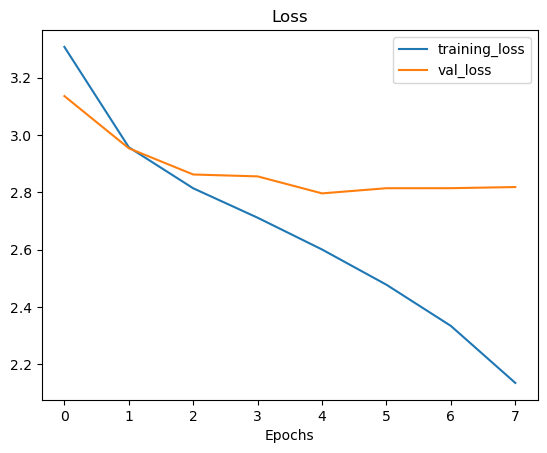

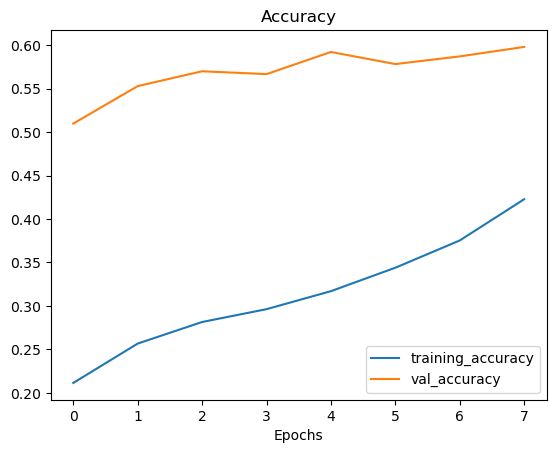

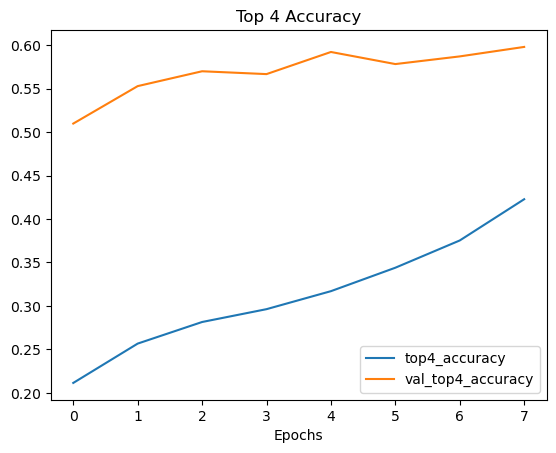

In [37]:
densenet_2_history_genre = densenet(densenet_2_config)

Reading: 55215 tracks, 11199 albums, 3547 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_genre/test/pop/1397142.png
1/1 [==============================] - 4s 4s/step
Track info:
 {'artist_id': 439371, 'album_id': 163630, 'path': '42/1397142.mp3', 'duration': 237.0, 'tags': ['genre---pop', 'genre---rock'], 'genre': {'rock', 'pop'}, 'instrument': set(), 'mood/theme': set()}


,class_name,prob
23,alternative,0.627572
1,metal,0.126854
2,rock,0.098620
52,indie,0.041652


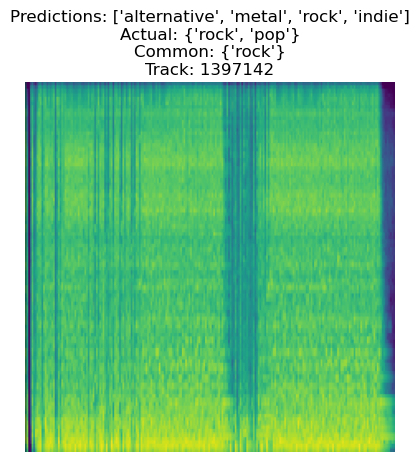

In [16]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_genre', 
                                                               'densenet201_1_TL_FT')),
                       'genre'
                      )

Reading: 55215 tracks, 11199 albums, 3547 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_genre/test/popfolk/405665.png
1/1 [==============================] - 3s 3s/step
Track info:
 {'artist_id': 352713, 'album_id': 50358, 'path': '65/405665.mp3', 'duration': 186.0, 'tags': ['genre---popfolk', 'genre---world'], 'genre': {'popfolk', 'world'}, 'instrument': set(), 'mood/theme': set()}


,class_name,prob
3,pop,0.165695
52,indie,0.115720
7,easylistening,0.081393
23,alternative,0.080970


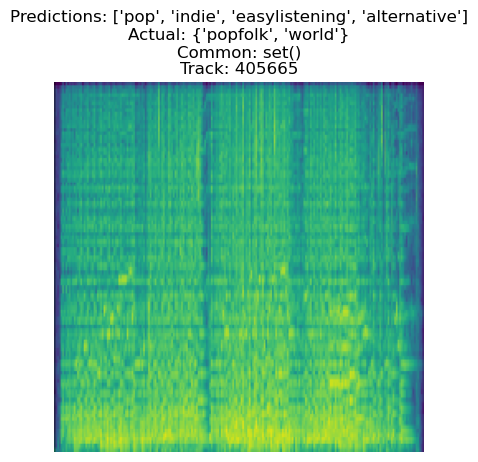

In [18]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_genre', 
                                                               'densenet201_1_TL_FT')),
                       'genre'
                      )

Reading: 55215 tracks, 11199 albums, 3547 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_genre/test/electropop/1372191.png
1/1 [==============================] - 2s 2s/step
Track info:
 {'artist_id': 492925, 'album_id': 161405, 'path': '91/1372191.mp3', 'duration': 152.8, 'tags': ['genre---electropop', 'genre---pop', 'genre---poprock'], 'genre': {'pop', 'poprock', 'electropop'}, 'instrument': set(), 'mood/theme': set()}


,class_name,prob
6,electronic,0.221241
12,ambient,0.209421
14,downtempo,0.139679
23,alternative,0.121866


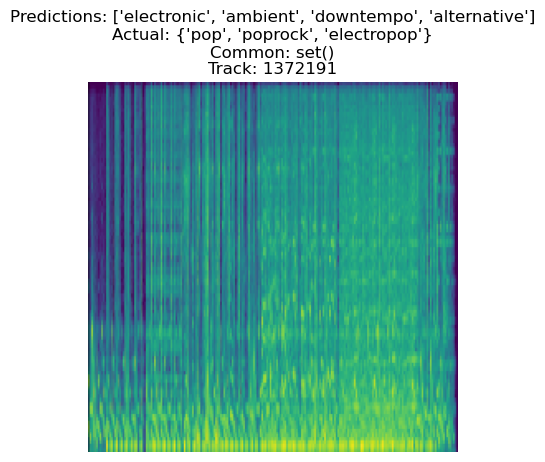

In [19]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_genre', 
                                                               'densenet201_1_TL_FT')),
                       'genre'
                      )

Reading: 55215 tracks, 11199 albums, 3547 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_genre/test/rock/175339.png
1/1 [==============================] - 4s 4s/step
Track info:
 {'artist_id': 2485, 'album_id': 25988, 'path': '39/175339.mp3', 'duration': 203.0, 'tags': ['genre---rock'], 'genre': {'rock'}, 'instrument': set(), 'mood/theme': set()}


,class_name,prob
23,alternative,0.500656
2,rock,0.291868
1,metal,0.093161
3,pop,0.063132


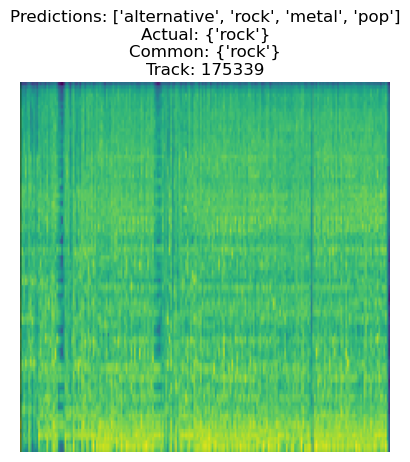

In [21]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_genre', 
                                                               'densenet201_1_TL_FT')),
                       'genre'
                      )

Reading: 55215 tracks, 11199 albums, 3547 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_genre/test/ambient/405661.png
1/1 [==============================] - 4s 4s/step
Track info:
 {'artist_id': 352713, 'album_id': 50358, 'path': '61/405661.mp3', 'duration': 130.5, 'tags': ['genre---ambient', 'genre---easylistening'], 'genre': {'ambient', 'easylistening'}, 'instrument': set(), 'mood/theme': set()}


,class_name,prob
12,ambient,0.563480
23,alternative,0.121043
18,newage,0.060204
77,darkambient,0.057486


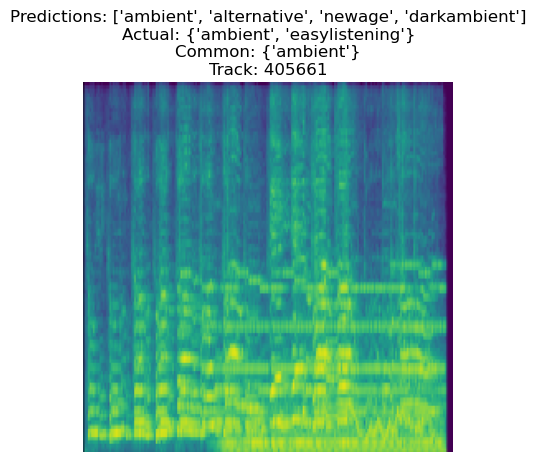

In [22]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_genre', 
                                                               'densenet201_1_TL_FT')),
                       'genre'
                      )

Reading: 55215 tracks, 11199 albums, 3547 artists
/Volumes/Files/Syncthing/MA981/spectrograms_png_genre/test/electronic/1051920.png
1/1 [==============================] - 4s 4s/step
Track info:
 {'artist_id': 4347, 'album_id': 123889, 'path': '20/1051920.mp3', 'duration': 217.0, 'tags': ['genre---electronic', 'genre---house'], 'genre': {'house', 'electronic'}, 'instrument': set(), 'mood/theme': set()}


,class_name,prob
6,electronic,0.701794
46,dance,0.113441
12,ambient,0.039078
53,club,0.027615


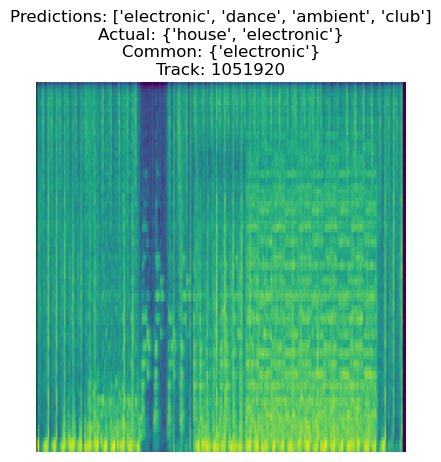

In [23]:
make_random_prediction(tf.keras.models.load_model(os.path.join(PROJECT_ROOT, 
                                                               'models_genre', 
                                                               'densenet201_1_TL_FT')),
                       'genre'
                      )